# Introduction
For those of you who are new to the concept of Generative Adversarial Networks(GAN) , you might wanna visit [this](https://www.kaggle.com/ibtesama/generative-adversarial-networks-demystified) before going through this kernel or you can read the brief overview below.

In this kernel, I implement an **Image to Image Translation Model** using **Conditional GAN** (which is like one step ahead of the basic GAN architecture) based on [this](https://arxiv.org/pdf/1611.07004.pdf) amazing paper.

Taking the **cityscapes** dataset , I will translate the semantically labeled image back to it's original form. The model architecture is generic and can be used on other datasets as well like the **edges2shoes**, **facades** and **maps** (present in the data folder of this kernel).And don't worry if you are new to neural networks , I will walk you through every step.

![](https://github.com/Ibtastic/Generative-Adversarial-Networks/raw/master/Conditional%20GAN/image.png)


## Conditional GAN

Basically, a Generative Adversarial Network consists of two parts pitting against each other i.e. the Discriminator and the Generator.
The **generator** takes the role of a forger and learns to map from a latent space to a particular data distribution of interest.The **Discriminator** on the other hand takes the role of the evaluator and tries to distinguish the fake data (created by the Generator) from the real one. These two neural networks work in a loop to create what we call the "Generative Adversarial Networks".As the iterations increase the ability of the Generator to create realistic images(for example) increases.

The GAN architecture can be modified to include additional inputs, y, on which the models can be conditioned. y can be any type of additional inputs, for example, class labels. The conditioning can be achieved by simply feeding y to both the Generator — G(z|y) and the Discriminator — D(x|y).*These networks not only learn the mapping from the input image to the output image, but also learn a loss function to train this mapping*.
![](https://github.com/Ibtastic/Generative-Adversarial-Networks/blob/master/Conditional%20GAN/1.png?raw=true)



In our case y will be the semantically labeled photos .

Now, first let's take a look at the objective function of the traditional GAN so we can compare it with our conditional GAN.

To learn a generator distribution pg over data x,the generator builds a mapping function from a prior noise distribution pz(z) to data space as G(z). The discriminator outputs, a single scalar representing the probability that x came from training data rather than pg.

G and D are both trained simultaneously: we adjust parameters for G to minimize log(1 - D(G(z)) and adjust parameters for D to minimize logD(x), as if they are following the two-player min-max game with value function V (G;D):
![](https://github.com/Ibtastic/Generative-Adversarial-Networks/raw/master/GAN/loss.png)

The objective function of the two player minimax game for conditional GAN changes to:- 
![](https://github.com/Ibtastic/Generative-Adversarial-Networks/raw/master/Conditional%20GAN/loss.png)

Now we adjust parameters for G to minimize log(1 - D(G(z)) given y and adjust parameters for D to minimize logD(x) again given y.

Time to load the libraries and our dataset.

In [1]:
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
import os
from imageio import imread
print(os.listdir("../input"))

Using TensorFlow backend.


['facades', 'maps', 'cityscapes', 'edges2shoes']


A look at the images in our dataset.

![](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeQAAAECCAYAAAAvs6RmAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4yLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvOIA7rQAAIABJREFUeJzsvcmTZcl15vdz9zu+IcacaySBQrFI%0ACA1SpFoSu2WSiSYuKJMZd/gnZKYFe4MNd1yolzTTSgttsZWMyzbrhTgIbLIBFAEQxFBzVsYc8aY7%0AursWft2fv5eRBSCRyMwC4pilRb6I++7169evn3O+851zhLXWciM3ciM3ciM3ciMvVOSLHsCN3MiN%0A3MiN3MiN3CjkG7mRG7mRG7mRl0JuFPKN3MiN3MiN3MhLIDcK+UZu5EZu5EZu5CWQG4V8IzdyIzdy%0AIzfyEsiNQr6RG7mRG7mRG3kJJHnWJ/yLv/gLvv3tbyOE4Otf/zpf+cpXnvUlbuRGbuRGbuRGfuXk%0AmSrkb37zm3zwwQd84xvf4Mc//jFf//rX+cY3vvEsL3EjN3IjN3IjN/IrKc8Usv7bv/1b/uiP/giA%0AL3zhC1xdXbFYLJ7lJW7kRm7kRm7kRn4l5Zkq5NPTU/b398Png4MDTk5OnuUlbuRGbuRGbuRGfiXl%0Al0rq+mlVOf/5B//8y7z8jdzIjdzIjdzISyUPHjx44t+eaQz5zp07nJ6ehs/Hx8fcvn37icf/D//T%0A/8inH3zC/TdewRiDtTb89MpcShn+AQghMLYHwBiDMWbjnEqpjf/7cxpjSNM0fNZah/MJIVBKIYQI%0A14rHYCWkaUqSJLRtizEGpRRJkiClpOs6uq4jz3OSJImu2SOlZDweY9Hhe1mWcHl5Sd/3SClIkoQ0%0ATSmKgrxIQUmapgnX8+Oq65osy2iahr7v3fF5jhACay31okFrjRACsHz3mz/kt//gi2Hu3Fy56/W9%0AYX9/nzRNOb04RWtNkiRorSnLEiklV1dX1HVNkiQIIbh//z4HBwcopVBKMZ7u8/d///cIIfjX//q/%0A4cGDB7RtS1GUrFYr/p//+6/ouo7f//3f56233hrmNqGXNadHx0M4wzCdTvnwgw84OTnirbfeYjmf%0A0XUdTVVzdnbGeDxGSrBCcnl5Sdu25HmO1pqmaRBCsLe3x+npKaPRiCzLaNsWrTVpmqLSjK7rAPg3%0A/+a/4+7du/zTP/0T4/GYvnPP5Mtf/jKz2YLVasV4PKZpGtpVRZbnSClpdU/btshE0TQN/+f//n/w%0Av379f2M+m/Hh+x8wu7hECTfPliasYy/+GWwbqX6dWWuxIglrcvunP58/j3/OSikODg6YzWbhHrXW%0AaK3D8f48sTxafI+vfe1/phxLVNKyqq4o8pQsy6hWHc5WNyCi98s+n6SMf//v/iP/7t//98/lWs9K%0AdLIEDBILGARm+JwO8yawAgwGI3oQPVZ2iH4nOks0v4/N9ebn3LzCf/wP/8jf/Yf3gBI6iRBLhlcf%0ArAJSLBKLgaQGAba1/NH/8mX+y//6C6Tjirq7ROsUmYyxRoHoQXQo0YGxCD0Fm2LV6qnmpTMZaZog%0AreLkYcv7/7JCtvsIW1MUAt1blsuGv/u7v8HS0bUCyIHqied0+5fTAUVR8Md//Mc0TRPejRclf/VX%0Af8Wf/MmfhM95nlPXNV3XMR6PMcbQ9z15nj/xHM9UIf/hH/4hf/mXf8nXvvY1vvvd73Lnzh0mk8kT%0Aj/fK1CvIWBknyeND88rTaPe9eHOLNx1/Xq9I4g3KH+v/5h9i/DD9WMJ45PpaXhHHCtqPq+s6jDFh%0ALKPRCK01WZZh0VRVRdM0WKvZ39+nbVtmsyu01iil6PseW2s0lr7v2dvbC9dSSlEUBScnJ+H8/j6t%0AtW4zlqCk2riv0WQc7skZAM5A6PueTrecXZyyu7eH1prLy8uNeyqKAiklRVHQNA1N0zCbzciyjNFo%0AhFKKruvQWtO2dZi/rmtJkgRj+3Bvo9EIgKZpwv2cnZ1xdPQpZVnSNg1g+da3vsWoyJlMJuRpxp07%0Ad1gsFrRtx5d+6x2++93v0vc9WZaFZ6G1DkaUf75Syg0jLzbsjDEsl0vatuVg/xbWWhaLBV3XUZYl%0Afd9jjAkGl59fpRRqMLj8+vLXX61WpCqhKIrHjMrrFOJ1Yq197Fi/trzyjQ1Of52jo6NgUPn7ixXy%0AdWMo9yHbvaTWCwQVbbKgs4akU5BKsMPxYv2OWQRWPHmjfJZSZ99/LtfZFmHUTz/o2u/tAtALQBi8%0AGWNFh8UgpEVYA0IjaRFopOlpVOsPjM4m3b+glLf/BokZs7MPcgy2qbC908NSgN8WBSmQDgadAOlG%0AJcoLZHmOVpd0/Tk2z+nJsFKA6EA0SNG4Y/UIaTK0fDIX6LPWt25uYY1A6IxWa5CQ5QdgBG3bkqiM%0AJEnoOg1YhHQGzGeBq96ZAqjrmr7vg4HqFfWLEm8Uw6Zea5q1kR4fsy3PVCH/3u/9Hr/zO7/D1772%0ANYQQ/Pmf//lnHh8r5Os8B78R+c/BY936ed33ts8rpXxMyVtrwwMcj8cb3jSsF5pUMnihftPzG533%0A0Lw3DoSNUym1VgyY8P++77HWhmNiL8kYy3g6CUrRKzyAqqrIsizytDOAsPkK4efFoFQKQJZl9H0f%0ArllVFVJKlFKUZclkMg7nb9tBkQ5zkOf5hhKw1gbjpu97et2Ge/KIgJ9DpRRt29J2LU3TUFVVQCHA%0AcnBwMBzbc3JygjWGrmvCNeq65uriEmMMbdtyeLjP/v4+o9GI1WpFXddhofs5kFIGZd/3fZgjoRKq%0AqqLrujCvk8mE6XQKVoYXZDQaUdfOK9/d3cUCi8WC8XjMYrEIRpSfr67rwnP089B1HUKuFXG8fn+a%0AXLexxWt9+/8x2uONEL8WvbFQ1/W11+80rOqetm8ox5Ikz+j7hnm1osxGG8caPywrQT6f5nC9eTFN%0A6KQ1P/2g676n3ftmBWgrsEKiBVjhPGVhNBKDoEdZicBg0ejgBwyTHJSwjD5v/Q4wpiPLJVKCBmSm%0AoNdICb0BsM4QAKwV7vzDramkYFU1CN2hhcBagbEWaw1gQWoQGoFBGg1Ww2fNy2c8KqUaEAIrtDtM%0AQNdW9G1NmgzIjxEkKkObBmMtP818jQ3ieK/2a/9FSnx9vzf4sXm94fft6+SZ5yH/2Z/92c987JM8%0A3Os2ptjrEHJzo4qPjxX5WlGJSBmsj4vPkaZpUJbxOIQQyGGS/SYPbHjcSZKglKKu66AYPHStlHIb%0AuDDBK+8652n6Y+IxqkSQpmlQfG3bhmNWqxX3798P3/XemN+QTQT5x3Cn1gZrIU0z6rpmuVwOCyMh%0AyxJm81UYS+wRpmka5tF7yt7T9V7haFzQNn2ERHQoVdB1HZPJBCEE40lJr1u6zt1bX7egzeD9zjg+%0APiZJEq6uLhiNRlxeXjKdTtGdexbL5ZLd3SmffvppmG9wi388HjMajTg5OQkQfrwOsiyj6fqg6L33%0Am6Ypo9GIxXwVhTQkx8fH/OhHP+Kdd96hXVUcn5xw9+5d3nv/PQDOLs7D+jg+PiZNEvLcefRt7UIJ%0AKjEbRlu8fj8LVtte9/H63EaRvFHgjSt/DY/+TKdTptMp7733XpiLWJF3GpSaQt9hrSZRCoRCNhah%0Ayg2PTQlL2CZF+sTxP0uRcuenH/RLEPG0Cll1WAGWBCkEGoEUYIR7NgNojbIKZRXCWqSxKBVpsw2P%0AWEbK2Ctn/0wkSiju37/PF75wDt0OmZwiTU+awHS6j7AFghFClA4ql5XzfoFbh/cRQtHrCqtyhMxJ%0AZUnfa3eMtCAEAoOgBJtuICU/jyjl9kxpBFkOKrGI1t2H1gajNV3n9peuNyB+ukL1azk2eP27/aIV%0Acuy9+/fdv5c+9NS27RO//8wV8s8jsdKINwxg4yZgvSkZY1A/xevYVsjeg4njxtuxNf8g44e9fS7v%0A+fnPPjaQZRlpmgb4BPxGKUK8Q0jrvLVIIRdFgRDr8TjPRnJxcUHbtsFr996OlJLRaMRsNgtK0itu%0Ad2/aLXKzRh/AjRW7hp6rakXXdWRZEqxMIUSIY8eL28ervXIrioK2bem6jrquh3hzE8biPXVjDPfv%0A32M0GvPgwQPK0sWVvfdY1zUHBwfcunWL0WjEqCxZLGYBjh6NRtSrKlzfGzY7Ozv0fR+85Nh793PU%0Atm2IKXmjJjbKvCfrPVyv7Nq25dGjR/zoRz/i3r17nB+f8MGHH9K2Lf/yL/9CkiR88unDsDaOjo7Y%0A39sjTVMmkwlLu/aaY6g5Di08jcRj9GvYw/CxMvaGWZ7nTKdTbt++zXvvvRfOseFZA1m+Q9UuaNoK%0AYy1SKaTKMTaGS4k8IAk8H4VsdfFcrvPYdcXTQZ5SnWNRWBL3UyRYBEZa5w1b4xAs4+ZWWokwCqk1%0AG5B0mHcVYs/r36+V87Kq2d25w+uvv4Ftpkg7wrQ1aeKQLuzgkctByUnt4sOASkqssKikwCaGugWk%0ARcohHGMSpNBYLMIkw1ie7nksamcoZ0JircQYSIZ3sSwydC/ouy4KrdjP9sYj8e9VlmXh/X1ZxRvK%0AHqV7krxQhRwr31gZAxsK8zpP2v/dezx+c2rbltFoRJqmLBaLoMzijdFfM76G30hhDYWEzSvyTOLv%0AxR6uj2N4D3O1WtF1DhZWSlFXlYszpilpmgY4eDweBSOgqirMqqe3hqIoAlztjYrJZMKnn37KdDpF%0ACBEUjVf6WZaB0NR1i0f8ut7QtGaIYyckaUq/MCAFab4mOxljAhycJAmHh4dMp1Pm8zlSSsqyDJDx%0AbDZjPp9zcPsOFxcXrFYrqnrJdDplNpsNyrPh3/7bfwtA23Ysl8tgyKhMsVwuOT09dRCvEMznc+7d%0Au8ejR4+wwGw2o60dHH3//n1OT0/Z3T/g9u3bKKU4Pz/fCBFMp1MePHjA2dkZd+/e5fz8PJAq9vb2%0AOTs7o6qqQIar65oPP/yQN9/4TcqyZGdnh6OjE9I05fXXX6csSwAODw85ODhgNBpRVRUPHjwIMPnR%0A0RGvv/Ya56dnPHr0iHG5hnq9ARcbdh5K9mslNjqFEOhhbcWy7WnHa3STrOfmwXMbFotFMEr8+opR%0AHaPdmk+SBKTCigbD49ffeF+FAft8tgz7gqr6iqe8Py2W1HXDzt4d6roDkVIUJcumwvQdaZphtQab%0AkKcjTCsQFKh+y1iznvwnUTIF3L6W5QWJSrFWsFgssEpSrVrKYsr5Vc84TzGmQqmEJJGO1GUt1mos%0AGkQDwikCYzukStB0aN0hZIJUAmNs8ISNiKITVoB4uufh3yPHz9ijba9QViBlQtdqrFWBDAuAMFir%0AP+OMj4csvdH+JALj85T4+tvvkjeY0/TJRu0LVcifJdux49hrTdMkbDLbMp1ON244hvm24YyYdONj%0Abf5z7DH3Vj+m0GOvfpvpHY/fb4Kb8T4bYG6voD2U0XZ6g5jVdR1N0wRS12QyCUQiIHh6xhgWixVK%0AKYy2rFbufppaY40AK9G9RQgXV5VKUBQjpKwZlRllWXL37l3KsqQoCmfVZllQxnFcuSgKlFK8/9GH%0AvPvuuwEePT07dtcCwPDhhx8GUtd47GK2ZVlysbjg4uJigIndHLQD6aGqKpRwyiXPc8qy5Pbt2+zu%0AOuNAa81sNqNpmuDJAwFK39nZYWdnhwcPHnBxccHl5SWHt+/w4MEDzs/PUUqxWq3QWjOZTAI8b61l%0Af3+fi4sLHj165Da9wdByRDx3nGhkWCv+mTVN45jf6WZs6DpSVww1x6iQMQaxFX/aXv/x5/gYpVR4%0APj4LoG3bjTXsrxnWpwXoQWi3UYseQT/AmnKTXT24yM9zqxO8IHKOeDrIOs0ndDrBaEXf+ewMSUGG%0AtqCsxPYC26X0KoN+RK4OSIUd3vVkg3uiZD4gahIhFFIkSOm261tTy6I+5vykwZgVureYFLByvReJ%0AfoCae/fgRAtyIGrJdnjujfud0SCS4Ti/BlyYzXnVA+P+F5YIhreO/W2NQDylsv9VlJdaIW9vRrAm%0AZ4VNLPJAgABHenjZw5T++CcRwbyn6D3t2HNJ1Npj9qShmNTlx+jHtYa9CZabsXHsz1CWZdjwvReU%0ApikqETT9eix+bN77LssyEItiz9yjBVpbVqsGzxtompa67jBGUJYTvvrbv41KLFI65bVYzrl9606Y%0Au7qumc/nnJ2dsVqtOD09pSiKgER4ZXd4eMgXv/hFHj16xGg04vDwFlVVsbu3Q98Z5vN5iEO7OK+z%0AlFer1UY899atAx48eMDJ8TF57uK6unOeP1shjK7rOD09DQQxcPPrr+OV40cffRQU33Q6ZbFYsLe3%0AFzxUj3KMRqMN/oCULt3s6uqK6XRKnuchju5Rl1ippWkaoPu6rinzYsNQvA7h8c8xhrNDKCayF+P7%0A9p+334c49Sk+xocU4pDPtpctJCA7MC3YFkGDkBpMP3hD8SbpN/mfHU78hWVQHs9dnjK1q+9KrMno%0AuxIFSJGR2wKo6C3kIicfj1FighJ7JHafIn2FNBmU5NY+JoQcjFuPggC9M9LLvCAfQd/MKIs5Uvb0%0AnSZRKVq36+ck+jWiIRxRC0AmDUiBFTWWGkSGFco99+E4OcSbERphe6z4bK/1iWIFQrgULGdcyIEl%0AuDnPm0r5ZwvtPIlH9HmWl1Yhb29AcdzXKwevkL1C85uhj+U+zkJ+nNS1vWF5JefFe8j+/35DjZWy%0AP7+PZazHS4gXJOk6XUbKdVpSVVUsFguyLGN3d5fd6ZSL2RWr1SrAyJ6Z52Fqr+z8Z3DK4bU3fhNj%0A4KMPPyVNXMzn8NZrVFUV8pXf/e4/c3F5RtfV3L5zCMDuZEzXdZycnASYczQaUZZlgK19ulLTNJyf%0An5MkCf/wrf/Mn/7pn/KDH/yA9977MQ8evBrYzHt7ewOzex2D93NYFAWvv/464CCt3d1d3n/vPU5O%0AFhvGk+764L1eXp5z5979QLyLQwpSSqqqCpXi0jTlzTff5Ac/+AHn5+f0Zk1WA4L3WFUVtw7vRPwC%0Ad9/vvPMOX/rSl5idX7C7t8fOzg7jnakz1JRktXI5me+88w7j0YjT45NgOPlc9+04sv+8nTsfr1+2%0A+BLxd/z/t41F2CRz+e97iec9RnOkBWUt0mqsMIiBtpUgnPfsFdPgMZqgjJ+PohTP6TrbInk6UlCj%0AM/J8BBoyYRH9Cl2fMy2XaLOiJGd/5z7GaI6Pr5i3VzR1RTJ6FJ1l09hxqXbpsHaHfcY4Lsfezqvc%0AufOAnf/2Ad/OfsxP/uURo1FJVS1ZAzVDDNpuGlhpBkoYetsjhcagEUYjsEAfiG2OZY3Tj+Ip47M2%0AAwRCpEiRIUWGEApj9UBSE9F6Hubg5zCKrgtnfp7lpVfIsJk+ApswcKwYr4O34807hrJjTxbY2CRj%0ADwZAivXnGCb1ysWTjrY9d68E4vxXXxjEF/mYTCZrlvTgofrveqPCK9O6rjfGHc+Dg7a7ARYesZjX%0Aw/1rynIyoAYdkFDkI8qy4NbhHUfcqubBEDHGxa899DubzQBX9MUrLv/3Zb1iNpuxv7+PlJLJZMR8%0AvnQep+0j0tmacZimKVVbbxhL4/GY3d1d2ramqqpwLGozp/ri4gJfICX2KJIk2SgGorUO8Hae5zRN%0AE/Lh/Vy/+eabjMdjinzEJ598MsShd7l9+3YIC+zt7SGHUMF4Z+qMscQxuwFXJnZYVzGfwLK5tvw4%0At9fctvh1E/99W7Fvkw3jdR8jQGvjb22objDwLVirkEZhpSvcII2kNyDJwKqB1GsARxBymObzSUeS%0Az6kIybMSKztEKunaisxaEtmxM9X8V199lYODDE2PSsZ8etJwNTulMw0yS1nqh9HeFiN+FpsITOAQ%0ASKxyz7m2kvOLnFG5w+7eq7z22n1OHy2wXT8ca9hMlUqGmLIzNhKRge2dfSXc74Xz6wfl6wqbSKsQ%0AVoFNfuGn7tbrZqZL+D3eyJRPdZ1YTzzp3fq8yEurkGM4ehtuk2pNJY9Zz15Zxl6s39y3veP453Uw%0Aoxe/ecVQ9rbHEo8l9oDiVJf4XrIso6qqYZx5UE5eIVvpmLK+WEWWZVhrAynMK3hvZPgxNU1DnpX0%0AnaEfyCLLZYXRDuLt+oY0c3mJbdNyfHxKVS35wm+8Fjx8P05fOKMsS5qmCcaAZ1Yrpdi/dcDR0RH3%0A7t0Lsd2+N2H+xyMfz18X6WiaBiMMZtg8uq5jf3+f1157DWNcNazG6A0F5O/XVy+Ln6/PNe77PsD5%0Ay+WSvnfn2tnZ4eTsnPl8TlEULJdLDg8PeeWVV0jTlE8+/pTVasXe3l5AHfI8Zz6fM86LYBilhSOI%0AJWK9bnzsOza+jDGBGHMdZA2P5yqG711jWPq1fx3/Ic7B3Fbi/vfea95+n0QH0iiwmYOrTYrzjlwx%0ACZCDpzxs7mKIKT6TWOJPF2FfVPrK091fo2tKmWJsg5SQ0TEdK9750iFdf0HVzjGiwZo588WnzFYj%0AegOTu2tUY/1vQNkAYy3aWkAipA9zQN/UnJ0fUaaH3Lt/l/v3Z3z4k/eG8IsvNiIHyNopVQ9fS5Ej%0AEIP3agYiW4JncbsqY9YpZ5sgjcJ8BtnvsyR2jrYdKy+P//6zPd3rFG+MRH2e5aVVyNsWvv+d26TW%0AllZcWMN7oP73sScZQ33bD8172vD4JmqtpW5q0jQNCiuufhQriJid7YyE7rGUF6+4vRLxhC3vYele%0AI2USlHTbtiHGuVqtQkqQH4MnXrmKYOUQU9WB5GS0a/rx5S9/mYuLC+pmHowCz9Q9PT11ZSGlZDKZ%0AhDn1xs1sNqNtWyaTCWVZMhqNhpQtB5n7MaxWK+7cuReKj8RxTBHlF6pEMb+8CrB+WZYuP3lAHkKc%0AFYL3W5YlddtF6WHJBjHu6uoq3NPu7m6Yu8vLS8bjMcfHx0ynU0ajSVgP8/mcjz76KBDIfDy6LMtw%0ATBxz3s7xjlEK/9kYg1Sba3h7E4qZ036OtdZIsfk6xt/bXuf+37YhtaF0h/W5PW4PgTqlOxBt/OZt%0ANW5bWOe8ulikHxTPST5fHrKf6yRJkLZHdw3VoqVenqPNBcZUpMWUPO/JChhZS2uhiVNghDeaLIh1%0AiUjda6zVKJWiBg84SQWXlxfsTWbc3b/L4a19fvIvPyTLlIs3hxQpsfWT4V0c4GIPZxsBQrnHKyRy%0AyHmWW3D3U87OzzyH9jkhMC+rvFCFHDYuNMZupoDAOmbcde1WHHnNsvYVqPwL4T1KH+/0EKX3ImHT%0AY4k3U79Rxt6OtZaiKIfrrjdlBljSVeqygCMuJIlEa0vTrtjf32Gx6NGmRqrUwVC2p+ta8tzVeK1r%0AB9N6JnPfGYQ1JEoiSLh96zbz+Zzj41Om0ylKZugelMzAavrOohQolZFnK/JihLYz5jN3r73oGO1O%0AyccTdqUiWQiuLs9IpEW3HQ/u3OXy4gTddnRNQ56kmK53BK3dXVbzBaO8IFEJwljSVIE2zC5cTens%0ATsp7P/oxv/M7/wWXZ5fML68oimJgfGoQAmslQth12o9t+Pij9zDGsLu7y+1bB0hrWFzN6JuWLMnQ%0AvUZYaHXLeeNSnKQRFFnO7q0dus6lUhmtIbWYVpOXGbPZjDzPsdaSoMhVRnW2RFuDTS0H031SmfLB%0A+x/x/vvvU4xKHjx4wO7uLsePHvGP/+mb/N5Xf5fzszPUg1exUvLt73yHN954AyEEy9kixGXPT88d%0ABF83VG3LwcGBQykGhbZWqEOlJLxiha7zStWtHaUSlwu8ZYB6AyQOT8DasPNrMP5e/DNGbPy67vse%0AI0FLTZ/UIBukbJAKjNBY5v4Ndf+sGLx+z7j95Yt+YeHAp7u/A6lp52couct8NSZXCUK8j1bvUZqG%0APQr6xYI7pmDUJazkPrPxEZNmd30SC85SGsJtrctRTmQUatOu+lYtzpGjkoen/8zO9JC33voC3/6b%0A7yG6Bts3pGmLtj0YQZJMmHcVxcgZvF3+AcImyCx1Oee6A1kN62YgkTGgdkmD4w083bwoqREUYEak%0AaoLlGMMSSNx6My2Glr2DnItLbwwq4MnlJWNnzRuzvsb/Z6XtfR7kpchDftLv4/gZcK1i3YafY4jO%0Ax/ZiCHn7Gtve93X//AuyHRP0ULkLd6q1YZBKEHmI/3oSUFxrOM5r9p4yrBsD+Pj04eFhiFmmacpq%0AtQqFOrxi8OPS2m220+mUPBPhO9a6ueh1S9c0dF2DTEVIM/LMcQ+J+7KaQojAaPbx97Zt14ntap0H%0A6wlNa9Z3VLxiy9A5OTkhz3POz8/RWnN2dkZXN0ynU+q6phnSiuKSlP5ePSt9u/zoV7/6Vfq+5+OP%0AP6aqKqqqCpXT8qyg7TtWqxXvv/8+i9WS3f19yrLk4PCQPM+pqopHjx7x6aefcvrqazRNw8cff8z3%0Av/c9kiTh4cOHXFxcMC7KsI6+973vuY0givs7Jflkokm8XuM16DaSzdrTT4L4tiWuQreRPz+srRhV%0ACND37Kee9kZ+DjGogdkMUgigx9JjZI9VrjCIMZqent544ufTw/JJItG9HjIPjrkzvYXGIvp+iAcT%0AyFFWuJi0SjxC8tlhul+GGGPomgZrY6PxV4uQ9SzkpTEnrou3xQSptXe8WdEr/r73GoCgtPx3rlPi%0AsTwJDtxUzOHojXPHpC0Pt/rmBz4x3sOx3kOBdVzaQ59egfnjvUL3KTeePe6h1biBgI9fN007KFBn%0AmORp6ghauxMOdvc2rutZ4f4aPtdZynUDCl/ExI/Bx4GXy+XQrYlQe9oXO/HksO0YsL/33d1dFotF%0A6Mz0ox/9iPfff5979+6F1mT+/mJF5y1in9YToxonJychd1gp18xib2+P/f39YKR5SNsT1x48eBAI%0AaXHSvldkk/GYtm15++23mUwmHB8fB2gfHEP+4uIiwORx6c7r1vY2uWpbIcdkwm1P+Uni7zf2DOKq%0AXl3Xbaw3HwK4kWcsIQ4LYkgdsjQI2SOUwaoeLXsMHukQqF/EH1JgTE+vaz78+EOHRlk5lKFUCFKE%0AcGQtx7uxpNnaaRHSFQH52ZTyL84b0L0NKY/rWgX8DNf+9ZKXwkPeJlzFZJZtUpTf1K8jCvifvjKX%0AJ07BuktTrHS3N8rrle82U1VvfC9J1sqi64dGE8Jd6+zsjL29PQ4PDx28GhVuGI/HCOFSGHw5Nb9h%0AemWUZRlnZ2cbhDI/llgZe0ONoS1+AAAgAElEQVRE9xata7q6p2rcPZRlwYMHr2C6ltE4I80UWSJp%0Ampqd6QitO/reHfv222+zv7/Pt771rZDqtLe3F7xi7yV3XUdVVSR5Foyd4+NjDg4Owt9ABgZ61VYb%0AKWL/33/+G7LEeftFUbC/v89kusOdO3e4d+8enwxebmvW9aidQdIipV8rjujSdZr5fBli8m6NiOFv%0AHRcXx+yUU7qu41+9/TZf/b3fBSkGooxT0ko4ZehizCM+/fRTHj16xN7pOXfv3mWxcOlYmVordv+z%0ArqqwHmKj60kEk+sQn7VBpzeIWv5c3lB7kiHae3Y2buu03ruWEjUgHkjHk+60xr7gjji/kmJGGFM5%0ANEhZEBWNrtEKagM2FRiRItqSZDRCtQW2e/p4adtfkaQl1hb84Pvf5zfu/y47O7ss5i1SKEfaEhIr%0AFdiefNSyf9ulQiqlMLbH2KHxhVijgJsMbf/5FxFX2KRtex49ukQIZ7AKIYYc5dgAZUi+M8+LzP/S%0AyUuhkGETQvGKZnsD8p+vq0ntv+8hV9/sAdaeQQxfX7exbUtMghlGsAU5arReE3niSjue1ORZyXme%0Ab3h9Xrn5zbgb6rkmSUI2jLHrupDz61nD3gPzHpD3tpxn3gbvMMnkcH6o64qVWVG0BUJY8jylayvA%0Afbeum0AO8h5xXdcURRHO7QuneHKblDIQu7zx41EC73GenZ050pp0tZ6999l1HbcPbyGlZLFYsFwu%0AGRcOIv/kk0/wFcGUWOedx3GjmE9grQ15z+fnrvGD9+x94Y/VYkWSJmHOXfqSa87R6Z7R2HV5Wq1W%0ANE3DdDxhf3+fxXJBWZb88IePeHD3Hrdv30IpyWrpkAElBUWR0zQ1V1dXoKdu7YrN1LtYQXtjcXvN%0Ax7Hebbh6e63GhmyssON1G6M2TzIObuTZiQi1p72CA23BiBEdLdKWGJGjVYIWEotEDFyUpxFtarI0%0AQ6QWhKZpV47zsbjAGpdb7vobO45OmmlGk2E9obEDvO7WBlirr4HQnwGjfiCFWWupVg1KuvRDawcW%0At3gy+/rXUV5alvV1rFbgMc82VshxHM1vUvEGGCvkuCuHP9f257VC9hsjw0+njI0ZNj3bY7XYuJbW%0AjlxW13XwcP19eYMjrrQUb8bjASr1HrW/Zt/3gT0df8f/vWtadJIOLG1nDfe65eTkiCTJWCwUfd+6%0A9J/FlTt/U4U5u7i4QAhXlSpu6BDHyz0jeTwek4/KMH7flcpD9m3b895779E0DQf7twIzXAjBl770%0AJS7PLyjLkuVyyWw2c4UqlOLhw4cBLZBChhho3DpzWyF7Y8IzpWezGUKIYFgI1kaVexYJ6VAC1NZV%0AuMednR1ef/117t6+466b5eihDvd4PHY5zXUd4v2/9Vu/hbXWQdlVHeqP910TlOD2ZhMzrD26sG14%0A/jyhlp8m/t6e9vs38rNJ3M5YCIE1LsOht3soq+ko6bWkaiR15/geKnn65yGkxkqNED1ZDn1fs7+/%0Az6effIixYsg5HoqCiB6VaYpyk2eAsAghB4XsKgs6uc5L/gXSnqQjNbZtyzhLMYH1vc3JWe+xv67y%0A0njI8e9iD/k6ODtOYdquXORjrIFQNMRo45SoGIL2su3NxL+P/+a+Y7ADYUIlAmNkdK51JamyLLm6%0AuqKu6+Ah+nP5eHAMA3ulWw41lr23P5lMwkbuN9hY+ft62KtuRVs3tH3LdOrutWta5guXLmW0xuqK%0AbChy0dQ1i8WCnZ0dPNnKX9crA9/AwseO/d99Zyg/n33fbnhrWmsePnzoKnwlzqv3nn5Zlny8+Ij5%0AfM5qteKVV14B4Dvf+c6GMWCsDjFuB0nXG2GFOKxxdHS00RXLe6N5npOXGcvKVT7LsowkS+mNcb2O%0ApxPmV46ZfffuXYQQTMcTly412WG5XHL//n2urq4o8pw0SQLJ7vDwEGstl2fnoaZ4VVUk6snW/nXx%0A4W2YevsYWBuQ24hRfGyM3sTGWixx8ZAbebai0ahAqMqwukSb2wgEjU5ouo5V31F1lq7XqOLpKTxC%0AWYQ0aNuRZBIjNeU4p7c9SoA1Am2Fa1UrLFJpksyvIbOxl7nfba8Js/XzqUfq/lmB1kM7wo2/R+t8%0AU0f/WspL0X7R5/J6b8hXpoLN4hp+0cTx1rj9nP/pY8zeY/LeZjM0MIi9vnjzij1Z//lx5exwlnhD%0AXZe1rDFGBRhV63W1qtVqtZFLup2nGxOYiqIIUK4vCiKlKw+5Wq2GZgu7LJfL4LU6j9nFTyejaSCT%0AjUYFZVk6LzSRdBqWixk7OxP6zinY1Wq1cV1/7/4+/PPwJDXvLc7nc374wx86AtRkhzfeeCN0RYoZ%0A0svlkrJ0OdLn5+dkE8WjR4+4c+cOd+/edWUsF64QiW+p2Pc9uusDEuA8XcV8NndFSfb3EcJ1ifLr%0AwWhXu/rW4R0uLy9ZLqrQTjLuoQxrtvZ8Pg9Ggi8o4v/VzQqpoKqXZKnC9XpepzBZq8EYijLj1u0D%0Ad9+JQLAZG46Vpl+LXvkfHx+v12LEsvbISJz25NdSHD5I05RlUw9xe4LxAkNjFSyd7klIEQMr3ppf%0A813vlyA9HWnmYrPWgCJnPH2Fv/l/36Nd9dheUHcrmh6M2AeZgGl42naW7v0ClGFvf8Lp2UN+8/BN%0ApIREJa4DkrFMd3ZYVAt290pEEodELCZCYLYLzzwzsZK+N5TlhDwvaZoO6WPHOIOhH2r3i4EN/qT1%0AGRusSqnwHrRtG/gqn3fC4gtVyE9aBDFUF3tB/m9+s99W2vE5t5nLflOLCV2xUr5OvAfiHrzZuH6W%0AZSTpOkbn47GxZ7IdU/bn9GPahtj9cWdnZywWi1Aww3v+dV0zHo/RWof2ej7emqYp77zzDsdHp5yd%0AXwVYdbmaDx1VPHw6jEE/Pg9+LH6csbEBa7Kcb6awqFYhTm+tb26hg9LxzO0Qy12tuLy8JNdJaN6Q%0AZZnzfpv2sfi61WbDUKurtUHlDQefe+g7N/nn7MUYQyI2SXuCTVa+SNm4dyGEKw5ih7iu2WTgW+2O%0AK4aX33fI0l1Pa9brNN5AttfwdfMeFOYWwdAjJ14Bbxex8WEOv5bj9o5xNbM4BHEjvwwZ3jELRiua%0AKuHkIsN2BRhBb6G3BiNSZKKGlodPd6W+75G2B6ORSpEmIJVGSINFO+Sud0ajRSOlQJsXUR9cbv0c%0AZIi3u33QI1uOjGmFQMnNdzbe468Lv0gpP7Ot4edFXqhC9l7LthcKm51s/Obi/+4Vw3YSuN+QvcTK%0A13fmiZXfNhzuz/84kWxNIvNs7TRTgREdsxTd9dYNJHwOr/fcr0t5iRcewGQyCYQwD2X7alWTySQo%0AvBiOF0JwuHdIXbXM5it055i0y+XSxTb7bvAiO/q+BX9f2kD6OHvdj8ejFzE5yI9LZWmI1+7vH24Z%0ASzZ41qEK2UBEOzy8y0cffMjp6Smz2Yzbt29TliX379/n6OhobVRpB5l79nLXrbta+RQKIUSI1W/n%0Am/tnJfTjcdiATPQ91rgqaKvVyrHLK3cumaigfD1ioLs+KPyzszOstcwur8J3/HXja8QSG4FxeMQ4%0AeGNj3fo59wZcnLu+kZ6nZEhJ82PzKVjeo/beuZSugcZNHvKzFWMMUjhilHtWit4o5vMUYV1oB2Ux%0AokOQIEKJyqcVibYGJQxpKsgygabB2ApjQSqFsm7f0dYiUovWnl3/0+DoZ9VucZCo5WIcbDfGuA6P%0AYv1+6t4VnzF6s8HPdmhyG0X1dexjrsnnUV7o6GOLJt7MYfBsBkg69jr9ccAGJOgfTjWkofgNKs6J%0AjR+qv4bf4OKYLGzGVPw4ksRVl4m97yxLwhj6fpNFHUOLcW4zEDzL6XQavD6/sMrJhPF4HMhdfqwe%0Adr+8vGR3d5ckSaiqKsR2/+E//SN13aLSnE6771WLBYkQSOHKBSRFRttYRzpTBdlOyrJyYwkFPyLZ%0Azmf1zSAmkwnjnSlt24ZiJT7NLDaM/FwJIdjb23NpXrYOXqWUkouLC5pVFebYp0N5w8Q3IJ9Mdgfy%0AmAjIgTMasghyNsMYnPfRtj1l+vgy9wZdlmWYXoeCKhcXF3z7299msVhgTL9hhEmxrpkO8A//8PcI%0AS2CYOyg/xZhN7zX+6dn2viezj5Fba+n6xzeheD3G6zju7NRL1w96Op2yu7vL3tChqigK/vqv/5rT%0A01M67WD5t956i7fffpvv/19//dic3MjTi0vn6Z2RK1pUkiFkilY7aF2sOw7KBqFTRCdgZQI68/OK%0AUiUYgVCKYpKSKYNQc4qJYTGbk8oRGhAmRSqH4qj0s9Ldtj3ZZ6SU7VAj20blO61LyUqShF43KGW5%0Ae/cuo9GIPN+h7w27O4686t+b7fCh54r4DIxt7s/nVV4KUtc2GzXe0GPoevv47QfhvQn/0yvS65TE%0ANuTxJAjbWkvfuYcuFchhypzhsE5V8dCg36xjw8IzkOOxxl5xKCk5LC7fVMLHUj1U6T1NXxHLK3Lv%0AhRd5Rt/PqOqarHBEKt/IoigKLBphNwue+LFvQLrRXMStLr2BkyQOcm6GMcae+hrm7wPcvV0tbbwz%0AZrFYhNhP0zRgXK/lWKn7MXg4yj/XmFPgoXzvyW8TvuK1sQ0T+/F4Y6wYj9nZ2QkGyP7+7nojsBEx%0AcPCaE7kuVuKv1zctIkkfu7b/maZpgOG9gbP9LnhDM2aR+3HG9+2NuPH+LoeHh9y7d4+Dg4NgDHqO%0AQYwKeCPuRp6tJKrEiA6jV2jTImyNoKMTNRrlemUJjXIuIVIlKFnwlF2G0Rqs1khlkBiE1IwmCbfv%0A7NE2K6yxzqCUFmHFxjvx/OV6RemMZoOUDtFxqYr7zqjeInD6PTScUayzLPw75PfCz7O8UIXsJzKG%0AX2OoNM7N3M5L3o4vxHFO73l4hXydoo2ZqU+yrGLF7zbpdVqPJ1V4xSnl5jW84oyZynEc2acKeSKC%0AV7YegvXz4xnHXmn7utdeKcfpMb3pKYqCto/mTUGve7p+qOttDUZ3mK5HJwnGaoRaF0zxL25smW7P%0Akb8X75l7g8AbFdtz7OfAW7SXl8uAjngG+dnxSSjj6RWkr0gGDClHXbi+DwH4euWe5RwbLl78+ogR%0AFf8cHPTuCHb5MCY/5974AOijileK65EUtMuxTuRm28jYCPDPMQ7D+HtR6XoNbI/Tvx+xEves8v39%0A/RCT9/PmCXKxYeXn6NNPP712vd/ILyIJ6z6+BiE7EB2dXYFMsUiMcJW6EizSgCJBi6cr0iJQGL/2%0AhMGYnjxP2D8Yc3GeUS1NiB0LI8J79HLI+r1we6szUpzSXdJ1GiU301uvy9+PlbKXeP/5PMoLVcgx%0AgWg7tuZjZjHxyH8nPm47vcOzkmPPdQ0p9xux6Dg39UlpIv4ciE2CkSPXiGhT3fS+fdzXb4J+Q/XH%0AeEuu67qw2OLYY1EUjEajwAL25Sp984yiKELvYB9TXl4suX37NlmWcTm7AtZwaphvo7HDvPZ9j+wE%0A0q6Vgj/Oz1vc7cjPmffMfQnLWOEZY4b7TYKiNJrQFUopxWR3D2MMJycn4X5iL9q3mOxbB1cHNvFi%0AFUIYXjn5uHdsOPn59//PxqPHvOPteLJXWF7heU82SZIN+15KSTJ0RYnDDFmWodJs6AW9ieR4iT3+%0AeL35e8mKfGN9+r/5+Y0NtOl0yq1bt9jd3UWVeTDw5vN5MEp2dnY2UKE4lHMjz1aMBjMUBFGJcF2Z%0AhEUai0hAY7EYXP0CE2K7T1u8OEkShJVI6fYOPXjDeZFRFBlt00DE2u9aF8a5Xp5AvHrm8jjnxyvb%0AJJXhvZMyAduFY2Az7S+uyrdN4nxxKMCzkZfCQwY2lKYnMsVKM4ZNfTqRlMJZVxApD41LZrP0A5Ep%0AVtA+By9N1+0N27YdlKLj1cghkd0pnn5QphKLZmdnQpalNG3FYuHyV9uuxtiO3Z39oUJYQ103pGKM%0AaQ1FmoMSQ4nMDqMl5XjCaDQBYbiYLTi8tUO1mGNMx1i4ajaHe/s0qwrT9UxH40D1v7y8RFqYjsbo%0AVoe+xdIkLKvK5d6mjkgyLV3OsdUWoX3OdAoycWUVkyyCUOVQCjRBIDDaQiLJsgJjarTuwqaeJAlv%0Avvkm7777LsYYzs/PWSwW7O/vc3JyQtM4Q+Pq6grsugf0D3/4Q77yr77Mb77xRZpVh7CCvekBs4sF%0Ay2WFlB2vvPIKWmuq+orWleil7hy0ZUxPmqrBaBCUgzJyz77n7t3b5HnO2dkZFxcXGGNY1IJiVNL2%0AHU3XYnsR2iwWWe4UapKgux6JYG9nl/l8jtIgBlTE9BqJQBjorNsMPIGnKJyxVbVufhLRYyyYIXAo%0AhOvwZAUsqwFtMRqNRuYSUsvurR36qiORAm0NXecY5ShJmqXUTYNIJGmeU07GHNy6xd7BAaPRiKbu%0AaPqGMi1JC0WSSKzt6W1Pb1vmqzmT8Q5tb9FW0rV6QBFjI3RoTm/tkDoalS8Uz2KT+3njke74bHkL%0ArQxtpumTHklLYhty09HriiYVNFmCSRSJTclbycFccrHTI3qB6HJUV6B0iSCjz6HLWhqxIMl7+nZJ%0AohtGKqHoLHM5fqq7s+J0MNwKtAWtG0CQsQOtGZKbRsM/IFk9NVwN0HJCkuxg9A66m5LnO9TyhD47%0AZnrX8OjyFFFMacw52tTMT+HW7l13aWMQqsKIBiMkWt/GmAIhFK5R9hIhKiQaoQsgeeruWyqr6Zqe%0APCsoSku77BwT3LgOf87A7mnbDikFXe/K7ootmzFWtHGI6MVC8c9eXooYspftON+2R3NdPNA/jG0W%0A3pM8oRju9Eo8JobF34u/I6XE4olP7m8eIvRQqPeCk8S9asvlAotmlGYwKLI8L0iTkvmiQmBIpMQY%0AaJoOawR5XgYvqOs6RqNR8I6MccVGPLt7uVxSVVUwNiaTaYgPxhC+v5+4yUDsRfrfuWPNhpeZZip4%0A7z51ypOSUGtjx3teHg3IsqiUqUyDV+2/7y1d35hiPB5TliVN03B6ehrG6D3nqqrIk/Qx9MR7j2VZ%0AhhKl3qMfj8ckSRK6PgXPf0Ak0jTdaBaBWZcJreuayVDOM14Xsce7HYu/bk1DhAQJQjqaYR0O8Z65%0A1Zu1yY1w363qmlt3HPIhElcpbTKZBGh+Op0yX2wzsNeQ+OdZRHKBUALk4F8JAzbBakGeFhhl6Iym%0Aax1sm3SAULR1RaoyijylyC3C9ujeUNUd3ZCfjU3J5Q5ZCpnV1M0Myhd8wz+jXK+CHHkqSVKwEjGQ%0AvkCie1wpTQASjBFufRHHY59wMSvdvN/IL11eKo64Xxgx23o7zut+buYkw5pxHVtM2xtlbElt53XG%0ASijeZONzSrlmfLtSjSlXV1fD72Sg3vvx5nk+9HruqVft0DtZkqUNWT7C1XgVGA3z2QIhncL1EO5s%0ANgt5ur65g++S5BtS+Gv563rIuOvW7QqvIw75Y2OFHMPR8bz5+1fKQcld1zkW8qCbYoXcNM0Q23RF%0ANxaLBWUxDsSyV155hZ/85CdByWmtefToURj37du3qaoqlAhdLl3BkDhNLW604cfn5+Xq6ioYKlJK%0AyrJ0XmTXrjkJg0HmoX4hxFCVYH0/XdchytHG2tw21rZ5DWHOhBkaya/PZ4jCGGa9RuK1miQJddcG%0AckqW56GDVlEU5KMyKOP9g4PQYWp+taDXbfScFN5uiN+d68b6sovMLjBSIqQCkWDN8I8c3aYYpUFp%0AlNIoehJpEamhzEdgBF3X0OoOZVx/8TzLKZOMtrU0y5rOaqxUGCXIsh06PkcxSGEGRTlU3BrSi5TM%0AHTxtBIlI6FUKtkcOlG4lJmhrcOlG6wYTbm3433nx7OgbeR7yQhVyrCC3N6ftzc8f4yVmnvrPsXLx%0AnnC8efp4Y7yh+w3MxyP9xuivl6YpmjWLryhczWRXMrPn4OBgiKW6alxOObtrqERgrWBv/4BsaMRg%0ArUSQsli2NLXbmHd3MtpuRV5I8iwP3urR0RHT6TTMS1mWLBYLVqsVee6O88QwX5UsSVwThasr12Te%0Ae4A+tujrO/tGFX7DN8YMyq8OxDIfR/XzmqZqg6RlFotALvOe6Wq1GrzklD/4gz8AIFFZMAzKsuQr%0AX/kK7777Lru7u4xGI2azGdZaLi8vOT095e7du+zs7IS4uX8OzXLt/XsiWcwn8B5v3AADXIrZYrUM%0AMXdvPHgYXUqJNgYlZGjbqLUOudzxOooNlm2veY1KpGvWdd+jrR68D8GqaTfixCJ6B8a3drk1vRcM%0AxdFoRD4qXWWyQQH73OLL+YwPP/mY09NTdN1zcLjHZDIJxoSUm5wEP0/xvXwuRBmscMVcsHao7qQQ%0ARqDIyW1CYhP6XiCMRXbQNgbTLcjzKeX4DmW5T5rmCNMgmnfZny65f0eR5hlJXvDx0YJ/+tEJZ6sd%0ASvVS+Sg/gxikaEFosCmYMV1TI/UISwE2RVlDU3VcXbjnfn5UkI805U5Kkvas2h4huiFU0RMUslXu%0AnDYDbpj5z0NeCoW8zXLetuhjFrX/XkwEg82GEvHv/fm22XheKXsoN76OT2XxEhjfmnUvYgN934a4%0AN0jKcjQQvpzSnpQ7NE2FNs47dh2FGvpOoNRoiDFCMcoASaIKtIa6c0pxf38/KN6Y8OTzcmNv3TOv%0AY6IErJnaXoldB9H7fGffT9jPp9YaGT0HrdfxG2/EeAMmNnyapmE8zjg6OmI2mzEqHbx69+5d7ty5%0Aw2I5YzqdkmUZu7u7lGXJw4cPmc+dEXF6espqtQoseQ/r+nnwz8iT4ay1zOdzZrPNahfeWBmPx658%0A5NacxOLWzhqhUUrRtetCMvG69J/jLlSbjNCB94BdV/sCUBLTuXraahh7/O/eg1eDcaSUYjTZYTx1%0Ac3d4eJvVasXJ+QWz2YyTkxM++ugjjo6OeOXOPXZ2JwMy4WHJ6+vEO4X82J+eg/y8cb5hDvt9rLBY%0AYYOjJoQABbrpMMaircCKjExNGGUTDib76PEjrCwxcoqmpGosfTsnWx3xzutjfuO+QKkGVaQsVhXY%0AOTrZe7a3/MsUK4Yq0Y4u5pRoAjalqVcIcqTM6DtD2xga0/PooSN6Hj1csXdLk+QJeSYQotvykOPr%0A+BziG3ke8lIp5BhSi5Wx/7/fuGLG8nZ+cqyUvcQbuPeE/e/9d+Kygl7ZhLxaBm/ayvD9InVMZ9+i%0AMEkyymI8wIbOezt6eOQ8SduhB6XiPOSM1WpFWU6wRmC0QPeu80rbtCTSedvj8ThAwACz2WyjQpWU%0AMqQNeaXo0xvi+/fpQECYH48YVFXFdDoN5/Re5wYzO5rnOFXNahG8cq/0vZeq9SzUvL51eIemaSiK%0AIjTVePXVV0P3Kikl77///gaD3BtK/t66rgMhgqGwnW9YlmXwfr2RFOeix8rdw9XXGXVaa5qmYbVa%0AkYpNBGfbcNwW/3dtndLzit+TsxQM6Mo6l70sS3Z2dphMJojMjT1VzlC5e/cuk4kj+P3wJz/m6OiI%0Ay8vLwG73udye9e9CHf459Y958p8rz3gQq0eDMtYuqiAsQimkSFBJRkGJkCOSZEKaTMiTHcpkB1Oe%0AU7c989U5s0rTtBWYK26JR0zLN5kmgrpeAQpdNTSNRhU59C9TetBnyTrFCtEjMUijECZnNeuwJiFJ%0AcnQ/EAt1wmrm7m05FxQjhe7FUDfa5TFbA8GQC0r4BrJ+nvJSKWQv27HcbQg7rt61DRduH+//5pVF%0ArODj63mvKI5Lx8QnH9fW2p27KArKMg8KHQRXV1dDjWm32Sscg1BI1wkGKynyEaPRlKurmt2dfVcO%0AUhl6nZIMjGdjnLfqa0YXRYFSitPTU9I0ZX9/P0DFSrmfy+WS6VDJKr4HD3F6g8MTqoCQkuWZ5n6O%0A4nht1zcRYU2HWLXWGpQMCjnOje37nsPD28GjTZIkXGM2m7GzO0EIwenpaYh7+kYaxhheffVVlssl%0AFxcXYVxCCCxrJRcbCP4cMUHLowhKKa6urtB2DTUrpQJcH6eFeYOmrmuWyyX7050NUt92TvZ2yCVW%0A7H5sWmt6a0iGFp5qMC6apnGx4VHJ3sE+9+7dg2FMaZqG5iCfPPqUhw8f8vDhw1CFzq8HX3jFw/Px%0A++JT5bbFPfvPzwbrY+/WOqgaJJgUITPuHtynUCVFNkIlBbqHqtGcX37I+dH3sTKhlSmdUpBqUnFF%0Aonva6hLbTFE9lOMJk1JQpHNOmo7yc1JXQlgZPcYep0idh7xaaHQvyROFsYZEKlQ2wZgBFTJjrGkG%0AVr1LxRr+sHmRDaV8I89DXgqWtdY65KjCOg/WS9wUIvbSgODpBG92CwaMvee4cIVXTDGbN95Q/SYs%0ABrKPMYbJdELTqGizcz2E5cCUtmYde22aJnTvkWrw0FVGmrh0q3Vt6pTT8yO01lxcXJAkkiyB/f39%0A0Ic3Jjz5+59MnFKbzRYY4xpM+IYUzgNswn36co3j8TgoA2PMRsMBDwkLsS43KqWk132IY9f1aoM8%0AlpUuLt62LQcHt5xXmaYcHh4Gg8l3kPJeq78fcB7/+fl5IC29/fbbfPDBB8Hz8znO7to1uulCFSpr%0AXa1s7z3XdR1aN8ZNN4qiGKBwEchhnoS2XC6DsVCWJfWqCi0lfUzcrz8P1cfogQ9txCGCvu9pWsc0%0AR0qSrEANz6xuXKgjz3PSvODVV1/ltddeoygKptMpycghCsfHxyzmK959913Ozs44Ozvj1q1b67Kb%0AS9dj2xqBkmloM+nG2QVjIx6zNxr9/Tzpfdw2Zp+drMMua+LZOnvg8bEMRk9SgZAIK+m1oO9BJopy%0AcsDu5JB+VdOvlhyfvofKBJfVjKt2QTGyGGEQsh/IT65Qh1Swqi8oR/vMrlrqZk5eKIxtKEcpNJ8P%0AD9kaiZUCi6bIM7RuKIsJlxcfUq16sqSk74ZaDInAGoUYWkMarVgtG8rygNXqgl72W72ZJZshj6dn%0AWDtnIMf0jrBazTRojZLJdVGVX3t5KRTydmrJdWzQ61iu23+Pz7vtAVtrQ4qQ39TjOGJd1xueMkQV%0AlOS6NKT/nashXW14S4XdtQwAACAASURBVBYxQLeuhaTt3eamEsDnWeuWvrek6ZiizEiTnGSWoHVH%0A17dorUhVEmDV7XZiXiHGCis2VrZjmjH03zTN0BZyzcBeK2LfrcltSD7WrFChCIj3OD0srLI0wMST%0Aof52XHjiSZu7H6/3Eg8PD0mShL29PYQQ/OQnPwlkLt9m8fz8nKbTG56xb5rgDbjYKPMerb8XBg+1%0AaRqQMniXoXDLeLxh2F2XCreN6Ajh0q18itpisXAed5aizLqEq2dZCyF47bXXOLx9K7ClfWMNay2P%0ATk/58MMP+eijj1itVlRVxe7uLru7u1TLJe1AxvPjq6qKJqrc5gxQ/37Yx8Z/3bvyvMTPnTdu/HPa%0A5odsi01qMAopExIpESpB4t6ji8tTFsdHJH1D284od1P6/pxbr0xYXCROjdgUaTKMSF1FKwG90DRi%0Agc6W2CTBSEmSW4rcwItoiPQUImWCsCCMxsoOazVda2mWvSNhWQXYgYVtEDYJfR2EUCTJel8RMt5P%0AfdHtmzSnFyEvRaUuD7HGL+Y2JO3/763qbaja/38b6vYSE4Ni79lv3P6cPmbpFaH30GIvXWtNVfX0%0AfRugxTwvUUk6QKA4olTlis0niQTpq1j1tE3H3p6L22rTYWwHwpAmCUWZsbs7CaxnP4YYavbKLN7c%0AYvRg+769p+SP82iAV2pVVQWPe7t2diqcceLyr81mXe1ByfkeyV45uTmL6o2zlXrDurNUWZZMp9Nw%0ADX9v8/k8VKRKopirH/u2t+XnYhvd8M84K/J1l7AI7vXXS9MUYdfrxBiDSDbz3rcha9/6cbteepqt%0Ai60IIcjLIszPF7/0Fm+88Qbj8ZirqyvHvleKjz/6iL/55t9zenpKWZbM53Om4zHjsnR9sNs2dL/y%0A1+n73m3K1xijnmW9qZT9/3/mV/SZSTx31xmOT5K2bTEahEgRwqJtS2tW9GbOat6gqoov3L/LvdsP%0AKHdTvvPeOR/P3iOVbw0emERYhbLq/2fv3WJsy856v98YY17XtVbd9q596d1tu9024AvnGGPI4Shw%0AHpBJJBAPSHF0eAElPCChSAiLp4CUlwSFBxRFPIGSJ5CsHIknjIQikofE5hJO2223Tbd79659qXut%0A+7yOMfIw5phrrurtKxw3qD2kUlWtqjXXXHOONb7x/b////8hRIWVUBjBvK4woUCENQVOI16tZ0QM%0A/pNfi3+KoUSEsX6zV6OwVIVmtSwRtvFSR2OpW+22sJuNZRQFWKuRyraZdhsO7IZA52rU/xgLkx+M%0A72b8swjIG1OKDZzmA2R3h79Z1J8PT3eP6QOpHx6W7jJvu0b/fqEoiqKtvbVWhZFqyT5CCGfKEErK%0AMm+zs52dHdKkz7Nnz6gqV+PESrSuqdZrVLiRwkgpmC+cs5UKBFbUpL2AJAlI0rA1svDSF0/U8ucP%0AtLCsvy6O8bvpSexjsq8neujak7n888Iw3LLp9PVLDwVLtdEZeyamz7Qrozk4OGi7FXXtMbv31thu%0AY3RBEDpJ1/7+fgspr1artg788ssvc35+zrNnz7i6umplW9Jss+O9w5q/j/6+3QzS3c2HD8KPHz/m%0AjTfeIM9zxuMx4Yc+RBon7Xl2UZLuXNtwBlzZwXfrWi6X7T1zjeHH3L59m3v37nF4eOjId0rx9OlT%0AvvTaV7m6uuLhw4d84AMf4Md+7Mc4PT1HGBj2Brzyyis8fPiQQCn2d/e5vr7m6duPwXQ2kJVBCcEw%0Adtrr9XrNcDh8h1Vml1VvLe9aQK7KxnK2ycy6yM3zgrJo6pahuo82NZaKIACkobQFmiUqzniwP+Fj%0A77vFIIxZ25pBNEBaTcXcmWMwdc0OrUVQk9PnZD3h794aE0V3wYacX62wVUCvjKn/hdSQTR2CcNcF%0AU7kmEyKiLAAbItAgCoRwpTUrXH0ZIE5rJnsJViwIQo1SAWVpkaIJBwJcl6YaZEXD9vrB+D6MdzUg%0APw9K85nITTOL7s/PC8R+dMkt3UXUZ4p+AejqeLMs4/DwcAvW7bKMfZblDS96vZQkjVp7Qyklw+GQ%0AJHYt8NbrbAuu1EZjO4tjGCqKsqY2hl6YEEYhxuas1muWK01A3J5nWZZbm4Sb79m/P61164jlZVjP%0Au25dVnoXiu1C4P5nH5D99fLdrfy19fVyf798owyXvXXZ8e+8jx6O9UQ7z1g/Pj5ua8Ld5iBRFBHJ%0AYONz3UD6Xfj9Jvmv+z7rzn1VzWvO5/N2A+IhX//cuq4Jhdx6vz6A+NdcrVbt5slrrIfDIbfu3+fw%0A8JBbt24xHA6p65qLy0um0ymvv/46pxfOw3uxWPDgwYOWyNVKvMqSOIpYLBYIY4mUgye1MQRKoZp7%0AGMpNpr9BD7ZVCjcz5Od97r7fo3sdfcnj5vDnWNYCaokSEVJJrKQJHAnUkkAPkVUfrSVaC+o8YrU0%0AxGONsBphQVmQwiAs1PR59LTg+OwKKQK0FpTrAlPDuB9T/wuBaq0VKFyZbIOKSISQLsPFgmxMPoTe%0ACqpKQZIqLDVSun7a1lpnkWpF85wui/tdeIPv0fHPLiD7DOCdWfF2u8Dn/R22G0V0YUsfOLtm5Eqp%0AVpqzs7PTtvJbr9dIKdsAlec5cRzT7/c5ONhjb2+X8c4QY+r2/0Ayn3mjjIWDro3LBqTY1KCVko0M%0AR6C1JQik68hUaRfgbYUKNnC5Dzx1XbeEI/9+fbbjA0IQR20wkXL71nq41gc3v2Hw6MCGubz52cGv%0AGyc0v6EJgsC1S0viNvv0gatbz/5mkLUn8fnA6ntDl2XJxcVFWzLwcqUWYi+qVuLjs3BfE+92vvKv%0A618ziiKKqmyD9kYiFHBxccHe3p4jpDVdr/xrdt+Xn1fdgOyz9CRJuH37NoeHh4zHY44ePGg3Gk+f%0APuXk9JRnz54xnU65mk1b5nyv13PNUATURjMejZheX3NycuLukbEcHBxw+/AWb379H5wETkjX2r6B%0ArdM03WKJb1zsthurdD9j70Y87iJY/rPs+QjfqkNPkgaoJCYJYpK4h1UhVeMLfnuSEs4WXJ8KVJ2j%0AI0O+1OzsHrDScySODCa1QDZ62lqBiCTLIieIJAKDCSWjfp++TFjV6+/XJflHDoGUAZYa2/TztlY0%0AzOgOxCy0M/sQBg+bSVUTJzGGpj3jDY+Gbs/iTS35B0zr78f4ngLyF77wBX7jN36Dl19+GYAPfvCD%0A/Oqv/iq/9Vu/hdYOxvy93/u9dxCSbo5vtlN/Xn3YD784dv/eXfxvLsjdY/hOUJ6klCQJOzs7rcuV%0ADzrdgF/XNWljWRgEQdNEYUF0ElAUWUe/rAhU1JLD3JcjUEhl2k4wfgShI11YTPNh0oSRW6Cqtdki%0AmPkAMh6PmU6nN2rlmyDng6w/n+7wma8PaN7spCgKer1ey0quKtpMMkkS0l7cBu663tQvoygibVjN%0AN2vYjs28nfVsZatNyUApRVEUrcRrPp+jtWYymdDr9Viv122ddjAYcL443Zob/rz8a9907vL/Nx6P%0AuZ5Nqeva6biFaCVlr7zyCi+++CI7OzsUWb5F2kvDaKsE0t1wAOzt7TEajdpseDQaOUa4MZydnfH0%0A6VMePXrE+cVFi3CMdydbhMIuY/zo6Ig4jplMJhzs7vHqq6+CsVxOL/F9mGvblFe0IWwITpv7UyPl%0ANov5n0sNGbatW6V0xMder8f19fU3fc5yOSNSESqWhEqCjdFGYm1EVitWZ0sm45B7B/uEY8lb8wve%0AXj/DRiGYAKlDMBHoRocv3aa3oEKFQGhQQiNUyeX5FHZG349L8U8yXDnIbc60qRpvAHDBU7OxwbSO%0AH+Gfp0ApgcZpuxECa02THd9kWNMc4wcB+fsxvucM+ZOf/CR/8Ad/0P7+27/923zmM5/h05/+NL//%0A+7/P5z73OT7zmc98y2N0IVNPPDLGNRLwLbas3TQh8FmuDzqyYcv6Re1m3bAbmJMkISsLgjCgyjP6%0Aoz6HR4esVisePXnEYjlrpSK9npPzGFmSDkPSXoAQhiyfY4xhnTnYzL+G1qaRMSmKomwzVF03ulgt%0AMMZBtyIAGbj6X1XnZAsfSAIgQJeCMHX2llGUMJsvGY1GhGHIdLZCEGK0oa4NcRijQkUpSkxl0Nrp%0ANeM4bRe/rsQpDB3pLAiC1jNba838etpmWsII0mizAaEWpHHKyeUJAEpFVJllbZ0+uJ+k1LpmdTmF%0Ag9uMeiPOlzk2svTGI8I45no2J04SSl031xiSXs/V3nd3QUquLi544YUXuLi44IV795nNZuTLNbPL%0Aaw4PD8myFaESzGYLAun03KEMUbFiPp+TJAmmLltr08GwT5rGnJycAAukzIGAQT8ijhW9JOLf/OSn%0AXMctY1kvF0ShwpqSJBYEShMM4lZOdXFxQU8OWGfrdqP5sU9+kslk1/VqLgr6u3scHx/zf/3f/ycS%0A4bpeZSX7+/sU64wwjFjPliRRStg0JukPxlQahqN9+mlIVdfEScLRvbugJF/7ylfbGnsQhSTNJqFr%0Ak7q9IWsWWVTbDzkMQ4q8xBi3Abh75z6RgcjUoK2rtdrG/9oIJxWyFtBNfiSxKFwn6G8nC/ombQ+s%0AQ1+isE9ZgC5gZ3KPwaDH7PI1pKrRJm+sGwG7pq41STBCUlAU5xTlGbU01MqghSFfZezHioMXfpjJ%0AKEcri60e0k8Kcr0HgJEVRlZbK52sYSz7W26Qa4MLxlaBLECuQTi+BiaB5niIAmTmvgOYFPQupV0S%0ABAolaXoxOm2wFBZpHcSsm++WwEHLMsKGp831D13d1oYumwdMk9n68GgJMCjHop48ZVUJ6gXsBC+S%0AVi8RFSmRzFjLBYvVinS4Q69/l7xwXJXF3G189MWI6zf3GO0fMT89pXc4R5grCLNGHuZaNRobIG0K%0ASEzbXKLjn9212WzO0OPb3uc+CSKydUFgK2Qo0LYkCjRQuOskdOcYztjEEoB4b1p1/pNB1l/4whf4%0A3d/9XQB++qd/mj/6oz/6tgHZDw+z+gDq4cibWcmGQau2Am6XaOOP54/ZZSb74bMHD0/fzBy7ZBP/%0Ae/dLCNHY1bnRhdpdVtvsxsV2k+1uRt89frfuDbBeO71vv98nSZK2jmytxdQbVrXpmJn4OvDzaur+%0Ab104tgu9dolY/tgeCvZEtslksgUN+2OGzb2I49i1M2yg2Lyqefz4MUIpylpzeOsWIthk7Z7NHEUR%0Ao9GIfpoyHo9Zr9etIYjvFe39u0Ml2NnZYW9vjyhMmM/nrQOYEIKyKJHSoRplVTAY9NzGJpY8ePCA%0A4XDcZKYFw+GwvSZJHKN1A1+ajdezD2YeIu/1euzv7zMauSzqwYMHlKXrfDWdTrHWcn5+znw+J256%0AIwsrmc/nbakgbwxLbHPP/Bz1PITBYMD19TWvv/466/WaxWLB22+/3dZZ/T2o65o6cHCvrVVHz7vt%0AaNdFk1y7Ut2WCDYuTBKDbOvPfhjhIFD7HRcRv3kW5UllVVUiRMhg0EcpwXq9dJtVaelIpTc/+DaQ%0AojGIFJvlO4gjQq2cH3gQgjSoOELbf8xi3lhFWtV5P825WNnUWSU3W1KGodxwJazD1K01GGtImlav%0Awl9rKzAGal0hg8Adv/OaBoHshOEu41laiRE1y2lNrAKEVhg0SmiSWGNFzrAfIZWispLFPKesCkaD%0AITuDQ8D1SD89PeVyXrMoT3mQpoSDEGE11jecEPLbkLmac+6ysdtfJF5JJVVAEgYom6KkhqZ5h9Eg%0AtyDx7viXUcf/TzG+54D8xhtv8Gu/9mvMZjN+/dd/vc1qwUF55+fn3/YY3bpFt47kyS03IbebteWb%0AxC7PBr4ZzNtAGmx8goHW/7iqKoQU7fkXhftA+yBtbLUV9AUKITetHK3d2C5239Pzzvcm7Pm8DUBW%0AZK25SKBcpuNZ0t2uVF05083X6zKwhRBtgB2NRltEoDRNEcZtgroBvcs+L8uSO3fukGVZ62xVVRWo%0ATZNw77LVleU8fvyYoqpQYcRwNCId9Nv3ruSmMUaapsiGWHXv3j3+5ot/jdaa5XzRIiB++HvkA4tn%0AnfuNSVtTFbblBmT5guFwyO7u7oaENxhxdXVFEIQtTwDrsszd3V0GgwGL3LmLeenVgwcvce/evVam%0A9eTJE46PH7cB98Mf/jBhGHJwcMDF2TlFURAF7p7Fcey4CX6z2aA63lFMa82bD9+iLhxzPGtKH+Px%0AmOFwyPTqGmvcYtmdZz6Yb+799mfFfzmCXNiS4tyRXCB2c7r5TAqB8BnRlofxzQ5A3+VoNqdlURKF%0AiuFogBCW2cyhTgrX/s9oP5c9Qa15n80x2gzN6b2ohWVWrOkVqYtnQYip1PdORLJBQ4IK2td2mavr%0ApNTWVq3fXDYNPKTGaoMxoIREyRAhIpQ16NrNKysblEw6CNltNtymrTn59rhGVBsNMQaLdORnAdIK%0ABtEuodSOPZ6tqPUFZf0Ua844OZsTp4cgRlgr6CVDysIStwx3zXqt0fmaRbHmqEgYTnpU5O66Nq+5%0AmRQS0QbnDtmr+bnpm9K5hpv5sV5VKOuIiMY1WnP3Vgqw75RTWbG57O/FIex2Nf87Gqenp/zt3/4t%0An/70pzk+PuaXf/mXWa/XfPGLXwTg7bff5rOf/Sx/8id/8i2P8/rXXudDr3zoezvzH4wfjB+MH4wf%0AjB+Mf2Hj7t27PHny5Ll/+54y5Fu3bvFzP/dzALzwwgvs7+/zpS99qWWPnp6ecnh4+G2P8+8+/e94%0A8o0nvPjKi62to5eyePLPzRqyr5N5SYxn4sLGQCPLstYOETaZuGmYp1VVbflQp2lKXqwZj8dNZli2%0ARC9jDLV2JhzWiLZdoTvupv5d19teyVK6zj4+0+/KqLq1cJ+RBkHAcDh0Mhnpblqe54QqaMlOx8fH%0A6GrDig46+u26rsmKqpUQxXHM1//+a3zgoy9v+UF3OzT5/5tdXbeEKA/T+uN6JvCzZ89YLpe89NJL%0AHB4ecnV1xfXinEi5OmaoHGEO7d5blPa4uLrk6ckJ2sKnfuIn2L916LK1SLFertrMLUkSlvM53/jG%0AN5hMJnz99a+5c2m2is4be48HL97ny1/6CqvVit3dfebzeVvjtdZSlCvu379LGIYsFnMszo707tEB%0AR3fvc3Z2wX/2b/4t/f6AstJNpiu5PL9gNrsmCt1cWsymJEnCxWzRdqWq65ovfek1rq6uAPjqF77C%0Aj/zEx1it1k03pj0+8YlPsF6vOTl9wn/9X32G119/nf/tj/93sixrsuSEWmtUGEEzb37kox/hxz71%0A4yzmK95+9GZ7r/LmuFEY8ubX/wHpW3o2mW8gZDv3w1HCgxfvs7OzgzE1YRi0yMLDh2/zxhvfQNeW%0A0WiHl156H/fvPeCPPvc/8O///c9R6guQS4QqEUKjtUWoTgZspctaRA1opIm//QJh35meSjRKhRjj%0AatZBkFCVuv394OAAY2uurs/5X37zNf67P/ghjNEYm7fH0AK0o2RgBeyIkCCv0fM1gyRlXRaYNGTV%0AU8jqexQUm37DSq6g7Y0cgH/f/m+iQW2sAhtjxBVGS5TskQRjhI6pSuglCcZUGDJqm6MpsFQY0Vzn%0AOm2vkIOAGxRAZoDe1NSReNcxbMwogLo+5ic+dZ8PvX+CzZZEylLXKUnyEf7yz6/48z9/yOl5TtKL%0AqMuQfnqLP/uzP+PT/8V/Tl1LtFUIBenenJdeGSCSC2x4CXLVICQR1AfuvcvVd3cdvfxuPebqbIWp%0ABswvBfksJDJ7bacqV6f3ULnE2hSsQoh/IZZpnfH5z3+en/3Zn21/76KN3c5032p8TwH5z/7szzg/%0AP+dXfuVXOD8/5/Lykl/8xV/k85//PD//8z/PX/zFX/BTP/VT3/Y43Q5EN2E2T87yb6hrt9e1RezK%0AUjbQ3KZ2Bpuasm3ci7rP8cfw5+MW8w2MCGCNq5cIQXt8Y2znnBRKbdyjrLXo2mI67k03NbI3pSj+%0AfVZVhYgdXH3nzh0WszknJyetG9ZiNn9HcPfH9HD9cDhkPB4DNISorO1/vFgsqKqq1f36a9mtUXYh%0A8Cxz8P1isdi6L6PRiIvpCVYqxuMxd4/utVKdKIp49bWvvMPsBVxwDWP3ePe6DIfDNtCPRiMHFfdd%0APdXXp5VSZFnWnn9VVa3FJEAYbZpchGFIfzAijmPu3LnFvfv3iaKkrdlHkWr6MAuOj49ZLufsTsbs%0A7Oy0ZinhOmexWJDnOTs7O63ueHd3t73+HnL2tfUoiri4uOBzn/scT58+bevg7XwXAoRANyWO7rz2%0APuSehV2WJbkQFHXFuDfY4jHUEoRxG6yoM69ufvnH/fX2LG4AKzRWaJClWxglWGMQNOoI24UnTRMc%0AvoOALJ6z6FjXrtTP0SyfoWRMFKUUuSEMYyBG4lpo6lpswaCmCcL+yMJCbQVBGGOiGh3HZFVJFDkt%0A8bfWd3yrc+8SleQ7Hxc3WhQKA7iNjDQSJRKETilz5bou9cFYg1RAKBBBgPv4arQ2SKHfqf0Vmg4n%0AGqxE2hBMjDAxmJRyvUAbjaxLqK+pqqfoekpVDtH1gKdPn7GcL+glu0SxYlVbytJtbpRS1CUIGxAE%0AEXWxRpe+7KSwQiJxtfv2nbZuXd9NucKgS8HF+Ywqy7HlyJHEjEIq4UowzystCPOcB98b43sKyD/z%0AMz/Db/7mb/KXf/mXVFXF7/zO7/DhD3+Yz372s/zpn/4pd+7c4Rd+4Re+/Yt3srubNU8/ujuKTaDY%0ABFy/+/DZrs8MvHxpa2GCLRepbjs+oCXvzOfTLaOJroTE6Wc3Wuaq8m3hmhqxcaxrYyrnCGu2HcNu%0Aju5GZCPHilgulyRJwuX5BZeXlxwdHTEcDslW6606sT9PrTWTvYNWNrS351ih+/v7LJfLBhVIyfO8%0ArQV7ExRbb2rR3s2qS/TyteFer0dZlq0rFDgCmmf8BkFAlRdtzTQr8q06vj9ff288O7mua8KmwcTx%0A8TGvvPxBwjDkcP+AL3/5y06/e3XFj3zkh1p9sLf6zLIMa21DVFKs1+um5myJ4qBl2HskxF0HN5fe%0AeustLi+vsdrQ6yWtb/RVVbaGH95v+969ezx69JjT01POzs7a+eI7L3m2c1mWjEYjXn31VebzOQd7%0Ajsnv52Qcx9TGUnc6bfkAvMrcvb19+zZVVfHk0TF5njMYDNDaoCt37UTz2gQQduat15F3eQr+M+ab%0AingSo5Pl1lhbI4Rusj5Xl3Uflk3bPddZyLGu/zFDayftkwrquiBMQ8JIkGcWKcLmc+A3hs7+06//%0ALgzKlr0LsM4LZJRQK4VJYuqyJIxTqIvv+VylZ5H7mqknlbWhqdmctMuSBUr68QijQ4ROKTLJ9VnO%0AybNrpNAc3B4TxhVRXxP3QKrQ+XHbCilqEDS1/CYBEC5QuRJ6gDQh2BihU6RJEXpAIlKMyAnNDuVq%0AgalXjCaWXBqy1ZKrixmruaY3jKkrkCZBqb57B8ZgjEQIRRimrDLIVpa4FyNNjJFF8/bk5hq07Peb%0AHaBurm1m6/vu+JBH6pKiEoQidMhIXjdBuTmecHP6PVw6bsf3FJAHgwF/+Id/+I7H//iP//i7Ok43%0AE+saPHhItRt0PXnHB1wPR3c7Fnl/3yRJ2mP50ev1qMwG9vb2my0DGfe3yWTCycnTdoF1TOCws1HY%0A1rn6AFHXddtdxbsmSWjPa+Og1RhVNAu9lJLxeMzTp09bmLrEMBqNWrbxeDxGKdV0LaIlIY0bpvBL%0AL73EyckJdV1zfX3N+973vvZ9S+ngQM/S9nImn2lqranygo997GOcnZ25RgsNFJrneVsG6Pf7W8Yg%0AVVUxHo+ZXV23TmJBELTn7ZGEoigI46S1lfT30mjdSrD8XNjd3eXw8JCDgwOnja4d0/zRo0fcvXuX%0A6WzGaGfMbDbj5OyU9XrNaGfMiy++2Dh8ZahAkPRSjNGsm2Yi0+mU8WSPuJEaKaU4Oz/j2bNnTCZ7%0AHOzt4/dMPtv2c7LX6zGdTjk+Pubk5ITRaMTp6Wn7P16m521N4zjm6uqqtbGczWaEYch4PGa5XCGV%0AYmfipF5PnjxpNda6ti307ltRHhwctFl2meWYWpMkCVGTZQKEictYvcFK2MDu/n36+VZXmz7SGyKc%0AxNQFmJwkbmxRdUEaDgGFNY0pjKqxUlObgqrMt0xdPCoAtMf9ZiMIvW2rIUkDrK3JshVBMKSqNL1e%0AijUNUcgIVKgwRrYQtUPCG/tZ21jJGgtxxDQvIIlYFQXieVnXdzgsBUEQYYzdWnOMqTqbZ9kSOZ2X%0AQI2t+pg6YNw74HJWcXk+p8oiVGB4640njHYF+0cDojRBCoGxoOuaIGxkkiJARSEGt1lLksg5jxWG%0ASMaEYsxyUfP00TnlasnRIGG1miLqK/7b/+YnKco51j5F2pTpecXT4znD/gcQjMmzgqqIiHqNZ3xR%0AI2UPUFRZTZgkHD885fD2PdblNaHqY0TBs9Mz9vZ2qasSKatGXSLAOP+DQCVISTunfOJSVRVx4vqi%0AF+uK+3ce8HB1zuwiZzKQBNJtxqtvYQjzXh3vqtrbZ5k32cddONn/3TOavUTJ14/98zayj3dCuWXp%0A+gt32ahd5na3gX1X57xtCgHdYOy+xCa7txuGsw/QXalWt97dhYhv/s/Ozg5ZlrG/v48QTss6HA6Z%0AzWaur28DcbZe083C6GU5Ozs7aK1Zr53jUJ7nLUztg61vS+g3M4PBYMu7uSiKNkPstsXslguEEFvm%0AHr5O6jNojy70+336TSclz6r+VuODH/xga0PpN1a+j/LV1RXHx8db2f14POb+/ftorTk8PGSxWHDv%0A3j0mkwmLxYKiKDg9Pd0KFlLKVsK0t7fXQvceaegy/OdzB6Hu7u6iteby8rKFrL3lpUc3/D3318mf%0Ae3dhT5KEW7du8cILL3D37l16vR5FUTCbzTaIji+NROGWw5rvWOWRHo9K7O/vbzmbea6Al6x90yFc%0An2alrGsuIAxKSKQIMTqkyGG90mQLTZULAhG3Dmf+M+tfZyOl+majqZE2RhWtjlWYG3/vwsSeybv9%0AN2lBmYZ1jMAIi3VbygAAIABJREFUQaVAC4ltWjV+r0Obkrp29cswiAmDuHncBRk3R5pmDbiaeJrG%0AhGIAdUy2EqxmFlMmxOEupg7Js5q6kXa7tcVitCVNB4ShIIokUhksFUJogsAhGro2KJmAickWhulF%0AzXquoBhyfQ75csjjtzSP3yrJliH5WhDIXZ48WpGvI4TtIUjcd9vD1G7zK0RHNooBLRE6Yj6tUexg%0A9YD5VLNeOo1wFAUtZC+la38ZNNC7EKJFXcDNS4ShKHKybE2WFSymC6pKt2ue/7y4O/pOeNq8u2Hp%0AXR3vqnXmTRJUN1B262u+tusXzC683YVEuzVanw34hdY/f5PdbqRGQghER0fcNVpw57JZZDe6503g%0A9TDO5nyaOnGH1u+zZv9/QRC0Gtper9fWRPv9Pnfv3m0Dig9k/mcfjEejEevlkqjxPPY1x/39feq6%0A5s033wRguVyyt7fXwqK+nuyvo4N/e1sbIR80fV9dX9e8KT3zfuDL5ZLVasVkMmlfo9frcX554V7L%0A0mbbzi3t+TUiay3D4ZB/+NrXOTg4aK+nl1T55hfgFraDgwPu37/f9pb+0Ic+xGx+zYMHD7i4OOeN%0AN77e6HTzBlaP2muYJEkTjHuslyvKMidQm40fwHA4bN/r0dGRy9Kn0xad6Wp9uxtKpRSWTakjCAL6%0A/T69HozGrk5Nsynz82I0GmGXmzKJ/1uv12Pd6xEI2W6ykiRhd3eXo9u32d/fh0iwzpbtOXU3pP4x%0Af31bjTVgm3mNEC1ZMBAxupAIk9BTCTKUCFlhWGHrFUb4+b3ZKHc3c9/R8MQlLy1qLR9V89jzh0G6%0AON58SSsc0ashe9H4VgdbeubvboTKZb8YQSAbiZ0pCVXgSgaVBhuhghApnP2triyUIfOrNbqccXWm%0AWc8hiWMkIQcHt5jsCnaGEXHUBH1jkSpAiI3/vjYG0cyHrCiRVhFFPShirmcF1+c55SokEAMKc00c%0ATrg4u+bNN6f86CdGmDpCBhNef/3r5GtFHAeu9m4FKhCtPluK0F0g66B3qw1WKFZTw87kkMpEzC9P%0AyJZNd7jEoowrYYiGjoUQTXkE0rTfrA8KtEVayXDYY9QfkKYHFAvNaCAhGlDnLgTXZU4Q2s58+MGA%0Adzkg+4XfBxnY9E1dr9ftBzyKnPtS18jDZ3uwXXf29U+fefigHwQBld6Yaghh28UzCAJqXba63l6v%0At8Xq9o+7zGPjZ2yMQYoAyyZjBolqGjI4tx7aDNYvlj64eTj69u3byAbC7PV6fPzjn+Dx48e8+uqr%0AvHDvPqenp20NdD51EOhHPvIRTp89oygKHj9+TFmWvPLhI/b393n27FmbsaRp6tr8NTC5vyZ+IQ2C%0AgNVqxfX1dVuPl1IymUyYTCbM5/O2AcdN5KA2VQvLXl1dcXR0RFU1hLjGfCOKIlTo7oeUrmtTf9h7%0ABzeg+7vXCz998oSLi4v23hdVyYd+6MN8+ctfRhvDxz7+cfb29virv/orPvWpT5H2Qv71Jz7B//Ef%0A/gP37t/lgx96hbIsOZyMtgK59ygPw5DZbMYX/p//lygKeN9LD1wnr4aT4NGYr371q3zjG9/g/v0H%0AfPKTn+T4+BigdcIaDof0er1WJ+43eGmaIned37Sr3xdcXl6yWK0p65rz83O0NcxmM9KkT48+QRSS%0ArdZtlrx/65Dd3V3e/773tc0kQrWB+QG+9PqXENK2dX1PJEzTlMvLqy0SoP88xAp0qQhkAjJlneXE%0AYUocTJhfDskWitWioigqtMlIEs3+rR79O670YY2r+1prqUq3mXN2sN9k2K42uEsS6+h5bWOSsXkS%0AyriGEr527LJjiDQILEa5v2kBUmiEhrSG7J39Kr6jIXSA1SGQgug1p1sglMRqRT8cUhaK+UWOFIqd%0AyR758oKemPDs0RnVuiBU+0QiwlaKH//Jf01unmLDS4ycUdYZSIsQEUYLyiJuVAoSq0uqqkQbCIME%0AXUqUjMlLwfw6p8okw+iAapkgehU2GGP1A/78z9/gI//qxxBywat/v+K1Ly1Q4UuoSJNXF9S4FqDW%0AOqcuIROwGksBwjgiX5ly9dSwM5ywLGouniaodB8pJUU5Jw1TjHGbMYFCiABshNFQrCq0FgS9gDCJ%0AUFFIXWpWqzUnj9/g+K0TdNVjEIdUpSWJUsqy2syDdk44U5T3sk3nuxqQuyxcnxl0yVntbv5GZuZh%0AM9nJMrx95vn5edsO0GcyxjifZlMWneC6YZ6GYejE+s3rd4/ZhbalDLYy965TTfdc/Xdv2t7dFPjX%0A8MdcrVauDWOzuRiNRhwfH7ebgdPTU1566SW3kDfQs38/e3t7TKdTt6Go60YOtNtmtuA2A7PZrH0f%0ASZK0de88d5mjbZjR3oDEB11vDNJtttC1MPWZnLWW9XrNcrnENiYIYRhSzpzDmDK2tfDsdva5GYjB%0Abcj29/cBWijcZ+guwFxijGEwGLTPvXv3LovFgvHObX74h3+YL37xiy2b2EPM5jmv5d+XC6xxm61a%0AXbd1+tFoxP3797m8vNyam37u3GTQ3yTceaOUPM/bGvIqy6nNxq/c12ET4fomj4cj0jQlbhyeAiEx%0A3lq2qrm8vuL02QlPnz5lOp2SDBOO7txqN1im4UrcdG7bypCNRBcg4oBY9ShFRkgPZXs8eXtGsYwo%0AC+XcDZGUcUUcWNLb4GxgN72p3fw23yZDvuHKJGxDnGoes11o2o93Hs/lZwZpGzDbtg+CdWBnYP3r%0AfffDmpAw6CMZYBupkwoSysYfPlvD5fmKs5MZYRhjTcR4dwebS0wF1ioCFYMMmrkiETKgElDZCivr%0AhmlvqOqSfrCDNbZpFhJgCSnrHBltWoZWVY2pNViLEAa0obQGWQUoe8DFxVOePM556f1HPPzGJXU1%0AIQp2qY1oPqsRYJ0lKmCNbIh8jZTNCqyQrBaGZ8czclOiix5BIlBhgKktVouG7e1KGlJEFIWhKjX9%0A/oi6zJFGUawr8jxjvNNnmI44X8ydpahVCGGJopC6KKnK3HWcEhZpzRZZ77083tWA3O871p8PTv5n%0ATxzaCm5NRucYpRt4ezAYEMdxC8P6gLJarVANc9dnzflV2TnmRn6klCJO+m1wuSmt2sioNh2grLUI%0ARJsR0VgP+kUbIJCbeolfvIG29uZh6ul0CtD4V0csV6t24VyvHfN2NBqR53kr/fFwN2ykWF3vYu9u%0A5TM4Tzzqymr8xiJN07bbVbdZQzcge+cwv6hLKUH6AGBam0eF02onDUFpMpk43S1u49Xr9ahNdaMW%0Av7EkzfOcKAhbK0nfvlBKyWg0Yt54ex8eHrYB6OWXX+Zv/uZvODicsFqt+OhHP8qTp4/bursQ9zHa%0AIOW2jarf1Pl7090QgiN4+U2d1pqzszNnB9qBgLuIhyeuKaVcvGkCsSfwrddrkjTFCkmcNMF3PG7R%0AksFw0BIU49C5qeXrjLLWHD96xMXFBdcXzcasKNv7dzQ8ulFqcZ+v7hzw5+t/X68Mq3lBb2RI0hhl%0AY7AhZQZXZ2uUCYnDIVGSYExOrWdkC1+qsRsUqLk2XQe854/nW062f3veENvYs2zYzj4YC9uVzWyY%0AyeofEZCVTJAipsgss+s5IBjv9AiiHkVRcnk+4/TZmtXCkCQBV3HG3v4tFss11oK0IVVRU5Xuejx9%0Adsx4r8RGGSrSSOV8t2rdcEd0wnw5Q1tNb5gQxCG1du0Su1amzlrUUNY5odqhlj2U2EcXBsFtXnvt%0AkhdffJmnx5dQ3UaqPfJqjbERoRpiTeU8uqFB8hzuL6hBBlijUERcXqwRQU0QDtG1m9dBKDCFg6yd%0Ah3+IreD6fMZyueLll18mDHpIAfN5xrOTE5bzPv1BSl1b0iRhntWsZpf04oBU9hxp0z5Payy3Ep33%0A2vhnEZC73Yc8jN0Nyj5oeoOQqirbDNKThnyQuX//PhcXF7z11lut3aQPrN3F1teQ/e+9Xm+rzgyb%0AmrBbrDcEsm7teePtvKk/tpKTKNg6XrfeWBRFW6P0HaKWy2UrL3r77bdZLBYMen0ePnzI3bt3WzLW%0AarUiyzIGvV6LDICzLG0tNxv0YWdnh6qqmEwmWGvbfsNlWbaZbpqmria9XrdQd3dD1CWjdTcspnON%0APLEnDhyj2Nezj+7eRYVRq7ut6/rbrpWe1HV4eMjZ2Vlr8uKzXl9r9hag/X6fW7duEYYhDx8+5OWX%0AX2a+mFHXJXfv3nUoALK9P93fPWLiyXyeeKaU4vDwkLquefbsGfP5nF5vwHQ65datWwAtUa4L5/d6%0APZdlC9kSu7rX8PDwkL2DQ47u3nVzdzhgZ2+X5WLddNuqWK1WzMops9mMZ0+espjOOGuIaaZy8y0O%0AN+SqyWRCkiRt17A4jrbKON3RbvSWsFplBLFBGIm1ElMLiqyml46hGiFJQEdUZUltJKZHe45uI+Jk%0AYd6g5f79u9/5h/+7GG1caiRIovOYsKb1TQYHYz9PBv2dj4CqtFycX3P86AKs5P4Lt7l9t09dwWya%0AsVrmxNEuSdynKiEMUori2pnjhCFlXqO1IooDnj17wjxbkoxX9CeWMAUhFUJa4jikWFqm12sqXSLD%0AgFGSEgQRQtYo5RE81ZRRKnRVM0gicpESBGOyIidNJrzxta9Q/PRHuTitMXqI1T3qqkIEASpIKSvb%0AFNphy/5SaJf5okh6Q6bLFYEMiaMh6/oaY2pk4JuPCCQhGEFZac7OLrm+XnF9Oefo6Bbvf/9L3L17%0AnySJGI56DAY9fvT9L1EXkq++dsw/fOUUqS1FmRGGwXs26H6r8a4G5Fw7kkqYSkrjoMnSlMSJk5Ds%0A7k3IVmv6/T5FUbAzHnF6mrHKS6I04ujoyOlQM5eJlWWJRhMmIVmZcXR01LKA59M5d+7cZrFYcH19%0ATRhGWwExWxeEQUwUJpSFD7ghZVmgrWsBKFBbQdzzASUgTUNAkxLZZNJhP27kST2EtShbExIAhlIY%0A1rMZ+0dHvP99L/PXf/d3BPGA+aqkup5x5/AOs8sZujK89KH30e/3SeMei9mSwWDEcOhcxYIowSCx%0AQmFMjTE1aRozGg0AmM+nbV28risOD/cJAsnJyQlZ5jLuUtcsszVWCjQWI2CxXhHEEXlVQgXrIgcl%0AqYxmma0Jk5giWxNG8NGPv4JQiixbECUTcllT1QIjIlbrgl4fpNJgKyQhphqghMJqt7qqQCGQ6Fqj%0ApJP0lJUmy3KO7t1nMplwcXHBcnHNvXv3SNOUVZ5RWs31eklUl/R3d5guF8yWC+yjR45ElTj4Xq8W%0AlDXosiINYnpJn7xwjNY4ShFK0h+OiJOeM5owhrrRIFttSKKY67Ii0yt2Rzus545AFYYh08XCXTMp%0AqCToQJJpC9pig4h4OKAXJ9w6OGQwGPCRj3yEwWhI3EtZrlatDKiqM1579WuYoqIuSx4/fMRiNkMZ%0Ah5zEKqAXBpggoDYabWuMtYRBSL/f72T6ot0EdEdXSQCQrGH9RGCWgp3BgDRxm4v1yhLXt6iLmjis%0A0DonkRG1HJJlS3JyqlJCHTJKJL3YMp+GTB/uslN/lOTgbaLxKVYnkB8R2j4qvCCL3sIahRQSqSRC%0AJ+hiiBR9hJyCvSYN9gmaNolxeI3JQ7KocLVlE6Ka/uK1sOhQ472fw1oS1nWTARquU4mxIT7wCJy7%0AliOCSbCNJlzuIPQhphgTRoKs/o8M4pc4PZuyfmaI1y+A6XP19T7rt4fUdUWZHbAbG9AF1WzKeDCC%0AVY1AMZ/nDOIDUrVPbgxBFaJnBddThZB9okShIsvdB/sc3EmY5d8gq2b0xW3e+IdTduwAqord4ZhC%0AZBg5R9cF2WpIkfWQ4RVhfIaqD+lPP4wOZqSDR5TqTR5NNefTfwvxBSq6oC7OGcs7BDLkcvo18qBi%0AMvmwm7d2BbhNKTbFmB6WmNXCMB7sUug504sTxgcRQ5Eymy+okmuUTRioAeQz0vqS//IjsD+aEKma%0A20dreuNXEWHA3u17zPUzkoFmNg0YpHe4vvwaX3n1IaP0ZUrzIkLG1FZhbQCixGIwQr7nxcjvakB+%0AHiQdBAGBclaE+/v7zKeztp7bJRX5bHU+n7cEFp+Bdp2qugzdO3fusFqtSNOUi4uLNhssy7L9P3/c%0AblZtjdMNCrFpVOEh625Zss1KtlqKNVlJJ7P02b4UQdsAYX9/n7yoyPOcfi9ptZ4eHvbP8+fVhZ19%0ALd0/djMrj6KohfR9vdJnOj7D9f/vj1+WZQv7e2tIz3hO09SVAcKYotRYIQhUSJoGzh0r6jO9ukCb%0AAGs1SEEYgQokupGrfLPh4WMpXT/m9XrNw4cPmU2nnJ8/42M/OmqgdZfpVlpzdXXVoCRmKxh1ZUzG%0AuGJjl5QGG1MND9F7mD6KIsKqJq+cicp6vSaJN9fTP7fbqMNni3EcszvecW0zg4BRf8B4OGrv42Kx%0A4PTinLPzc6Io4s79e2RZxtnZGcqAaZjqTp+q8FesKApQspU/+c+Ma1rhr124NXe7o6tIAKf1NcZg%0AjWso8a2hY+u+G7BGMbtaMbm35wLIeI8Lpbm+nNILFhz0JaEKWawLKhMwGgcIEpQK3DG0C4hCWsRW%0A3Vk8x3Wz0faLhhXc9uvdNDfYqkO3qbM37/D/vz3HAHRtWc0WzC+XJEnE4b2Y+WzNep1TV6726vuK%0Al2WJqWsCpZDC1VyFUKzXJVJExElBnARgDcaWdPuRBypCG6hKwzrPefb0krwKmRwlpEnI+hqMVlyd%0AZaxXa8Y7CckoordzCDolMCmBWiLJsNoR7ZArkC5RkCKlyEquLucYs0TFl1imFOUFtQ6R8Qmmjrm8%0AOP4m99evT5s5o2SAMRVlYQlliooVtowIZY+oX/KjP/7D/NDtlJgIYQpQV9ggw4gEayKyVY9SFwx7%0Ad7C6TxxOGA3mKJsiZNgSYJ9r4PIeZl2/qwHZ2eWBko0+DYHANJO56Q6CIAoiwjAmimLiOCXIixZC%0AzfO8lep444nBYNCaaYzH49Zhyhs6+EXbBxeA1WrVZr9+Ed/InDYT1S9o1rp2cH7N60q2/OgS1XxA%0A7rpfSUUrwRmPxzw7OePq6orDgw+0ntldXauv5XoDlC5L3LOCu4Qrf16ekHVTWuavhQ/kSZIwmUza%0AY3gYtDU6ab7716uNJCtqAq0QQBDFhEEPbQS7e0fkmUbrCqksgbJEkSKOQsrim3/gPNPbGEO/16PI%0Ac06ePSOKohYavn37Ntq6oFk1Wmlrbbtp8/fJa5Uj46wNraHdxHT/76ZczpqNPj5JEgaDgWOJi+0S%0AxHK5xFrr/t7vs7u7SxRFfPSjH2XUHzBsiGfCWHRVs1gsePToEcv1irwqOTk54dbt2+we7Ds5Wpaj%0AhMQ0ZRt/n/w9r/Ia2ZAFu0RID51350q3Lt/dzHUfB4HREq0twpdp2HQPc93xmvfrlC5AgK4E04sV%0A+vA20kauHWZ0wWy2oAiX7B2lqDDm+nqKyXKwIbqnSNOEIDRUukbrilBohKydFtZKlwk3sidnBGJc%0AIMYTwBwxaCOb8jXmTiB+x3bvOTpX/xmRzhr2/DwjiiRHD3qcn89ZzXOqyp2TlAFWS+qqQuuaOAld%0A9yUjkCJktczRtSRJBf1BRLEs0bpEqsQRsKxzH7OmRkjHPr6+LFhlS8b7twmTwEG4asRyKllMM4qV%0AJl2BOLMIqSizgGwZY6s+yApBSCUvUdJ9pgM5JltZVouM4VigwjlJXDFIS/YPD+jt3OGNtwZ84+sd%0AyLpxyPLXyHd30roCQUNYK6lKSW+wyyy/RpQpS21ZzR/ziX8FJj5ltVYM+zHr/Jg4VMTRC5yeCKx+%0APzVzvvj/vUW+lrz15hxTDzBVjJIpdaWfE326rOv35nhXA3Ib5Jq6TxsQm528Z9l2Gde+LucZwb5e%0AmWVZ62S1XC6ZTqeuMXxDRBoOh1tGFz4L8ixkT6bxi3K3hu3ri90FD0CYpp1ah4ndBt0maEITxDu1%0ARH+spJ+0AcIbYeR5zmQyboX37jppjHHQZhT5x03TIKOPlLBYzFivl8RxzHA4bFnW3rCjKxHr9Xrc%0AvXu33Zi8/fZxuwHxSIM/18lk0pqLdGvI1lqkSoiTEVESomTIaDSmN9zl5NklX3nta2gdogJBlq0Y%0Ajno8eHCXnUlKpJ7v6CSAsAn8q9UKmiAL8OKLL3J0e5/pbMGDBw+wQnH85HEbEIUQyDBs0QYpXBtN%0AXddUdYUx0pFpmizYWrG16fD3O01TdF22teZstW6tL4eDHqPRqEVffumXfomg2ThdXl0xmuxweXnJ%0A0+PHPC5L5rMZp0+ftXannnV9eHhIfzhgNpsxGo+JA2fBeXBwQF1WzK+cf7fQhmKdoStnvtEb9Nk/%0AOGAwGjodcxzR7/dZ5tk76sVd1GkwGBBHKcZs3MWU6KHrAJOXlIVGJQFSeK5EF7lqTEOoUYGlH+xx%0AOVtSzgc8/NqaD7y4R6kt/ahHladk1xHVoscg7JEvrrl8lrG67FOFlrv3Bty+mxBGksLOsGaFlC5H%0AMoQYYkzjlW0ArbTzcEbhTEK9waJjB29i703fZzCyCdzvMAmR1LVxvuYqJlBgTUFdSYxWXF9q8rWi%0AKkOUjJEECOukjFIpwJCtC1QAaW/EOrM8O15y+L6KvYOE48UcoyW9KMboEoQCI7FaEoQDhqlCi4Js%0ANWV+OWByZMjWC9LoAFGOEHaNzc4oRMX0OkKJPZzHpEGJIdIoah1ho2MMKUbHSHGAqAekYZ+f+rcv%0A8MpHFFH6JlV9jTXXiGCA/fx9Hn193lyuhlxnmxpyY4spVUCt3XtLwgFVWXP22HDr9hjkCFVPyNcL%0AHr7xZa7m5+gXC6QckYmCYEch45g336j4X//nLzK9fpHp6hF743vka4up+0wmH0TrFBiwrmdEAU52%0AJdx5SCRG6Pc0bP3u1pAbyNhnt1IoVLN7rRv2asue1jVBxwnJB0/PPvbWhV5H6hcer7v1zlNJkjg7%0Ax8bO0B8ry7KtoNrNNMAbPziYz1nnOXMRKT0b0puTyMZOrsvA3khONkzYTX/kbrbrvZH96DJ/u5uS%0ArqY0DEMn6zIb/2IfNAaDwZZxRRfqbuVbsLUR6SIEnhzmj7OVfStJFMcEzYYpiBKiOKXWFkRAr+kj%0AnBUV2kqCqEecjrDlRbuWis4X0N5D7wIWhiH7+/vEcczR7X2urmft3EnjBBUGLBaub3IYgNeXu0zX%0A7bYdPOqgxi5yIIXr++vdpjx7XbApWezu7pKmKS9/4APsTvZb5je4ssHJ+TnL5ZLLqyvu3L9HVVV8%0A4603newrL8iyNdq4ns9pElPpGKkE6/WK9XrFcrVgna2IAnfvM+3OOY5jQiFBGyo2cj9/TYIowgoa%0AOdWSONkW3vpg7L8TSqpKb9AZGTrIuhZoLdp5TSdD9hmLbeBqKUGYEGliJH2W14bZuKAuCurSYs0A%0AW4dUuUCYiNFwh3JWI+lj8ohimVDlin4SQxhQlBptCpCBe10CLD5DdgFDETWZc+NxbasbSfB2RiVv%0AMqzFO7OuMIzByoaUZqlrg1IhSoUIGyOoHYRvVSuAlgqE2JjmCCGxRhGolOlVxuhO2ZBC3etJKZzP%0AvYIwTKhKqCvXVIQgQJJidYIUrv/1vFgTVn1CZTD2ilc+eJf/+LcltgaBRgQ1CgE6QMoAoRQIRVnV%0AjaRIUeucXlRhmSHUlNBmVICuCpazlNXUd2y6WRrQeP8Eg0eOcEjIeYWtltQSiqWlWC3J1lAsdwhl%0AnyxP0JUmTEbYlSRbHVFkJUn0YQ7j24QqRhhDkUls3aeuA0RgCUKJFY0WWXTnGw2EzntyvLsZshf7%0ANwt9XdfURkO9MV3wGZ4xBoN1rbo7QcF3j/Ha4ziO6fV6LdHFM7CzLKPf75MkCdbaNusRQrQWg88L%0AyADabqBsP3c8DO0lWNZ0JArNIljW5ZZXsw+KPpBqrVFNoO1aYnZrxx5a9c/31pew8Q4ej8ekacr1%0A9XVbD/X/4+Ff/758Mwdv6ditO/smDP7cPBrRtfps3zsO3jLCInRFVWlqU7XnLALFeDQhDMPWk7ss%0AXYOD+FsUkb3dpD//JEnY2dnBWkuWZa4sUdUUa+fF7QwPGh9oU2KqkrpytXhdO2MPYS1Kutpry6i2%0AznOoLEt2dnba0oYQAl1v4GCv6zZaEwYxWZYxm7lNwV//9V/z5OTEzVFj6A0H7SYvCkJE3LCShSCQ%0ALjiGypUPTHOPAqlaNUAUReTrrL0XMooxVY0SLpPX1snLoiQmVYq8dDVrIwW7ducdsHR3+HnX2nui%0AgKCxcXSlF09c7KoMmmcDFiEsVWWJVIqpCqyQnDyZEoWwWlmwu4RRH6MV1kiG/SHzIKdeJ0iRsJzW%0AXPfWBIkmShVKGmpdIwgayFq5L5pGEhhCk4CNsCbACoOSPii7kpGTOnUsNjfvuPn95mRrTLGFQAjl%0AWNmELWQuSJCiQkmBEmF7PVzLV4lrbxk2/s0VSiUsF2uyLEeIAdaCEN6Ct0K1n6EIKSJK7RqfoBRl%0A6fS3aRphbAWixtolhmd89OOv8Pd/+xrGDBvXtwVSgBQOkalIUCLGaPe8IIBaryiLlSsTGUkQBvST%0ABK0TpJFI3SQHgndKi4QBYRDGXRunN04p15pZbSmsps4rItFjf/wK5WLM4nKf9TygFw24XpyzWK2w%0A1cv0kpjjx5IgGZAqhWj8G7LcrZlSVk3w99m56dyv9/Z4VwNyFDY62qaWbIzrnlQLw2AwIgxjZBCB%0AlejaUlemNcn30KOXqSRJ4rKSsmQ4HLaBwTdF8G5VXvvrF50gCFrSU7e+2v2yxtnEGdPILHzm3GTE%0AfrhjGoRwO2pTbu/MuwG5Cwv7D3hXDwtsbRD8CMOwdb3yXtajkWszuFwuMca0xDWgbSLhSWL+tbwd%0AaVVVXF/PCIKgtcnsdpDyOu6ubtkHNRs6gwNjJZUuQFiCEGQoqaqctBeTpClJL0HrgjAOCaMI31Dn%0AeSNJEoosR9iNYUx/ssv19TVCagIVsbu3RxSnmKtLdkbj1ilrvZqRr5atDthvjHQTXEUnw/cmgMYY%0A7t+/z9439ScLAAAgAElEQVTeHjsjJ6VaLmbtJibLMubzOdPra1bLjJOTE1arFf/jf/8/cXJyQlE0%0AxJrmmnqSl9YaU9WYBonwNd7hcEiUOHem4XDIeHfSbsKEBdv8b9TpaObn6mq1IisL0n6PwWjUbrBk%0AFLZkM8cXqLfQDz/nupsvCJxzogSjv4U7kjBN4yOXyVRlTRj2XTOIpMfF2TmHeyPyrCDp/f/svdmv%0AZtd55vdbwx6/4Qx1qopF0hQpUbJbjhtu2UHgdIKODbvRBgLE8XCjxP9BA74JkGvDyK0D2PBNBPjK%0AV7EQpO0AQQdGOuh0N6AEbbvVliVKTVEUVWSxqs70DXtaUy7WXvvb59QhZTswaEBawEGdOsMe11nv%0Aep/3eZ5Xkmc1MoSpJOBsoNkbVLVie32FyDYsThx5xZhxp3Onf1OdRgEB5VYEFIQcF0ysK6Njv954%0AdzG+Tpnx99HSBImxA0VekecVVSUoirH/ugkxKAtQAqTUEAQ+WJwdUDoj4CjyGhj5K6XEDIG+C+Q6%0Ag5AT+/lqvO9RQN8ZpMzjZjKAF5YgJV3X4HwgrwRKW8osIEPLIPb8yGue1WrL0LQ4H0C1gMQZQ/A9%0A3lbIrAQcQjoiz3DAmJ5c1dheM5gBKSAgyUTJsr7r2cgR2hd4PxC7bSkEikJXWMAODoJFk5HJnKFZ%0A8S//5Dl/+q+/x/46EGzgev8cpTN++gsvs28qPBnL5RHt9SXL5ZJM9wityHSOsQ1e9MReyImgF69F%0ABka3rh/M8YkG5KTnPDs74+LiYgqisd3cwd5RaDWRnFJgSJ1xEumobdtJc9z3PUVRTE0OEsyUasLJ%0AVnMYDm32Us0wQccp2Hvv2ez2HB8fx44mUjMMUS6E92idpBURLp3MP8Z7jG49Ffu+n64hBeTlconx%0AfiKmTdpkGXspv/7Ga6NURaAzSdN0rNYLlqsaIQP1ouTy8nLabAghuLq64s0337xh9j9vTznP/iey%0A0GimAkws49VqxX40KEnoRXLamuqQ+oBs1IsCY9qx5mgJOLQWbHdXnJ6u+dZ/+AZSfZrBNCxHg5I0%0AEvKgRAxKiTOQMr7NZhPf3fi16+trEIp79+6NpJboM7xYLNhdX00GKkIG3HAw7dBKHhj0QbDbxbr4%0AT//0T8dNj3dT9ptQFdMPfP3rX+fi/JyujXroFCiLoqAZSyJ6xtb21jB4h5KC5bKmayIxK5VTyrIk%0ACMiKSEqThJEjcCg/zDcVyThEKUU28h6SA1iE2zuyLBtNZGKnq6SpT9yIYRimc8fg4yNhKbk5CU0I%0AHmNi56EgzKxUctCjK6Vo2g1ZFuv8pycPcHagLBcY08MwsFyekDamg+moynuIfIFwbWQIjxrwYbAo%0AneF87CleliUjnw5rQYgM2xW8+ebn+eY3v82z83MefWpJkLF+7HEk8wwxOn0JJ/Fh3sDkReyzLEva%0AZiArYegdwSuMHVAqdgMzg0WEyNWI5Q4R55IxE6IBkjwvCd5TFDXPnz3ljU+9BuEaKXPMEFttOm9Q%0AWkCI+tvJsUw4zi+e88CsGExPvSjoLq/I9YZHr8DpieP11474V//XN3nw0qfjhjfkdN2ek3pNb+oI%0AmWcliAbvDUWhCM5FJ61QkufF6N5b8vD+S/TNNw7PRCSryqhDTl4hIUS4JIVIIfIYHoUFGRECwYLd%0AhaQNDoLCuUCVf4bODDT7h6yO9jT9ls1uR5Hlk2TSe0Nv+ghVi+FG/XrezvEHOU/+RANyXUev2NVq%0AxfPnz1Fjtuq9n+DsqfYqRdxhjdDpvK46Zw0nU4cUbOeddoAbGeqc6DSHlOf13hACVVlTFrGXrggH%0AiB1mLl4+jLVjFfkSM7LX7RFCIJ+5V+V5PsHO6XqTWcpc8qSU4vLycsry5mzoPM/JsnaC4RNUnhbk%0A2+efj9Q5ar5xSce8urqKvY3H0kEy6IgmAY5AiAug9dE03/UEZyhLTcBAMFRlxqLOCd7gbKxfSUbm%0AuFRoeWguMr+2tHFI31tUS4JQuOBxHrzz2PH9F0VBsPEejBxbarrIQSgUgAM7a1oyBoV7906xNkLp%0AIhzmRpovd72/NG6wm2flhQmFUCp2TxobTVRFQVFVke8wuiBN9zoiAvPMdv7/OboyZ1hrremsufO9%0Azt/37Y94b2omDfr+7NZI5AtY16Iygww5wxBRAClqpPKgAx5HCB4hHVJGz+q22yCzHrAYB8bEOqyS%0AOcZC1zVYO5AXo6HN8oR2MFx+p+fb/jl//L/8n+w7x3/5q/+A+y8vsMCu3RAtIAOS2OUpQq0C9xGE%0ALpDRDlTE9pJx0w1S5qSObWKetSXJ12yIG18Zn13IEBRIkUcIHBnrANPvz2rZM9tKIQ2LZcV3t89Z%0AiFOC7/jsm69iTcePvvkjvP31pyAE1pVkeYUsCzbNNVqvYPSWJgiEighemHzCo6wsns9E20wxQlPC%0AzhCGu+a3H2voycpUjO/RRRVMUHh3H+EjUzt4j3M13hicW+HZ4NUOESRBaJKL2rQRSJmxsDef7Iua%0Atx+48YkG5KKOsGrKGrXWqPHzyLY+uF5N8hQlJ8g4LZ4pOEIMvOkjLT4J5gUmSHbe7GGubZ5/pK+V%0AZTU2OMhx1kwZw7z2i3ex1hMkwgv8jNB1A/6eHVtKiRgz8wQjJ2/rqqpu9IZOfaDnsHbKWFPWus33%0AUz/febOOFJDnBK55nTDVTuca56TvTl+/urqi73tOTk7G4J+RZSPsKGIWneuMoogfzgwURY4xA1ku%0AUBr6fs9iGdmyc935/B2mLPO2zEwhuB4asiJmqFKP953pibkefKwVF9n4/t343N0QO+nMApoc51Hf%0A93zv8XdjD2KtRnjtYOM6f38vzN+iYL1ex58ZEYf0vPLxnWkZdcRayui0ludxyfSeYO1BbjTKl+Y6%0A8jRXJw7F7PqjbE6iMg3di8H4rrmcrF0P9/bRQXg6XpAIEUNKbA5kMH7L6qRiqY/Ynu/ZX9sI18oB%0ApQ2BIXoz5wKhHXbokbmnXip0nSGEmdzSlCwos1ij9W5AqwNjen818H//i2/xn/3DU773joMcCrXE%0AGkvnbJRLptZPIRYhpNAoITEfUxfx/qB26LoBZ5Mne5zLETe9SQabv/47tz1Bo2T8YPw7F9NzTozv%0AmWQLQHi2zZajOnZJq5cFtvf86Juf5ahe4OwztPA0O0uQBUInr4UBggVi141A7C4WvMaJEIOkbEFa%0AgnYgKoTqCKO6wd/ISmW8n+mmZrVc4cfSwdjSUvQkZy9CjhMKREuQMfA6ZHTkY49SDYEidv2Ygr+d%0AGNU3556czvMxT/gHYnyiATntzr76ta+xKKsRFo1tyaxxCCRZXiCkwjlP1/U0TTsF8NQRKjGTU5P2%0A+YKe5FGJRTuvH88h65SJzTOyBM2m+nFcDD1zGG/SdTIPvDFbvm39mTYS0T7y4HHddR26KFgul+z3%0Ae5bLerQV9RMJK881IZTUdTmRm3a7g2NU1zVTt6HkqZxGguHT9cKhvhpCtL28uLiYGMVaazabzQSf%0Apgw6PbvEvg6DRxYaHUIkajqBdAodFHhYlhV63AmfrJY0m2twPe88ez69uwSda63JpGK9XlOW5Y2e%0AzSnjXNQ5WkqYscaFdcSetBXORzvWIssJI3Pe9AN1qadsciLKichGf+utt/jLr/8FxhjOTk/4/Oc/%0ATzFant5mlc/fN0SE52jUHrddN9XkvR1wEkTQaCUIOtWCHU2zw1rL1XaDzjKKqkSJgFTE/s3JhnMk%0Ase33eyQRshZKTu/R+gNcO2fIp3cLhxr8oYZ98J2OzVQCSSFw+97inA8jQSk6uFnbI4qW8mTHS28c%0A8XD9gG//5RXvthrncqx8ynLloFA4JSgXNaJsGJoP+LGffIX1UYENa1RxTcDihwwXckJokKJDij1l%0AMWrAB0Huj3j/2z3Vf/4ywiqsc/ihxA0tyGxc3CUCA2SEoAghMucPuOd8I3VgkSuZ0+wGrq+2hHBM%0ACJE1rbRHKhefiLCEkTkmhL6VFc9NSQKBniyXVAvNsHN4G3kQQo7qiDHTnNpLBgu+QGeWPK+5d+8E%0A1z3lwcOB8+dv85df3fPyy6/y939yxdf+naIf7tO3Hh96siIn+B1KLWLTFAqkkAixQIoSL3YItcdl%0A4CVIuSWUDbIcvaNFH9nsQZLczg4w9pxklZ7eyHpO/ayFJ6g94AmjP7ZXHi8NXu4QRCRRE7AybT7G%0AfsqTEcg8CKdMPP0cP7Ax+e9EP+T9fs/R0dEUGJVSqNGAIi2izLLMFEhSxpjqZcDE6N3v91PWlbKL%0A/WhVmBa1lH3pWU3zrqw2/V9KDSrVNjVx8sLN3Z6PRK+PIIil81ZVFbPZMatKpLTkCZ2yo9TFKS2u%0AWZax3W45OzubnkO6fiHcjUU1nWt+X2nM/58Y6cYYsixjvV5PDPX9fo8Qgpdeegnv/eT5HWuyBc54%0Ahm68Nh0QQaF1zr3jezx78hQpBUWpWFZL9s0l3/vud6jyfLonPXYNShuWx48fT0F4/nUhBEUeLS7z%0AsiQfUYu8KKafzTPBvon+310XF8Sqqmj211FyJcobaIoQgqqqbsyflOXOa9wfNYZhIMgDYnM725+P%0AiKIEhDxI3QKg82zaXAzWMIw1/FT3ttaSqXGDkL6e0CF5QFxuox7pnOnYMUO+aft6eBB+zIb8jblz%0AuPjIyPUeZO5YrCRkO/b9h1gf8Aicl2SLQLkU6MITpCOIAsSAyAPFskEVFmsbhHJxQxtiU4NYZwUY%0AkOOC7K2nzFfgBH3rWRQnbPrnXF5sKY50rD2HLgYMKVDEv0nlI5fiBlw9ZxQHiRrf19AbvA8omeFs%0AlDdK5WcblfmQH/H5eFgGlPYo7RHS4oJHohAjYSoGHQ0TnO0gFAgp6NqeEBxCbfmPf+Z1/tN/uKJa%0AvIfSJ+z3DX/+Zx8ydDVC1ZRVTm8sWhqENIiRDBgZ4xkIjQ/ZyBw3BMAFEFKP8jJiDT7IKciGkdgl%0Akj5ZWCAgQkJRokUwPsMnBzJhCWKGvAmDUANS+Hhfvhplh2pEMMY5FM92CMa3+l+LYMeNwSecK35C%0A4+9EP+QkRXKEaTFMRKS0u3fOkU/M4AMBKcF8aREchmFyaErw7pxRnYJaOm7qeXtXnW3KfucyqHCo%0AdYZZ5nlbNsUdAT39XoLfrXUIpdhsNuy7jqurK9q25Z133sF7PwXG6+trFovF1NP42bNn3Lt3b4Ld%0A0sYFhulc8zHPzu/6fqoJp+eYgpJzjsViMbV9BCZI3XvP0ASs7dj30WLz/tlDzk5fod33nB7fwzpJ%0Anmc4Z8aM3/LEPWGz2WD7ET4bIfV0TcmWc05cSgFFSY8+vyCIZF14YE5rrVktS4ztOT0+od3vWC8X%0ArNdrLi8vWR1JqkV9s24rxI17nXezmr/3j4KsrbWo2Ybnds07ISfzwKjGXsZ+hNAZvy99OMDp4/ET%0ARJ0pDal5yWhu4pxD6ptM7I+rIaeAfLi3ENfeF35lNvc9JAIWQY469o6sdJiwZd/nSHVEnufse1gv%0Ac5ZrT5bDYAwuDARpyAuFyPcMNPRuEwFWofEz69k8EzjXRzMNxs3OANbAftdxenKf9vyS733vMfW9%0AU44e5AjGzZqUiCAILvYrt6aH+s5HATByTNwNvkbTNNEnQxBrr94TRICJ/T3HrGeQ7gQ/G6SyKO0i%0AhwRBuA3LTj2fZdzdhAKBo6pWKP0h2837OCGpFtDbdzg5CtRrg/NPcP4hQuSx1GKj3jl+RA1xCGlz%0ApiAUBFvjaPDOgc4JIkfIhJrd1mbH4ByEu1VRDmNwTvXkyCBHGBAtUbWc4YOPKBkWKRWSBcIO4AfQ%0A0U40/iHYMSiDTM8hpAA/1trvqNn/II1PNCCnRX6xWEyM5gShZlk2LcopwJZleWOxm9eX4ZBxJ8Z0%0AqrOm/6fzpB646dgpK/8oUtd8zOFBbw2LRYVSIrKENRPbOUiH6O7OsqZ71AVKa549e0bT9zx9dj5Z%0AfA7DcKP2nfy6nz59yvn5+WR4kjL+ee/m20HnLth1/v/r6+vJ4SsFqRDCJCHb7/e89957N56PEIJK%0An9APDV3XkFc5J8eeIitZLtZ8/bvfoirWmEJzfvEUnXm0Fph+QDh7Q+aVrsl7P7GJJze02fU7axAu%0AemcjxyA43kPf92gVmaxFltO3Lcs6Zr+bzYasWLzIFRjPmzZmgz5I0aSUsNvzcSPNt7TZSRK8OVfg%0AhSx1NmflOLfmJL35RuD25iDNPTmDp29Lo27Ps7s+7piRd3xtTvQaM24vaPodhQ4Ibwn0lIuSsi7Y%0AbjrKRUFZW2QmML1BjDBlVipkFhufWNfjRUYkHiejnKjNNbaLREBiD2gnFUVRsds1WOsZGsezZ8/4%0AtF0jREEYNzF4Gzl7HdhO0OyvOHtt/ZHvLb6vuKkRqGljG2/1piY2PvsD8fNFohjx54VFyGgIcvj9%0AW8SpMAZlBCk4bzY7Xnq1pCgyrp1lu3mM0EuqamDXvUter1iuIZMF+9aP6omaEGysEUP8nBEJDAJB%0ATqAgOId1FiXKmDHL/HC96c3fQBNuIn0kvXK6n5Ac00bzECHB69jPmTD1lJehjJuCMBzQiRDLC2mq%0AeSGRflY3DjC38vxBHZ9oQK6WcQGsFyq6LRU5rRkIDCMr0JEXCjO0lEVO8A7vHUrFLFkISdcNhCBG%0Au8iKLGvZbHZ0XY/WOVdXm0n2sd1eT9aHm82GuPtXSKnwHtp2QKmcPFuglR9rtUVkwBpLXRV0e0eu%0ANGboWFQ10gUUsRdyjqbw0W/XBUE9QsnSB/ACOzha21NWC8piycXFBfeKEnzAdB0az8lqwenRcQy4%0AQ0BWmkJX7K4bhFfsNy1lVtM3ZrIGbduWTBY4FajLkmVdT7KnYMeAMBKvuqaf6uppEcqFRnnBt7/1%0ANq9+6jW8E0gVfb77waGzGiniH7gKUSse69YtPsT3IYOk2+8IrmXonmP6D7m+eJcQBEVRIXxOt3VU%0AaoljNxm6SCHJskOj+35oefNzb7Jc1lOQOzQWCTdIT8bZabNWLRaxi1eRM5jA0elDsnpBYwS6PqZc%0ArqkWa2zwGNNTZ2pkeVsyGagLzWpZE7zFmBTmo89zWdaYwUW997hRBHBDT84S0+6piwLfNayPjyOa%0AM/Z0FoDVCu0lUsd5frXdTM5yWqqpxi9CnI8hAFJRrtfkTcu+bWNbzuWCPMsZnKezjkJqwmh3KUWs%0ACaZetyGAlIfvhRARGWtGTkR5Qc9zgihQ/Ai2dwh9ia6e0Prvcbr6HEMrsH5H4JrFqeTZ1Z6lLjAD%0AsZuTPKE4kdz7zIa2eJ/V8ZpKV2w/POfk9JhnHz6l7y/4zKfXMVMLOWV5D+MajOwQtWNwAdkfI/o1%0AWdbw0sl3APjxz36VhfhpfncYePTyMW+9fQ0aclFQcYrqJNr2FMUpMpRsLx1X72/YXLRk4jWO1xcc%0A1Z/ja//uCbJwvPG5HC8/IFtc0TWaRf553n1mUW2GMx0nyx7V1Tx885J3/tV7LLPPkskHDK6nyATG%0APkeKYoJag3AEMYAweDRKPKLrNCf3jnn29DtovaLIjjBdCmgWITcgoqzHC5BBsLq35+p6C/YhwdZ4%0A1zAM7yM9BFGzKF7H2wuuNpJiqUAPmO4+5IpIdVwS+gKpAvWx5XLfYPOCIWjWq5zMKfptzdlRQSaf%0AAbBqzijdwKY0XFSGRbdAe4FRAassih6jDJtCcm97ysvXGR8c9aAMIsQNk/LFxNVSUoARiLCk7Sy6%0AHFBlj+k8Ssw2tTf2ffZQL56PoPlBhavhE77zpPmMMN9BphO1krPMycWa0zxrmr7nbzKxE7w9Z+km%0AaDvV7vq+HxfBwzGkHMkyY6eduaxoynKCn7KY2+MuSPO2jGfu0iWlnJjg8/q1957333//xvfLspyY%0A1sfHx5RlSV3XN5yX0lAjBN40sbXl5eXlSHaL97zftRMakTIxrWJdvu97mqZh32ynentZljgXSXHB%0AOiSpvuoRMvXdvQmFCyE4Pj7m5HgMCDI2Ctnv2tGmdH9nfT0xvvu+j6jD+DyS89p2u59IWbHT0+He%0A7cg413kkos1JbY8ePWK1Wk2Zb9d1Ewpz+33d5AzICdLVWlPXNWWeT5ud29n9/PfS19N7F/7ArE8G%0AIj4cYOobMqvZ8RJakeZImotzKdz82uM5PzobTl+TIeVto/WrGGt3QaDGmrV1A1kRWJ4uKdZwvk9z%0AX4xUJktgAOUpSonOBEofLGd1nrFa5ZRVzkdnPYFMC4pcc3Z6ykuvfA6AL3zh76G7zwB/TtN0tK1B%0AClAyZ+gD1kjq+gglcswgo2GQheAlXjChRm3bUiiJEAVCxI23QOM9k+Y5rh3gXEAUgSwfs75UUrir%0AI9Gdz/Wvq6ANDH3PSgeKXFDlGVqV4GuCuyS6exUIoUd1ro9wsezjxs3HUgci8laszTHdmtCfYYYd%0A190W2weaq5wP3lmyyH8k3q+I5OcXVEY+oAXkIaADmFg4xsgX59EPbg77tzs+0YB8cXEBcGPBSfXE%0AOTRtjEOpgyRmHpDnrl1z5645VJ0YwklakroGpTFfOM1ouzgP/pMMy7sXgn0IiZH9Yp1x7kmd7jER%0A14DJqjJJvsqyjLrZMjpPrVarycghsa3TZuHi4mK61gST7vd79vs95+fnU9B4++23Y3ZVL+JmpDMv%0A1DrrKpK6qqqcFvmiyKbG6KnRRZASNfp4K6XwIcF/h4Cajvvhhx+S6SKWykLAuUDXdTT7jtVKv3AN%0A6f9HRyuGYWC327Db7WjbdtJaS3nQqRtjInFmrB97Yi1cajW97xR0xUi+M8ZwcnIyBdDEXZiP+eZA%0ASklwB+LfcrmknDU6mZMD53Dz7YAcoc5DQC6KIsraxrlrTKqxH+bKhF6MrTITr2J+3I8iIKbN1sdC%0A1Q4ECi0DUg5IkiZUIkWODxbr9qwWGY9eOcJmHfKD2KQDBEI6nOhxHqR21CuJygVKCaRWOO/JMs3p%0A2SnVomBgP8prUi11vHbA2Jbd/oLeaKpo3kdZOLxpybPYFKOuVlTthkyvuL4a6E3H2UtLgrP0TWB3%0A1dN3EHyGUDla5zgz2rBSxj7bSLyLm39rAm70Dfc+wvHWOpSEosgIrcX7KM/x3sb+DlH3NU6Ug7vU%0AYS2IrPS4qbq7jHAYY5ltUOSlJNM9WRbQokSFI0Q4J4SRqCazw9oibJQfhQh9+1H+JGSGGxa0uzP+%0Ap9/9Nxj3BOcahC2w3YLr9y377VmcPwKcnAPqHhkkGo+ylqWL6KQIHhMcg5pD3IxWpYf/z8eBk/DD%0AkP03GZ9oQL537x4ARVFRFJFQ05nY6/ZQX4ryjzkxac5iTXDmQaJ0WARTPTJlpckwJDGHk852Tmia%0Au1HNmzCkwJkWZ8LNOp7W0Rd3XnPKRzZxunZjDIMxUxaotaYfBvrOoDI9ZT2bzRUhBJ48eTI1FEjQ%0AbApAaYORsryEDBRFMR07XVt6Bs65SUc8J5d53zH0FpVp2naHtT1FGc9rbIcQ0Qwe6cmUQhoIY+s7%0ArTOSzEtKic7kpJlu9h1d1+E9lGU9ZbpDv53qdnOpGUTpz2c/+1meP39KlmV8+tOfxjnHkydPWCxW%0Ak8/10dHRxFB2znF+ecnFxQVrH9tvpg1QRADie0l+5imQ1nXN9fX1CwFtHtj87P2nZ5a4D13XRce4%0AWT00zT0/qw9rrQnWTRl/VVWRwd40NzZpE7t6PIf3fgrITdMQRCQ72ZkdZ3TnOsjqpvPPrvcuVEeY%0AAuUFIu/Q2RapbGwiEQqMFTjVUh23PHhdcvRoz2X7HF+e49yj+HykxXNNEAFZCY5rhfI9A4GgPa0d%0A0KXm/sun6CwyyBktMGOjCD8u3pbjdU7OHskV2bjAd917nNaPMM6z2/ac3XuF9777AU/e61hUgnKZ%0A8/6754QgCF6iRY5igRaa4ATN7oL1IuPs/imrkzp2UtuB0gWSI/Zbjx0CWVZgjUFQ0rewvu84u7/i%0Aw3d7jNuhdI51MViG4EfG8O1gI6bGHUEImKF7cWM0/9mZzhc48T9F2FXsr94i2A3X55CFH8VnLV62%0AFPUx9aJFKoMzASELhD9ChhLvbWRr04Ls6XpNs3nIN756wsnJm3SNod1b1osT2sFzfP8YACtjQDYq%0AIkAqQOY9le04Nj2P+o7aWXa54s+Pe66LEI1CxvFR/h1zgmBqnyn+2qjBD/b4RANyNLg/2DXGySum%0A4OLczWYMcWHhhaCcFsnbcpN5pjD/2pwkM/88Bdika27b9sbXU3CTUuDdQc98YGDPjQQESh4y+jnL%0Aea5P9t7TdwbbHCQEwUdrQzN6yCoVGwBoFbNDa6LVYVqshRC43IGIWV9qWZnOFWVRcTORMu1Ui40G%0AH44QHGVZR5opsVuV9xYhJFKJuBhNhKO4OAkxZs4h1tATqSPBhYF07/FYfd+PZLZb82CGLFRVNWX5%0AIUR9cQqmdb28MVfS87PWTjKyPM8neDreh6Is1CSfm0O8iWF/mwiX3pO1dnRgk9M12BGBgYPOl9kc%0AS3N4csAKcsy+Ug3cI7XADG5sA5ijVMYMsJmOmeZ+yvaFOjDSJzkgh4V/jhzdfq4vDJchUUhpUbJD%0ASB+z31GGYsPA0ZGiXgca9wwrtpSrMNYtkxuUGeUuImbVRtJbT5CCQIgsZeUxvicIyxSZkv51lNPs%0AmytU5hFhFYk/gO1aDBuiFr8d/ybg6YdXnN1/iFZrlDqK/GeVRacuoZABrOnYbhuOlpEIWejY2So2%0AjwBnNO3eY02gSO8fjRki/FvVRcxC8SgVg21kMys+asy9CYQQeBGz7htD3AzGAo/vMkK55+TUsa7B%0A9DD0HlGC0KCyHp05EI7IoB4JYS5HCkkQHYFhbLRhCEIgdYnSS1Q+IEwLuSW4S7bueXz1AhASJxwy%0AgAweFTyVd5wYy0ud42hw7Kzn60eWfS7JfM7tMQ/ML7L1fzj+JuMTDcjn5+cABwg5HPoOJ9j5kMlJ%0AvA83FpsU6OYL12R8cAesHYPHIQjPg/2cxZpM+lPdeQqqo2Y2BI+zh37H03W4mzvndMx5BpgCVgrK%0AWkB0JI0AACAASURBVGt6zCS5SWSnxKJOgSNdV8p2U2acgoqUkmbMuFImmJ5tXdeT6YgZzCQnqqpq%0AbKsYj392dobxjnpR4jyTJ7gbNx/BOyCM8LzEOmYbjcOmRUqB1grvA1kWZSPxfl90Dbv9eaqhbzab%0AaPYx3vfx8TFN00zPpO/7sdF9fLfDOF9SRpq6J1VVNbk/zftbJ+j7dkCeZ7rOOZSQ03Pvug4/Sufg%0AAFnfNuWIEHXaEEb0oh8Na4QQqFFiZYyZjFimeuWt5zJnbk9WqiPjPnELbv9NfNT9zEfwerSZdAg1%0A+goTSUsqk3gxUNWaauHZmktUHji6F+uwQYSxob0d//WjpDXDDgNalyNxyeF9j/MdQruxRg23jTWK%0AXFIWmjIvyFS87qIoUEKiNDhnqRclSmlcb3n/vaeIIHn46EH0mQ7J8MMRgiUI2F332LP0DC1uiFC8%0A9IF+kLSNxwyBsooZbLTR9ICjKHKE6ACP0oJhcPiQ5GijtvbW8N7/1cU6wk8c7Gb/lOOjnM///RWa%0Al/nwvffphkARxjq/is9AKo/zkbkeZEdwCinTfPOxW5T0qEzigmW738a/NdVj5YCozyfdsBfRMMQL%0AEGFUiARP7TwnxvKgHTgbLDunqYPlPLZmOsydHzpc/q2NvxOkrmhyEAOM1jrqhO28B/AhA5kvLrfr%0AZnOS05zkkr4e26cdFr4E48bF7gB/pkV9DnfH86T64IvSottZVvr67ewFbuqCo6nFQbKU5/l0zqqq%0AyMdmAgnqTDXHBDsnZKAsy8nkQinF6ekpAC+99BInJydst7vIYu62N2qi9+/f5/LyMUJEI5Cmj40Z%0AnDeT7CkZj3gTLRLn9fd4X352j/MsuY/NCiY3rlFe5g+NL+4KFpeXlxgzkOc52+12csBKxiWpru/C%0AobSRZGGpMQMciHPLxaEGm55X2vjc9d7mc01IMZUwnHNYuJF9p5+bIy/payEEnD9kuGlzkc3masra%0A5890fh3p54qiiA5NISBH4mPaON41PjY7BqTPxp9zCDnEYq7wQIbOJN4NqBxkLrDDQJFnrI4WSNQI%0A3Y6afBnFu2FkSPlgx0ABPsQgYt1ArpMcCCZd7yipsbZnEANtO9Dui/EnVihZ43zLYBqOjs+iPtgJ%0ALp5dsF6vuXc66oZFAGKTDkQgyxRdG3BmdCgLhmGQaJURHLghY+jEVBoTPhCCxA1pLqV67ShjGvXb%0AH9eE6LBxTzIeEVuTfuRvxGfRDo8pV2s++/kjKn2f7cX7OKfH5wcilCAtQiR/fwdyjxAFUgSEsnh3%0AOLdSGWW9wAwjAlbkWNHjhEePHMZE6gKBCvE+VQjUznEyWB70loe9Ye8CS2vRCRVJTSh+OP7WxicK%0A8KcsbrvZT/KWtm1H+UZgs9kw9LFeJ4Rgt9tNUGvKCu8KvvORFuUE7dZ1PWma0++lWlwKkMnWcQ5V%0AD8PAcrlkuVyOVpYRwrkdAObtE0MI0/dTtpeCVQoiKVNNwXe5XJLnBX0/UJYVEFmvWZaz3zc4F80l%0AjLFY6zg7u89nPvMmDx485OWXX0YpxfHx8XRNZ2dn0/3OM8KUoaVsMvXkTYSxoihGqdh20mqn95WM%0AVYQ4QOBKx+eY2NlTVpcdYGKIUPi8vp2CazpuCpZ1XU8IxGKxmBCB5NWdfvZA+DocS0o5bSRSPXse%0AwBL5b46CpOeUMtF0XjdacC4WC5bL5Q1UZV7WgEN/au8gywqyLJLaoouSotl3kzRpt2uQUrPd7iPR%0AjoP8KWnZUzafUJC0SfTec319zeXlJUm7nbL0pCBIWXdCY+BgpOO9J9MVfd+TFxlKx25TidHdtjvu%0APzrh+GRF0zTxGpwbyweCobcQNGWxYnPdkusVsaFPNl5vh1SQ5xlCgtJJLz6zZJzIXZLBGpwL1PUZ%0AXRv97ffbgq7NUAqsa9nvrrBmGEl5sW+vljI6dIV5h6CRhEUVtbde8OSDp1xfNShZkOkFT96/ott7%0AFmWN6WPfdW9i96lUt5+/0zR3Pm5IGbtfJfXD99sQpRHkFsM5l/tvUx55nIJyuUSpJX0vKMoVOlNs%0Ad+fkmcJaF3sgyy2ePd4n9EqDr1BqFSVpoSBQ4kMBfkFwx9jhKD4h4UfZFSgfn5wMltIOrLuBo7bl%0AuOs4aTsWfY82HXIM3Ifa/4wUNqKNAH0bN9upn/0Px19vfKIZ8v37sf1iyiyyLItsyHEh8dbfkB5F%0A27tsmgApM7mrlvZxBiLp9+dkl0T2cc6x3+8pirhTL4piOsYwDKiUHQcOmbeK2mPB2JUq+QDcYriK%0AuJ0HmDYWiIgKJIeqo6Mj+n6YPk/wfcqSU9BIgT/LsimgD6adFu4UwFKAC+GQ0aWgkywnkxwkmYzE%0AwBXtK09OTthsNofSQThA9AHIMkWY3Mv8dE3zbDnCtxbnEpzrbiAB2UhoCyHw4Ycf8su//Mucnz/j%0Avffem95ngunTZizW/Q5Wqul+U9/nOQJSlXGTlTYS6T7TpmjOM7DWTtd/V0Cbt7WcG67cfs8p0A9d%0APwXqFCQn+JkwvYM5g/r2Mja/PqUUenznybltToyL9+5uzPe7UIjkisdY9/ejg5IXnqwMXF2d8/qb%0Ar+KEptDHiMyzbTuqPMMZjUSxvWr51Cufj05yRUkImjzT499KR8AiZOQ+wBD9IYRPvSAQQeKF5OHZ%0AGaKr6bqMoY+bvqr4NMNwwvG9JZ9641Xqcs1XvvIVLi+fce/0jDdef20MDEmalMomEUL3RuOdQsmM%0A4ARD6wg+p28CfSuwJhpzCEGsxfpA38fGMVGqpxEuMpnFx9SO5yM+55FzcAficXOMtfLgQQacdOy7%0APZcb2DQ9VSEQ2QIhKuplxfpIU1QLXBvYN4G87seHqJgcwPwCERyCfMxoRyMTDzg1rT0pyxVBopOW%0AOHhqY1mZgZUdWA4OGQLr3rIaJHvNpJ8Ot4hpcXMVJvZ1CthBfCyo8MNxx/hEA/KjR4+AtMBrsuzQ%0A81jrjLZvpt2+GWJLt0MQEdPCmiDgOeyXgvS8XV36/m1XrsSoTszcqZvOKFFJWcUwDORKT/A13Ay6%0AQiT4+rCIzhdqmbA8Dou5tQbBAXqet9ZLzSISNJ2aUaTzpgCdntE8KJVl1I+kuuMwmBuysZRthRCm%0AZg7e+7jhQU3n7XvDMCQiVVxo4u3MNkUhmmm0LTRNQz+0CDljHeOIsTdtrNyU+aVrSUYZr732Gg8e%0APODRo5jxv/vuuzx+/PgGApI2JS4cSHvbMTMPIgbOi4sLhmFgvV6zqHMuLi44OztjsVhMgTjNmzSf%0A0tybQ8/zeTRvT5nm7fx783eXFqIXNmQcmNee8MI8mQfkOZze9z3I+KzyEXWZqwQmnoOUNzagd5V6%0AIC6WXjDakCqiDaIgCIfUA0rDolzwb7/6Z6jS88rrjyjyHDcYtMiosxXC1lw8sXz1q+9wdHrEa596%0ANGqRDcPgCFi0EgiREfzM931apaP708XVBaUvCX5NJqM0x5lXubpQaC05vXdMoZe8+urLvPPOezx6%0A6SHLRU3XNaRuRQI/NpuIJjjOapyBIs/xLtpvilCz3+3pm4A3EgVoCYLRFrQbovQp6KjFttkIq8uR%0Arxn5EHeNtHakeZTkftyxGYptCeNatO8MLqzQxYKiPCUvv01WHLOoPxVZ9e0KxSV4Q9/0uEFSFxWw%0AB6FjG1EyQsgjL2DmDaAm/bRG+OpGxioDaA/aSYK0SAKV96yMpbaGwhuC9Rz1jtPe0aoDP9zdEWXF%0AxA344fj/Mz7RgJxgoCyL2WiCA53zU80QJKvlEfv9Pi5K40jBci77SYtpCl7z3slp4UqLcAyIflrY%0AvPdTO73FImp2E3Q97waVjl2VsYexlmI8hhydxOIu3TmHzMsbfYnLssRPi/0hMAZ/aDjQ9z0EibOB%0AZj9vMuFHKFRP1wqQZyVa5eRZTjeYKTtMWVmCeK+vN9N9pIV/v9/z/vvvR9nTMPDkg+dsmz1vv/0O%0AUivaJp6/rmucBRcCZjBIqSdGdt/3lFXBYlHH56AF/bafNhdp8xI3OHFD0Xf2BdZ5skpdrSJM+rWv%0A/XuyLOP+/fsYY3jrrbeQ8sCUjpuoQyBM8HI+biyapplKHG2j+c53vjPVzedsfCGiy9tqtbpBvkvz%0Ax4z2jOl5FmNXLjigHC5ES8PlejXec2xFmWXZqIU1WOswxqK1pWnaqB8f30fbdtT1YhaUeSFIJ+nb%0AMAyT5Weau0mPXpYlWX5T+3773/RhxYBTAnQOssIhkUiCGhD5NZ//j36S//DNx/xvX36MF/Ajn/6A%0AX/tv/wnwmH3jEHrN2//+Xf7k//gG1kDonvHf/Q//CZ15gnc7qkoCOX1nGRwUWQFB40WIDepDRhgz%0Az3x5TOEfsOvu88//+VP+i38E//Sf/s8si1OeP99webHltVfv8eM//uP81//VL/PO229zff1s/BuQ%0AMUce7R8DAoJChzXNxnB0ckaZf8jmskNRcXV+TnALlK+RIuBDhwg+ZsQINleGVaVQosYRg1xMKZP3%0AcgrK89JYfL5d30xlsc3lEJtmjFk46RrnwSxIZFmzaQre+XaFbx7yzbcW/O7/+Ge88pLmrW98h7ra%0AcPk8ww8nrJZLytKzN4+BI7wXCIqx3KEIDGRZj872BNHgw6giQKGkJpkvgUd7qA1oB7siQtZH1nI6%0AdCx8hxSGLFje2A0Yqfig8qMvuwQJjuiyN78nGeKTCfwwO/6bjk+4ucQBQj5Af4fdZsxeD6zYlBXe%0A3In6KXNKZg+JjTvPhOfM6zl0Hc95MPqY90vO83xqTpCyD+MPTmAxqByIRbfHBO3OsmfCgTWe4Nw5%0AvJqyxpid9jeMSBI0m3Sw1lo2m82h1q0d2+12MgsBePz48XS+tIjP4e+mafBumIJY00QnLya4H7Qe%0AjVYEOBsQKPKsjAhGsOT5cqrZ1nVN0zSUZUnfmemdeg4uVWaQEwIx3yAopTg7O+P09JTXX38dgOVy%0ASd/3rNdrmqbj9pjzAKy1SK0m2DoF17Rxm2fFwPSs03UtFosJUZjr2xMqMwwD3chkT/PGe4919gX+%0AQvLH3u12UbI0yqfatiXIEdLmsFmcS+GYBdA5WUxwUAbMM/J5VpxG+p2PypCd9CONNyOIHB/8uIo6%0AlquMvFC8990niHGRfe/b8O7bT3n40p66PGVRnvCn/8+fYPaAE2S1otv72K88lwQb69o4iVYFItix%0Az88BVo5d/SS7fUMQHl9XZFlEzY6O/h6Kgr57hkBTFjXX13sePHiJDx4/pmsiLBsAmYIyo5wqBJSs%0AaBvD2Zkmz0v2TQdB4WxsbKBEFq8pRPMPJTKEkLRtT50HUlvC+EhTc4VZBjgFopg3BnFYl3R2MAuR%0AhENAnq5xdhi/xAwnvPfdjrAVXJ8fc74feLD+MTZPe/pyBb6gUPUIaSgUPZ58nCepmU10TZPKoaTH%0Aidj8ZioxCYucaZMEMRirwFRPzgNkBKTwBBWRrcUQOO3HNxcgyNvSrZgd32HmxUcx0n84Pnp8ogF5%0ADr/OM59Uv0s7upsyn9hm8AD5HiDGLMtYrWKW0nXddPypXstBO5oyzMNCJqZgnH4mOlYV02Zgvqil%0AbLYu8mlRl0KSyVhP9t4fmjPO9NAp6M9RgQne4mB8P5d+wSHwpIU/wey73Y79fk/XdSxW+YQipH+T%0Ab7VSkbw1l1+lj3LsRR0JY2PNVByyr0icqqnyAjnue6fGHOogx4nQdNwYrdfrKBNy4McsM20oUvY8%0AZxgn2H29XvP48eMpY22ahu12S9u2aJ1NpKX0TNMxVZbRdd3URzm967Isp57XKcgWRTGR7ebnT4jN%0AXezpeYngdsY5/5kD3+Ewt5xzk3XmbRXAHEacM9Xnx52XVubzYH7dt7/3UZvEw7U7vACkIiAJIzs4%0ACMvJ6QKlBO1+QDiQMsMbw1/8+Td5+E8ekOcFX/+Lb/HsAwe2gEGjqoo/+3//gk99ruThKxrrO4zt%0AyfWKTNdYs0NwO22KAVrlGcLnSLVC67RpPmZztQcPTTNgTKyHtm2PNSPHJNhYj0Yyb1yAiCY9TdMi%0AhKLQBVs3OnIFEYMyAiliRyYxqiec83StxdZhRK1E/NcfuB93wrIj/GytRchwkKKFj2FmjwG9bdYU%0A+nW25xdc+TV1+QbGNrx09hM8uq8wQ8AGz9A7+iaS6YrlkibokdEerz9ar3mUiHpsQcz4pY81cbxk%0Aor4Jj/ISNZK6goj6a00gG+vyTsS6fO0CSxOlUVIcbmnMJT52pED/w/FXH58o6J8WwBT8Ul0zjRQ8%0AUsaaaswpY5nXXFPwrOt6WqBuuxfBIQueL6rJujJ5DCcW8n6/j52CZlKbNOY2likwJDZ3kiDNF+z5%0Ax9zuE5iys+PjY+7duzcF+FRbnX/ELLaZIPvURzlBmulaElS+Xq9ZrVbTueYBOd1z0sImGY5W+Y1j%0AgJyuL9ZgI0s4vcN52SDpZlPf5HRt6Z7m9f45U35O3kvkq+RytlwuJyhwnumma0/9nOftONPnaWOW%0A5kQi0C0WC+q6nhCDuaXpPFAmyVJCJRJz+/a4uaEKkxVqCvwpmKdnMJ/raT7cxUpNzybN76Q/Tozx%0A+b3d/v27IOv0bxCzbFpko6QlbgaWq2p8NwprwJkMJHzzrR0P79/D9pY//l//Ld4AoQRquo3h3/zr%0A7/L8w+eT1aoIEZ2IpK6xfj4jYqUhRSQWBjTWpewyQulKay7Or+g7w/FIckx/d3ePmMlKFEMf/84T%0AUdQ7EF7gXAy4B/LngdBnTTQkCoExKI/HvH2OO0bMtg9/Y/NnfvcQeHvCuv40SjykayuEWOOs5vK8%0AYbcxNHsTbS11jhYFigpMdvP+RdSEh+BGJEWhQoH0eXw/oUD4+AGHjFaGm4YeySREiBA5BsQ6c+H+%0AalH1Y7YsPxx/xfFXenbf/OY3+fmf/3n+4A/+AIAPPviAX//1X+eLX/wiv/EbvzHV1/7oj/6IX/mV%0AX+HXfu3X+MM//MPve9y9j1lc66MpRrvb44YhTgzrkd6hg8B6R2cHRCaoj9dU5RpnJW1jxw4sGQJN%0ApkvWqxPKYgEI+v7QRCEulBKtC+p6hVI5xliMiW5UwNjBqGPfbPEhSnkG09G3ezZXF4TBooOgEBrf%0Ae2pVoUKOsxJBycVlx5PLhssmcNkEqqMTQlagqgWd9xSrFVYIdn2PwdN7C1KgcsliWY3+wQN6kdO4%0Ajv3QsO121OuaoALG9kgFSkLX7imUpNttkd6xLAtKlbGuFuRBk4+OS0fVgkJoThYrpI21o1Jn6FGD%0AWCjN5X7PgMfLaNsoFRS5psgVi7qg31/z6KVjVkc5q6OcvHToPOpLDwQoQaZLnj29QKAjiYZIjoEY%0AWJQW1IsSmXnySqK0Hzt7OZQOKB1wQ48WsCgrFkVJJiS5VFRZTrfv2F5tKXRB2/QEC4pI+Ntd7whB%0AcHR0QtN0dN2A1jl5UaHyCuMFuqg5v9oSZAYqp+ktvQ0IXSB0wZNnF3TG0xmPLmqk6ykzqHOFEgEx%0ALq5dG+e7ImZfy7JiWVYUQuC7jqKu2PUt1aKmqmt2+z2OQG8NQis2Y8enXd+iypzL7Ya8rqaNQdrI%0ApMw4ITRCiCkgJ65ECIFHD+9PGx1jPT4oWuOxKKQaEQnTI71F+QHtWjQCGTpK1SOGHdIKtJP4sCGs%0AP+Dcvo2tB9DgfUcha/RO8523XuVf/O8NYb9CtBm635H5Z+SugRaGLsd5iZeC3nnaxhKswuoOqwwx%0A3koEDiH2SLEj+C4GZZkhxhaYVjbIwiBCibaS1xYnrLaWk52nNhIfMi7o6YqGorhizTOO7AVL00Ko%0AaJselVlC9hzPt7hf99gnDbXOOV58yLH/Bve3Tzjrocgymtwhu89hhwVucBSVwatzdBloOoWxL+PF%0AKU4pjO5xWY/LJFYX9F7z8CqjHjw233FVPudpfgEPFlQSqu6awm4Ycsd5VfNcnUC74qeeFtSqpNm9%0ATXHyPtfFd+kqj88r3ImgXTpedR2/9O63+O+/8S/5b77+x/yDZ19luHyVIVPs0HR5wZVo2RaW61Cy%0ALyxN+V2u9Nfp9Q6ZnxLCEegdnYvdnh6YhhPR02eG75aOI3I+c9XwY5unvNxfUTnIB0E1HLN2Javg%0AKOQFWm6QsifDU1tFaXNkiL7gy2JJbTX2acOCnGKl6MWOtshxSqERZCEaygy5RReQe0tpLbmLKMcg%0AM5SrqPsFmbHowaCNRXqH9xbrDQY7lVukBCkCmXUUzlP6wNJpSqdQXuKEZJ9JdoWiLXI6rRmkxgqN%0ADRqDphea7hasHm0/D/8X4ebH7Z+Zy+TSZj5t/JOffkoi5yXIu8b3haybpuG3fuu3+Jmf+Znpa7/z%0AO7/DF7/4RX7xF3+R3/7t3+bLX/4yv/RLv8Tv/d7v8eUvf5ksy/jVX/1VfuEXfoHj4+OPPHZdRGix%0Aruu4I89ivW4YUu0xwj7zm5VSIm7Vg2PNOUJ6V1dX0ZFqZOKG4CfdaYKl58dK2dZ0Pm5mSEIIVJGT%0A9Rkq0wgXJqgmqg4OtoqOwKquEUpyeXlJZ5pJuhRCYLvdTszppI9NspWU/azXazb7jiLLp+xtsovU%0AitA7/CitEFqh8gMEvFwfI0K0Z1Th8GrnddIQAhiwzGU7Yx0sBOy4yDtn8T4jWDfJn3a7HU3TTL2a%0ApRLT80vPK8/zSTc8h2bnZKmyrCN0XFZRNuX8xGKXmZ5QCjer6SdGekIc0jmttVh/cP+a11LnnZTy%0APJ+0xylDnduIJgJaKpekDHs+xyaNMIemEtZaBtPdQFratp3aYlpryUdddfI2z4sCT6Azw2RYkvgO%0A6Ti3yye3iWhJP+69B29vLARSxo5HQgh2djMhA8H5SVcdjwlSRWON4B1C5CMSI8BnsTwxLjrWWpyx%0A/LN/9sdcn1vcFrQs0BK8dbhgkJLRDMZQrDKEWKLJsEOEjkGPFo9M7OVYSI6wuQhyqp8LH41DnNxh%0AZUMvGgbR0SlHLwNGQLk4xtuO/dCiTSATCpQmVzm5ekRvnxPkGYO4R8ChqntsNld0oUDKBb2s8F7Q%0AWYPVksUSuuAIMkTDE+mAHqRC4DBDg1QGoQYCDhEEUmnyusQbTVCSwXq8DWSDRxhHKAtwgoL4N9Xr%0ADqMDWjvO2i2iE2hbIgqJUQqBxduA3Qd0H5CdwXcGRcZRveBkcUa1epneX5GLnrqUPDjOqNeBrLyk%0AyGC1WuO6AENszNH3HUVlWK4isnNhBJmSCLlEyBJhDDk1+IJo+xrG6rxF+YYiBAT3CEITULixpacV%0AIULbSmDwUd+sBV4GBjfgvMebHu0C0ku0DwRh8TLQE8hH5UZyGA0i4IXHSRCZnuaCDIF8RC0iGdYj%0AxUzamrhCIaCcQxCJDyMmA/GqEV6gPOg0qYUkyFHFcEdHryjNe+HLN0ZaN6oq6ueTt0H6u57HkrQe%0Aph73d43vG5DzPOdLX/oSX/rSl6avfeUrX+E3f/M3AfjZn/1Zfv/3f5833niDn/iJn2C1WgHwhS98%0AgT/90z/l537u577fKSiy6EZV5cUNPWZisMrZjkIRF+p53S4uWnEBur6+ntjRMaAdSF8gboj2b2o3%0AbzaDT9eQHrLQCWqNi7x1DjUGwqIo0FnGrmvpzUAYAtfX15ycHCOFRmnB/bOad999FzPE8+dZGdmR%0ALmYHRR5dts7uPeDJs2jMkYhEcz2sc47MZ0itpo+YVcRnNXQ91ofJVvvqekOz309BLoSA8wbG3aoU%0AL2q5Y1A7EMtOTk743Oc+xweP3+f82fPJRMULgfGOwVmEjcFrcJaSgBfxcynHSa/klCU2XRef6TCw%0A28X7Oz4+5uGD+5ycnLA+OQbnGUyH8wGpBYtVzW5/GaFpfzA4Me5gdnHwzpZTgJOzWm1i7qdnmQLT%0Ayy+/zNHREbvdjkQohIM8DhIPQeBsQMoX5XPzoJ1q9VVV4a2bvNHnsLaUArvb4eoYcK+vrw+GK3fo%0Aq2/DzonoCGCHbjJxYb+LZZHxWdh+uOHJfnV1xbvvvovDjfVOgVSjZlXEzZcIqc3mKFEKceHBw8UT%0ACwGkUuA9zsX3XuQZ/+gf/xT337BI2dB1TdxACVDSj6QocbPZQCJJjcQp70AmtvTo7Rg0GNUy6I42%0AG2i0odeeAUEQGS54nBBkucBTQCgwTUbmluxlj1M/wqC2XOyf8oa8h16cs9/sEOIMkVV40TGwxwaL%0AU5ejlC6AijAwokVJhRSCIo+kKYTBehPdBK0kQ+OyClSGp6BWK9YqkDlFqwKVhNpaqsGzk46gchZy%0A4FPtc8p+QT6sIAfjHQwGQk7pj3go1py6gcpIlM+QPqO57Hl3H+iyEusCJ4Pl5FTxyssaoR6DqPnU%0AK6/gm4zLreD/Y+/NYjzL7vu+zzl3v/+t/rV1VXX1Nht7hsPF1EJrRApabSaRTTkLoLxa8IsUIA+y%0AHUVQHgwkARTo0UYiBLAAK0EgyAH8EMmkZEESTYUSKHFIzgzJmZ6epdfa67/d/Sx5OPfeqh5xkUQi%0AAzg5QKO7qv91/7fuvf/z275LZRfgFViRUVbu2hbJBrWOiIJ1IMJfnjKwYzydoPCpRIPxQGpNyIJE%0AG4R5BoSP9gKUDVp6s0XjrlVlKgwNNhHYxLl9eb6D20VWkmjwtcWXkloIR0/sxojQdk7ASIO2BuM5%0AQJo0Fk8ZIg1B6+2xnM9dS9338OIQOYhRRqOMpiboOfUK6XjZXYteCzwr+rm2Fk55zAI86cT6V17d%0AHt2NM+/evdsXgx21sxNc6vaITjL6mx7vr/KG75Xnu2xesLGxwfHxMScnJ71cI8D6+jrHx8ff9tjL%0AmZPO9BCYRiGjGOE5hKttgRHWiP4XFEJgNJRZ3tOPoAveFxVLTyeyF45GrmK7mCNfBlh1r+lmhd28%0AuAvkjdHUTUNtNEJCg0OT+lFEMnLOQsYTBGnMxvYWzzz7LBsbGxw8eMjdu3c5PT3l+vXrfOhDH+ZP%0A/uRPGA6H1LXTMR6Nxu28Om+De0zg+8gWbZu0KlRpmlI3DUXrTqSqElH4NFaTDsdEnsf8fIU2raD7%0ApwAAIABJREFUgsFg2IO64kFKkiSsVisEFq1qotDRf9bX1xkOhxx9/etu7ul5GN9Ha5fdBdLDHwzw%0AA8m//Z3fpa5rtrc3eeaZpwCYZRUPHjwgy3Pq1kIwCEOk57HKMhp1of6ktIamoapronjAf/5f/Gfs%0A7OwwGAwculm6a/7Kq1/BC3xm2RmVVlhPMl6f8sJwyGL5JaqmYbFYECXuQ9jd61WR9/PdLlvtda7L%0AirqsmIzGJElCmRcIC770GCQpgyQliiLKvABjnYay57EoSwSy/8B11npdR+Xs7KwPjEniE0UJ4H52%0AY825ahmle4BbHIQwmbC3t0dRlhwcHKBbBP9kMnkC52BM6zqWXgJ/ddl861vddUaWsyVGLN3XrWe3%0AbGfYq8WCk5MzPATWGI4Xp5yfuMAjffATix/WCNU+L4GPKg2e9ljOFmBBeAKUe/aNYyLSyaX6wsNY%0A11L8oU/8EAt9l0y9BQLCCKQt0E2JZxOcZaABalo0lkMN2wBrGoQpei1rtII2ISj8hDxOyeOQMrYo%0Av8BvGuwphNEEon0KM+TRkeb0/or4NOZZVfBAzomvCB6unuPNPzslDQpuvHiD7H5DUd2EvMETR8TD%0AjMFQo5sHmDpCMiDyIRMzpC1AGqRwyYdSzmIx8FOSeIQkoSx9VnIHWfqcHEwR5QZDMuQqRklNLWNW%0ASQE2Y5QvWW9OeCEvuV0+Yr/YI52HEPhoLCENNt4jONoifuWcGyZjT0lGNqbQPtmjgi/KDSIDEs3b%0A4pi37zym+YmA6/+xRtUn+MGSD7w4wN42zOZHrLJTqG/y6IF7vr56d4tirvGVj1fXDLJDao4ZpB7C%0A+CjZ0HjgeTVjo/EqmK5CVqGkjiRNYNEeSNMgWj9tbQSN1Kg4xMSJaz3riEKs8BoPf1bDvHJynzc3%0AqCOJ8T180+Y+1uC1HHXlGRpqAisQlUIuKzYKyUAJZK3Jlxm11dQemGEE+xuoyKPxPQ6SFkArHBdb%0AGounAWXxWncrY11VXgcGJV27PGwJHF1VfLll/e0q5SzL+MY3vsHJiTPueP311/uYdHldLgIvsyHe%0Au75rlPW36od/ezCDW//TL/33AHz1j7703Z7G/7++xXrlS6++36fw11o/+/f/y/f7FP7K641X7nxv%0AD/iL/9339njf7fqn799b/7t/96fv35v/v7j+xbf933/8xFe3gI8D/+y7fM/zO//yr/X6CfDPv8v3%0A/P/K+nbBtltd1+ubrb9RQE7TtBciODw8ZHt7m+3t7T5LADg6OuKjH/3otz3OP/yv/xG//9uf4fYP%0APs94OMH3fU6PTzg/n120jY1rb1wgIi9mjkBfCQtxQTcoigJtGkajEXV9gZAVrVsTwNraGkVR9AYX%0AQRAQRRE3btzgzp07fZU8mUzw05jz83Om0ym+FSzaKnU0GiGEYGdnh83NTYIwZDQZc3p6ystf/Qpm%0A5ar18/NztNbcvn2bg4ODvkXbVehd1pTnOevr69SNQ1JHUcSqcJXz9pUrLBYLTs5OnUvQcMDNW7f6%0ACjPLMsajbazVFHlOlWd84ff/kB/68U9yfPgYjMEoRZUvGQ+GTNcnDp2M4I2D40utVw36AhE+XZ9Q%0AlxVlWSIlXNu7yrVr11wbdjTB8zzu3LnD0dERo9GIp556Ct/3+fznP99TmTpg0vXr13nqqaf4wPMf%0A5H/99f+Z+XzOZDJhd3eHnZ0dNtbXsNYynU44Oz3uW8tu7pLwysvf4Ctf+Qrz1ZLnnnuuR483TcN8%0APqeqKvb2r7JarfoZse/7DAYJd+/e5caNG1hruXbtGpubm4xGI4qi4DOf+Uwv3PLss8+yvr6O1pp8%0A4e7b48eHHB2dgJUtx1vzzuvvcOv2rRbZ71DJ48mQa9euce/xIYPBgOV8wfHRkZu/1g2TycS9Z10R%0ARhHJwPn0RqmTPj05cR0lXTfUrQiIbi70lQ2teExdkwwHF1rbqww/cnPyRrvZczocMp1OOXj0iDuv%0Av4EwrgNSlxXDJOXkLONv/8gOt543bFyRrLISzx+zWuasjYfQTPnt/+3z3H+zxBM+ulROS1nGznii%0AteyzplUWCwT/7f/4TynFGbm5T2nfBnlK6Gs8EqT2cD7IYL0MROXQv3qENCmh3eWpKz/G7Bj+yT/5%0Ab/i7P/VRqlLxJ59/je/7gZf4qb/zaf7vP/8qH/3Y3+bLf/FlvFrDmSQzMTOTcl75ZOcN8VnFJ/0t%0A/pPpCf/nyRe4d3uH6Qd/nM/97uf46O2Kmx8S/O7vSprs49i8Bt5ha1Lz9P6Qjf07LI3l9u3brBZL%0Ajg8PnRyktQgt8cMhkgGNjlitPGbnltnCUmQxeeVTNAUIhfQDbNEQETBOJOEVn3jfsrmmuLk64mOH%0Aj/hb82N2m3f5l0+vkzy7S3Bjilgb8+VXC959+AzpH8z5MfMan4rnXPNrqGvqZI0/XG3zj+x/RWAf%0AY2yAJwJq+5jh6Jx//M9us70353T2FY7PX6eqV6TJNoF3gy/83rP8+Rdm5PN/QSD/B4yNCfAZs+Qf%0ADr/C3x+d8szp19jQR0gsjQSMjxIRtbT88+sfYxZLDkeS88SjDAWRVXjW2YoGUUpRw2h9h+nmFc7f%0APUKtKk4m99gqJdOjCnG4ohGC0xf3WCQ+ymgiDWljCLQzuEAYpDXgWyIjYFXSHM3YmRvSBkReE/mB%0AG39JS+5bzoeSJpAYT7Bpoj5WSASBEkhl8LSlyZ3ugPEE2pfkg5DGF2hPcHJ9o49LlwFbXWX8l72e%0A2y+M5Ytf/CLz+fwJAPFluuq3qpa/2fobBeSXXnqJz372s3z605/m937v9/jkJz/JRz7yEX7lV36F%0AxWKB53l86Utf4pd/+Ze/7XFOD48AmJ/PGCSO2tLJIV4+eWMvz4E1gfckYOm9vFC4mA+/d6j+Xl7v%0AZfBW9/r38qMtYPqZtmu/SnGhdTwajfCDgDfevMP+jes9mEi1oK2nn366p1p1yYwxpgdJdepgHTgg%0Az+ZIWuGTRpGXBbqda3aWe8899xw/9NJL7O/vMxiPmM/nWONml1XmuMkA+9evsZyfY7VGS7AqxAu9%0AXlf5AvzmdJMCPwD/AhC1Np5wUp+g64b5akG+dOd85coV4lrx4osvcnZ2xmw2o2nbyR3dqKOLdfzi%0Aa9eucfv2bf6XX/913nnnHuPJkPl8ztnZGfP5nBdeeIHR0Jl/lFWD9BpkJXpQ3nAyxrZCMZPJhI2N%0ADbIsI8syVqvVE/Spjj8eRRGLhTu3zozhypUrPZCqUwfrRFmyLOtFThaLRX9t4jgmjtLW1ONCQrMz%0AKenMHpbLJeernO3NLfI8J8sypKWfJV29epWhcPzwxWzOvcU9/ChkZ2eHMLyYF/fArnY0817DiQvm%0AgAUEUnpI6WEbhVYGrR23XiBbcxKPwPNbfXjna+ykF0sM7nMljAWNAygpH1UZZy7kOV0qgYdpnCev%0AFS1P103uwcD5WY1MBwh/C0+ssJQIajwbt2paUfupLVqOqsTaABiADbCede1xcLxiJAMgrsFrYky9%0AjlK71M0ZNPDmG++QK82SCistoTJMsayrU3bFKTvRknOZsrM+JPYEdTYnDNao5yWYEfghHg2ezBEm%0ApDKyb6ML0dHA3O+tiShWAs+LMXrCfAGPjxrOzwyIDTw5BF2BNcRBAr7CqJrjYoV9kDEJI8YyxKtT%0AAhXhI4kUBHGEkj4N4FtNKaAWPr4x7JKw58+YUJGZilBoNgMDlaSRGjSE8Qi/3mK1zFjMAnavTVgs%0Aa6wZMBrt4ot93roT8ed/XlMs3EjRtxMMKRaDocAYhRauBWy1Q8CHSji0vjekRhJXIaEEr/EQoYc0%0ADuEscUyUKLwING5PnFCZFbVSKB20+ACBNRatLaYdLYbaECtIlMU3raWnBVvUhEhsViPLhsBKAinB%0AEwir8YQgEsJhHUrt2AVSEM8dSNZvhZd8ZZHKIpRhGARYIVESSmlZ6Rrlg5Ig2eA717YXq2trd/vo%0Ae+POe/FIfSz7DhX0dwzIr776Kr/6q7/Kw4cP8X2fz372s/zar/0av/RLv8Rv/dZvsbe3x8/8zM8Q%0ABAG/+Iu/yM/93M8hhOAXfuEXeoDXt3xz2drYCYnVzrjdKH2JhO8CYRSEPaK0KKoe/HJZNMFvFZoG%0AgwGr1YqizPqMBVrajef3loIdN7QsS9bW1pxxRCuEsbGxweHhYb/h1uJCQ3ltNAbjHJrCIODk5IT7%0ADx6QJAmLxYJXX33VoXGjiFLl7O/vY4zh2rVrnJycsFqtmEwml87Je8JRyFV0Ax49ekQQhX1w6byJ%0Al8slQgief/55XnjhBcBV995kjVXuKlK06q99lmXUWqHrmuEgYT47c90EKdnb22PV1NR1TRrF1NrN%0AEdfX1xmPx/jSY5Ut2N3d5fTomJs3b3J8fEwYOtnQ8zxnMBgQRRGTyYQ0TTk6OuLRo0c9n7gsS8bj%0AMT/90z/N9evX+Z3f+R1msxlx4qwVh4lzdbp79y7L5ZKXfujj7Xu4ezVoj3l+fk6W1wRRSD1reHx4%0AwGK15OTkpAdMaWt4cO8+165dYzl3iWFVlFhrWF+bsr3pZDhHgyF1WWHiBF96nJ+eYYxhMBhwdnLK%0A+ekZy+WS8TBmOBwjpXQBV8/Z2tomzx0HOwoTPM/r57nXr1/nueee43N/+gUODw97oJwxxsmPNooH%0ADx646rsq3bOdxNzYv8btD77AK6981SVu6gLx3QnQDAYDvLa707TJXZeAxHHMKs9JkoTJZMLZ2RlJ%0A4qr2qqqI4xhdN/15CiEIvCGCiOEopK4PEa16WFUp5CDFk0MW57WbIWOQogV2tYpV1ioswuko4/7v%0Af//Nf8PzH/kIH/jQLuPtfUq1JA0NqIhFWRP4QzxPoKzCaIOxMZIJsb+NrlKUDXvEfKUCrIiQREhG%0AHB9rDg/ht//1n3J0mpN4A0LvOotSQZA4JLQ5J6Lk2tgntadcWTMcjAyhqPGNQjUFjYnxkxFq6SGD%0AAYaE8/mM55/awyYxsdQcnDxkuj5BU2K0xlqBUQFBOML3NpjPQw4OM05PPWAD7AY+MZ04R5NDhEXQ%0AYIMQvAHlcYaWhsnmOvcefZFrYsktBY2BolBMkxG1hShOKY1kk5SdNGbQLBl4JVEccpKdsjXYYVTm%0ALEUKAmql0VogxZQkWKcpTvFYwzbw9rsN7755wltvDijmG+A7bIXEx3oBCk1uPA6rireWFZvJFL9Y%0AsiWcv3IQjci9IQstCOQWd954g8XOgOSDNxivpRw+vMMo9fGihLJWBFFKXedk5ZLv+4EP8/Kf/Rly%0A6XNla4/y0VsECJJ0gGgphIEVDIRkoDRmtqRcZRhVYZRmbZCCtvjaElkfoRWVUnhcMA6EtfgKRkis%0AbrkirXRs69CN8MF06nFSUBpF4wvMIEJujRBOA6m9Lu9lyF+sbzVH7jQXFotF/1m/HHTfq553+e9v%0Atr5jQH7xxRf5zd/8zb/0/d/4jd/4S9/71Kc+xac+9anvdMh+bUwcJWrYwsB930f6Xr+ZuyzjyfZ0%0AksgnUG3QVRT0LVKgryo6wYvu9R1nrKt+PM/r6TBlWXJyctJXdV32Y4Rl2LYAm9a9Zzqdsr21xfb2%0ANgeHhzx8+JCNrU28MCDLMuYLRzfJMpcYJElCnjsw2mq16ivImzdv9lVWhw7OVrMW7dpW7pZeDrS7%0A4dsbm6413W7Wy+WSSvko5Vo62co9ILVq8IMAISAIY4IwxCComoZVnrPKCwLptehi3bdbrHZmA6PR%0AiDgI2d3dZTh0esu7OzuMRyNqv+Lu3buMxy5oPXr0iOPj4x5stLm5ye3bt9ne3ub27dtsbW3xiU98%0AgrWNdXa3r3B0dESe58znM87OzsBaXnnlNd56603Gw1F/z/M85+bNmyAEz33gA32XwfkmuwRquVzi%0Aec4H2vd9ptMpZVmSJAlN40BQnRDKeDzuK05wXYeiKHrZ0c5569GjR1y7FtA0utURD1p3Lwdo7MYM%0A7vnxenrVcDgkW66oq8qBFaUDk0hPUuYF0m8lPLkQEumecWMM9tKH+rKamTAX6O7LVLOOMlZVFVEc%0AMxqNXIv7Eu0MnmyVZZng/DyjqRPiyENrgy8D0BpbhxjrObQ33SbilJuEla2hQVc9Suf+IwTZyufr%0Ar5ywzDUf+cERW3s7FNkhKpMQ7dA0CU1jwNcI3weGNM0Gi9WY0EtpVOLcj4B0cJViVVEy5cGZZWsW%0AcHgiOVsaKCPK8YhG+y7IBEOkNIRBSdzklM0JIs1ZFQescsF+LPE9d974HkbXCNNgTYVF0VhLrhRa%0AZSQiY7x+hdHEIxwYqkoxGkwoFkOsTikrwXJlKOsQt30OAEefAqfo5foGDQYBXuj8OAuJmtVUQUGg%0ALDaRJHGI0h5GhmgRolSFUdAUrlu1EXkMswqvrGm8Bl8LEpGxyZKlGgANvhWOySFCqCS+irg6fYa/%0AuPtlXvnCEQ/fmVLlGyAEMlkB0IgljbEQ+BTC8kCFfKOMuDq6SpMY1gKDl80pfZ+TNObhvGBldsmY%0A8ehMod8qGFQh48k1vNBQ5TOkb2jqijj0EbLGRjmlnLGVbLG3vsfxcEY5P0G2e12IwFeKoNIEWYVd%0AlfhZRSidPelg4SiO0uI6N4CRAhEIahwQDFwQTZuLmHKWtp+j9mtpJZ2Xs5aGGouJA8RaTLERkfsS%0A5cE3YT19x9XhEr+X632VzhwPnEh/HEZY1UorehdOOhfKVhfa1cKIJ7KQrqV4+XtpmhKEXssHMz3H%0AVwjZKydJKVlfX2d9fb1vTXf85dFo5CrEFrV7ND/vB/EdErvjsGqtaVpqUl3X1IXboMMgoJGKLFu2%0AYg9eqwYFVVUQRc6Rabmcs1jM+mDRZX8dnL77N8b2/F9jDKEfsDybUasG0ygODw8JBmvO5CCNuXfv%0AHkCvdW2ts4b0wghdV9RKs1hlFEWJ1hcte4lA1a71rLVme3OdvMnxPI/5fI5sZ+dxHFOfL/j6a1/r%0A1bqaqkYiMBZ2r+zw9K2neOH286ytrbnznS9QdcN4MOBHfuSTLJfttWkpSFmW8ZnPfIavvfoaregR%0ApnEqbR///o8z3lynqiq2traYzWYcHh5yeHjYZ6ee5zGdTnvls9lsxmg0wlrN2dkZnY91d507ZbHL%0AKmgdNmI6nWJUzdraGmdnszbBi9x8ug3Iq9XKtfaN81terVYusTCOLmaNcXad9gLZ3yV+ZVMjpKRj%0AJEZ+cNH+QmC64NlqYGutQV4kbd3v4LJtRxlqak0YtlV94LfKYD4Cr+UBa6yxICSqEBweraiqkMFa%0AAFR4XgDakC2dKI/QPsI2YFot9o4j3H+CZVuJOM5wufIo5w2L1TnDkWZ7ewTNimJhCdd2UE2AMTVe%0ArAhliNERVbGOyaeEozHGjPHblvX21gc4VCcU4us8PK/4kFwjifdgUYJnUUqghHHmGICpGkRTAzmr%0A5jE69ljMM5qmYjJISfyIKBwTxkMCMgJKIKCiJvQhlBY99NCLJWG4jvBytF0hPcHe1Su8MS/wZUC2%0Aqjk7N1RlCDhnNCHB2rpNTiRGampbYUTpkOLSQ2nJqtDUuSLBI/FDznzQlY+wMZgIoxsC7aNWNQmC%0ANIBA15guKAmLbyvWOGEYTmjqnEA3YA2+BbmsSSqf+VHG+d0lZ3cydLnLiC0KryAQS/c5CVc02kIw%0AAuvxUE14tbGMyoD9ekkcQyQL8mrFO2tTXqsz7s5TZuwxUyVnxxqVLbn5VMp0FDAIpyTSki3PiIRH%0AKkFGDRUr0nqNrWSLhUyZ124v9oQgFhBZybBRREWNKWpsqUl9J0HsFa5b1/Hpke6PptXUFm1Qtk5N%0ArFMdC3Rrxyk6ffMLrXFrBUIKPE8i/Y4T70ZcRj05N76Msv5263LC+71Y72tAbkp30T0DVeMUuroq%0AAynwpBOGDzy3ubjqVOFHF/O0LnB3F+Xhw4cMBgOS1G2eTVNfUkq5aHV3AaYDok2nU6qqYrFYoJRi%0AOBz2PNxwmOJ7HtliSRonSAvHR0ecHBxSFAVxHCMDB0gTnuxnnonngriQMJs7ioz0Wr67cCy+ug04%0AQnpUdeEqubaV3zQNSRz34K+1wQhjDE899RS/93/9Lr7vs7W1RZqmpGmKChcMBgOOlqe8+86bAFhp%0AGbYzZoQkGgzJEFjpMctKtHbGE8YYosBd1yzLnLhFUbBaLCjLnJ/88Z/g7bff5vHjx9y9e9dV/dNN%0AZufnl4ztC/Isc5ze5ZJHDx/y8MEDtre3uXnzZk8ROJ8f885bb+BJd32cjOUQtGF38wqbk00nEtJy%0AmMfjMc/cus2tjzxDGicsl0sePXrEwcEB2cIF9T/+oz/i8ePHfP3rX2d/f5/Hjx9jjOHo6Aij3Gw4%0AjWNIU4JW4ENrjcR1aNbX1tjf2yOKIra2tphMJrz77ttsbGwxny/7kUWelT29r2maNpFKAcPR0TGr%0AVcbByTGqadzmg5tzaa2pi5LR2oTAcyo+VgrmiwWvvPIKBwcHTFpQW8eT7Gb8nUY38oKf3CURTdOQ%0Al1lvOqKUcp7aqukTSt/3MapTVm+X3WF2eh9jUgQa0zQE4Qhbw9tvnqHrFcXCgHFUJV/QOikpoAE6%0ADWWJRjnTAbPFxvoPsirn/Nm/f5nbtz/A9tY+hBHF6S6omMCHRI6R4oiq8PCyHcJ6D2HBywak1gXY%0AzfAaBR5iIMhXJ+izJduFR11aJAmZWlGiSTyfUBesY7kZ+2yz4gPX5rxxpJHJhBsbu0zniuv1Gjvx%0ANnu15ScmOXvpFUajK5yrFD9sGArLuwcSEybshxsMTEIws2hC9oe3eKDPOTiAhw9rTk5BMCLyE5Q2%0AwApDg7QBggAlFcQFUDHNPWqRkKVT3tU1D5c1z8t9IlnwG2cPWPow3hvg5yF+GbKt1hGPMsZRTKEK%0ASm0ZhgIrh6xUzbLJeVY84ly9ghCCgT9l5O+SyIRX/o9/xevRAVW5JIo2+OHhDqeVILMHYFOS1vQi%0AsTOMsdTaA+vxgGc5pOArZwtuYTjUDZvqiJVdcZ6u8TKKVxcRC65zZpTDFgQ+ZwvJG6+8ynNXN7g5%0ACLlihlzzRkyimNFZxCBP2HmQsL835dEqIVtpBjIElRMWJWlWES4q4lWDX2ms9fBKg289/JaProVr%0APytrW7tQQLjAbKULzp2ClgQ2c1prUYNuRUe6all4Tj1ONTU0GYuTM8LIJx6mnFzZ6vW6L7etv5M4%0AyGV55u/Fel8Dcl1cuPf0UHApnFNQU7cVpZvXBtIjU05n9nIwvtAfvjjuarViuZq3la4LYt0Mtqui%0Auz7+ZaWuThu504juDOlnsxmb03WiNHII2LrGKk3cmsR3be+yaUj8BHqyuGIwGPTtUt0iYIMgYGPD%0AbeoXPsxNr1OdpgOEJ4naqnm1Wrk2+XhCWZakUcyzt55CCOHa6K1GciYUk/GASkV84AMfaK+LQOGu%0AoRf4eH6A9Hz8MKQoCowQpEHYC2J01zWJIqK2pb5YLPpRQBAEaOV4357nceXKFR4+fNied8vnLUuE%0AEH1ytLa2xsOHDx3wzFqSOGSxWDBKBzSNpsxzFv4C3SiCwLVa08jVjk2tUZXiC5//AgsyXnrpJbIs%0A48GDB9y5c4e6cBiAcTs7XS2W1HXNoh0ZGGOQGIbDIcPhsEd9d/aMX/nKVzg5OWE6nTKZTBgOh71y%0AXNeS9r2wfR5cMtfpeHte0D93l7WmwzAk8H1Mo6i1ZpgOiHxXffbtaeVEVYqieMK1rLtn3YHfO5O6%0A/L0uOEspSVshmW6e3jSO537ZsKU/NoAc4gdDfC9BqwVYHykDsCFSWFZ5gzHStV+tdYmkBosCYRyn%0AvRUQcVuYRYqI5QqaJiYIhwR+Sp6do9WAAQnKRPjWkNgAayXCCHwdMErWqctjUixB0OJKqppJEEKZ%0AMfEmjKqam2HCBPDCgON6jhn4jKKEgUq4EcdcSxLU2Zv4xSllmTDdHrG3vsM0N3xs6xaTUcxGc84H%0An/8Iz+ofYGN6nQfZYwwNZ8tHlCcjToY543LK5toVtuQBi0JTHApEvcHs4IxqlSAJgQGWCATo1rzS%0Aw8O5GwmwPogaiICRy8rLBQdNxuMm4jCRLJItdAa+CpCNxC8lQ4bI1YpalyhfYAKnM77SPoXncaYV%0AW0PJrTB371ivkOUxAz8lXD3Ay8+JjMdESoyviKMZq1Kj/HVsi32QtSQAVKkwQmAYsiSm9AMSVfDY%0AX2KFhxUpy2qAIWABlNJDGUB4SB0SmQTZbJM/FjBMeWZvj2skjFTImppye/gh9tdD9oMt3vQnjKI1%0ADAJpDKYoqE7nxMuaoLZ4eEgZIqzrKInWWEhgXXFsnVCI4UnVOgtU3kXXJnW6NWjpgrm+jJhGtDx9%0A8LRBNgrPCxgQcsEP+uut9wKHv9v1vgbk2WwGgFaKaOgAB57nuZazDlvpwSc3KsmTMPL3Xoh+Bmqd%0AsP10utbP/haLpVNPMob5fM54PO4vZqfuBS7oxHHc2/N5OLmzKAiZFWUPukkiV712NzwrXYUbhqGj%0A5BQZg2FCli8ZjsY9sno4TGlU1beku01zsjZia3uD87PFEzaQWmvGgyHPPPMM1hjeeecd9nf3SOKY%0A6/vX8H2fw8ND3n33DqvVit3dXT72kY8AkOcZVVX30pG1atAWpBc4L1jp9+pll52PPEFfiSVRzNtv%0Av+3a4q0mq9Ga+dk5o9GIk8MjmqZhe2OTJIx64FdWLLHKve7g4SPOzs4YDAbcfv5WSzNLmM/n6MZ9%0A2JyTkyVf5oSTmKZpWC4zoqDh3//x5wm2Y7a3tzk+Pqaua5qm4Z3795D37rG9ve0CajrodWSbpiGN%0AYqI46NGPQJ985HnO/fv3mUwmfWLVSU927e0sy1pMQUCeu+BZlmX/7JnWA1t6F0Ydw+EQrRTL2bxH%0A1iehA+b5QlLohrKuKNukc2dnhxdeeIHjsxOHzDROnvVyJXwZVa2NeaLT0z2z/b1pwYodsOuJYNx9%0AdrRHFA4JwxStBZ4XIIWzHNyYblDMT/Bk6AQ7hEDKtjgWqu3udJWDU0hDgLEedQWCBE+pVdqFAAAg%0AAElEQVSkeDKmLhWqtEx9j7yxGN0g4prAa9CNxJQ1a8OIR6dLAlUxakVdbL5kEvlY5fHc9ae5vblP%0A4o2pBwVCVBzmDfsfvkUs1vHnHldkwsSc8E7+dXRpMI1iKAN24iHrleUTN19ApRpPWfbthOeamI0y%0AQJ75+OmQw8WSM3uNdwcT1vQOE73NTvw0G3FI1Gxzeu8Rq/MA24zwGWJI0MrJREIJNsIS4uHjaYVW%0APkifnAhhh/gmQqklC1Vwj4S1yuINriOrBZEXExMBDVE4QtaPUaahtBYVxhSFJpc+djTg/GSGFRmb%0AA4i9kFppiuaMsJmxtVYyikKyOYRZjQgVUWrIo5ylWtEYF5BjhkAM+CBCrJVoP0J7hqUcckbGCI84%0AGFAuEwLGlNQYP0I6XUvMSmFXPgOmhCvFwEz44O0Ps+d7JAhkmfJsVHF9XLKmElIbE3oBdaWI/QCN%0AILIWX2ukMq0EsUZbiWd9N46gk0++cI3yEP0jfDnwggu8gXFtbi0kRrq/+1jRVtme5xP6AWFRITTE%0A+i8H02/Wtv5m1fI3C8bvVXr866z3NyCfnQNuI05bgJeTHAxZS2JmsxnLZdZ/31WzhsZeeMReSF7S%0At5iTJCEIo37T6iqfk5NTRqORM5DIsie4wKbd5DrVpI2NjX5ObASOGtOoHnndaVBLKV0Fq9wcsWxn%0AzN1MOG6VtjpktRCCtbW1nnLTtU7LVk4ySRKysOwDRvczW1tbvPjii/yn/+Af8PM///P8wR/8AaZR%0AvPTSS2xtbfHVr36Vt88fIYTgJ3/q7/Lxj38c6OwX3ay7FIK6dPrJ3UxGCkmRFYStelfnYlXXDRbD%0AG2+8wTB1dnx1XTtFKWM4Pz+nMK7SnE6nvedw59DUJRNFUbBarZ7Qi9ZGkQap84ptE6e4rYgjP7y4%0AtnhIBMPhkPl8wWuvvcbu7i5KKTZaz+Tz83PypTt+HMcMpilZljEYDJjP567jEQcsl8s+Weo458YY%0A9vb2uHXL8Ym7Y3QB2VrLbDbDaHq+83g0oK4vpDWhswqVTwTQTmvXE84pK/JdB6gHGxK4mb7vs76+%0Azv7+PsdnJy4p1A7YdVmI/lvR96SUVGWD9BVS+ihlKMua5SIjChOcupjX6m939vFOxtL3YjwZYbRF%0AynbObDymaxucxCWhF9J0Dka4TosQLbhLgJDWzeXAFYVGIIlJ0giDj2pcW1sriEJB0TQonaGjHN8v%0AEcpDlxnUNfnslCafY9v5fLWcMRiMSbwJt64+y9WNHTa8MdgVUVBQ+jC6OkI2MVVtmDSCqBH4pabS%0AktoUmMIQ1oqwqbm5uctRNacuAkY5DJcFQVMRHuVMd9ZIwm0m1z/Bn08ekUYDYjVge3CN0dYeXrzO%0Awb3XsWqEL8ZYhpTWw9AWC0K5yo8Ag9MA18oHP6AhQuAT2xGINYyYcWR87jWCoZ2Q+IrEj4nCEFtF%0ApCQE1iHRC91gZUCFxXgR4XjK6uSMWXHCvJgRTQISEwOKkByvPEVYjzVvgzwvMFVBEGtnehJOiFN3%0AbQMSDBGWCCF8SiwObiypPd8lAlIQRQOoAhLWsb7BojBaIa1HKAMG/pCsDvEJCaqYnXCPdWsISkU5%0AEwzqNUacY/IandXYxlKXNUmUYqOYNE1ISoun3HjKSKfEaISTR+6eOwl9C9s9/y446k7WVV5wg7u2%0AdudW1YO7uMDJRNIn9Hw8baFSUL9nnMNfb4b8vVzva0A+bFyFWPgB0zimEZKd3f0+yO7s7PH5z3+e%0A6XTqgDuRT16s8Fq+rWo0w1FMVRUOXRxFbG6tY62TuavqFcYO2dwau810PGqDAiRJzLAVVzg/P6cs%0AC0ajEffu3cPzJE1TY4wmCHyUaTg7PXLVNYogDUgnaW/ZN04m/fx5NE4RwgWvUEjyVUYaJ1SFq1jW%0AxpN+8NFUNUa5CqssCgCaqmalCxbFnDRxCE3fWALguRu3uDLdYG/rCqdnM5Za8Ud/8UWHTEcyEA5u%0AeHNrnR/9ge8HIG40iXDC/XGSkhuJ9gMCI1hPR5RVhQktXiiceYb0Wa5ytxFUDXgCP/JYnM8YDIYU%0AyiVQlfWQgeNR2tYlajAeESaumu7m0sPJmKx0dnlbO1e4f/8+wyihmpp+Tjwa+WihiAOXRK2vj8mL%0AGXmeMxqPOJs/doIaJzNmDw+x1vLg9buuTS58osEIYWB2fMqMUzY2NsiLgqasyGRGXrSUtbUxQtBT%0A30ajET/2oz/Rey1PJhMWiwUHBwdta31MHDkUexhGvP766+TFqvdbjmKP8/MFo9GIzc1Nbt26hVKK%0Ae2++xWA4pFrlDMYjjk6OnYVkEqKlcMCxQUoQSJo8R6QRtqV5dVrbQgjXcvMEIgoQUYBq28e0OIWi%0AKIiiiI3NCWVTk6QBi8UZXhg4lK+tiSIP6RkaVSCEBmlRaNh+h0eh5Nh7mnSwTigfcrp6hZ2rtwnf%0AeZprNmar+bITYLAxVQ2KmrERlH5NFQJRALnEkwJpG5LxjOEg4PH9x1ydrHg2XmJPZyzembC7M2W4%0AfMRB/Taj65I89QkXa6zf2eCH66vEySYymBM1bpTzH2WfpjDnbOs/Ync4YDvN2TuOGecb1J7l+ErC%0AKi/Zt0PyxSHXN0JKXzKaPsMqmDJ/8GV24z32V8+zvb5OHBxi5hnx4jZYj5NNy8qe4G2GzLIjQpky%0Aef3j3F4/ZmMyRpU51+pb6FmEubJJol4mI6YkRQuPQAhCLNiC2ixowhitS4x2QK/AetgmwooMMJRN%0AiZYhj/Q+mT/iSD/mB8UxG3PBD1Q/hnl5hEpTHmgB5jFvCfhXyzlvj2o+tlkzLGryleWxfJavyr9D%0ALk+R+m2u++9SDkreLoeMRzcwq68jxIIw2sToKTSC2K+w0kcsHA/8iCMU63hhRKEUhBG+MaRlyRXO%0AgcfoUcZMH7Pwr3PoC7QaY7GM/AG5qolCibc6YZ0anwaTrvN4qDgzBWlQ8tx4neqNB9xbe8Tbb93j%0AbnUXFSxIVER6HNCYiDIYcRZphLasyYCBFSSyJPItWV+K2k5s9ZsuD0guIaQb2VtHOL/nS9U0nsV6%0AsNQ5Qe3Esa2niGPJuLE0wlICjRSoIHS4BmUJjAOOedZghSEPDLVvnClGRQscvaiGO2zH32S9rwF5%0AMHDtqbouyfOVA2MlUc8zDgK/nSkZPE/0rTPdtOb2vuiRssYojFVcvXoDz5NUVcHp2TGDwcC1ELUm%0Az86eoDotl8t+TgiXjRVMT30Kw5Cmtdvr6FhdRdTNg7ssKUmSJ2TRbHWht62UYrlc9m3qIAioqqqf%0A+XXa01rr3vXKkx4+PsYo5vM5X/va1zg/P+cb3/gGURwzmIwJk5iyrtAGzCpnPp8zmy343Oc+x6f/%0A3s+ilGK1WrG9vdNe67ZCRuK11ZynLoAJF50CFxSGw6Gr2rMl1jqkd1EUbk4cuG5C30ptK+AwDJnN%0AZq13su19h7vOgcaZrlspUNawKnLyquyNOlZF7u5TGBDEEV5dobFEUcT9+/e5f/8+RVEwnU4RQnBy%0AckIcx+zu7jp0s70wzBBCcHZ2xkc/+lEODw+J45j79+9z+/Zt147G4/z8nPX1DVarVX8fHzx4QNM0%0APHr0qAf4dc9A97x05zsYDKiqirfeeovj42PSwKkFdc/xMluxsbHB3/r+7+Pw5Ngh+dcmWOD4+Ji1%0A0bhH/V92mOp8fzuRlg7vcLkSB9xzLOhNNvz2HsRxTLFyHabLuAtrLeG5x82tNbaWPjSKKJGYysPL%0AAeX4/1pYMpsjg5C6UTjzuwEYECV4jY9RMYIKz2+YoPn4C9dYXN9EyVMW+Skjo9kKUzb0lFFgQc2w%0AqyUeHtNon+3NZ9i062zZdWIVM2oGAGzJDRo/JGXJwCsY+DUDvyEWNcJCYqFuPIb+EFSOt0pZ8yKe%0A3/Z57orPa82Y4XDEtt5nlE8IZYpapiR2DVNAqscEIsYvFaqCwAtBCxIjibWg0aCUhcZgatXip3Ht%0AequdW1orqGLkk61JAS2qt2U34H4e2QqvWEulNZWGTTVkuPIx0qfxAhIkCQm5Lbn2/AfZG08JswPy%0Aw2Pkxhq2qTg+PyKWPivVIKcR5Sqn0RYrAvwgxqoKhyzuZqsWgULgKsFIWKxtkKbBsxKtSpRpCKQl%0A8vzWX9vHNh5Yg1YN6XiXomwotUBjKKykkLCgICLluDjjzcdvszsNITK8dXCECnMevvsO89kZqixA%0AK2wt8Y3B93yyxtnBCseacwYQtOYP39vCs//sPnGfhADj8BZSWzxPEPke1rMo49yjpLXYSyYUnTOV%0AvER5+g8GZd0ZVFz+hbrNtNvkOnGEyyIgUkrCyG9/rrPic/O0qqpYW5tgrW5NGzJmswVK1b0wQtdS%0A7dCrl40oLqNau5lq19Lu5nVAj7p9gid6CfVtjGHUgog6oE9HmepoKx0NBi7AAWEYYqxyrVbhEYoA%0A5Tma1auvvcYbd+5QliXPPPUUV67uESYxeVmA8Lj3jZfJsoyzszOnpPb3frZPGLrr2FkCWmtJ0qFr%0A39qor8os+olg1nGfO/vGTk3K951UYMd37YBU3bXtlLI6WlEURRwcHOD7fs8Z7q5b50YE9OOFLvkZ%0ADodEUeRMMI6PuHbNzcyzLGvlPGU/5+3cVbq2sEvwEravrDtu+Hze89K7pOLo0PHOkyTl4cOHRFHU%0A07oODw97Ba+yLHtE/WWzle7+13Xd38/xeNwroI3HY+LUzZW3trY4nZ0ThqFTWGuBZkVRUBclN27c%0A6C0eu4SvC7KduluXMHX/p5Qi9ALmq2X/OtuisS+3vKWU7S7iquxbjeT7xltcNTArSpLYYjyP2jgP%0AiHiSwkSymNcga1TY/cZOvcvTEBqYhFPm9Rl+kzO2FRv+nOHU4K+NGaYN+4MJ3tE6I2+IHPiU9oBc%0AG2ydMxJDEpkS2pBIx4R1SNiirH3tHI48VoR+QRxWeH6B0pbGWqypEQpCP8bTESr38MOQcbCDH4/4%0A8J6PVpZEDQiLiEDGlNWcVK5hlCHyhgSEaKsIpCGUIdZCSkCkwTc+CJ/CgKm1Mz5AgVEthA2cp5bG%0A+ra3lRSiVUgTTiTEGvcaIwxC+FgpMELSAEE04flkk91mQmUHlOGAc08wYMQJiisffJ6tzW249yrz%0AcsHVp3dIxBw1y1BmgxxY277GYVaDCinrmkpJInzHgXY7Kg4Rr3HvCpHNsYRYUxLiozyBNQXWLBF+%0AhZAWYyVYn8ALCRCcLGrX1g4TkBHKM4Tra0TlgsVizkCG3Fu+i5+kRJOIBw9eIc+XZO++RdnU0FSE%0ARmPrEvKcMPKpG4VVDj8SGtM7fX2361vFczdeuPhaWJxLVFVjVgVEPjIO8C/haqx0NE53Fdufa39W%0AiIvY9R8EqOv5558HHG+4CxLdxqq14452m3YYhv0GbNDtZuR4olEUtLPShjzP2N7eQkrnRDUcOq5z%0AEESMRvSVhpSuMocR4/GQpqlI05g4DummD57nE0UBfjDuq1mlFKLlgxrt4UkIA6//01kk+p4gEEFf%0AGXYAnCRJSNO0D+bgHpQocu0kKSWeESTjMVIZrIJhGGG14Y27bzrQ22jIq6++yhtv3aVSDQZLFKfY%0A7AwhJH/8uc/313g2m5GmQ05b2cimaZxNo2pIhCEdxKxtjtrzC1guV4jzOcaCDCRe6Ezj/ShE+MLx%0AAn2PKIjIz50wSTdrPz8/Z21trQdUlWXZz5jT1Hkgb21tcfzooKeXdfcjjmOiKOL09LRPlgaDAYvF%0AgrW1NSaTCQfHj3j1ta+66tkXGKMYDSdcv7HPeDymrmt2drd7CcyiyFksZ9R1yXQ65emnn+bo6Ii7%0Ad+/yyiuvsLm5CVa2z5mb5Xqex2KxcHroWrNcLvtZf9cN6CrptbW1HhPw4MEDFosFYRjykz/5k7z5%0A9lscn52yWq0IopBKOUGYt968ix8G4DmltMV8zpdefpmXX36ZG/u77OzsMJ1OL4RLrG2pWXH/DHUc%0A5C5Al0XDV1971VXULV6hS1zhojqW8sJvOEkPePrDH6QePmBh7lNHBYFdp6kKduItXn/9LvO8gVHI%0AcLLG7OGcQA4w/gwbOTaUwvDJn/gEr//ZVzh+UHJYvMPXZn/I3lN7XLsK58uCyBtyuDoijL9MlZ9z%0AXr/LZBribQTMF48pqjOydfjC+ZfZZJNbmyk/BPybk98nxnCXgvsDzd1xw7vyiKKqaERDExiWUcED%0AfcxcHHFtfZMwgKPTxwzlBJ2m7r7mHmN/zCAecSAOCJUkjDwiGRJYgQwtIhB4UiKMJczWOW88hFYg%0ADbkVLBc1OSUlkhIf3SbmouXa2FBA2XJwunAt2gAuDIEnaFTZkmUNRoQ0jJlef5pb20NKO2VVecwX%0AcCIUFSMOvZo7NuDadBt/NubdbMWNzZTto1N+eDTni4tdwmSb7//xH+X43/4Oh/fnDLfGjLEsHr+L%0A1D6ItnoXitAUeNYF5BvimNIacqNZYBz/nJxJWJGYc7QqqCx4KiGSlpFUTE1NZWvqqsAIidElk+GA%0AmTrm6m7Kh65ts54WyPAcg+bVV/41y9UZ1/UOYEmFIRUCqyzNwwNqDMMwxNYaoQU+2qURQjhLx+9y%0AfbOgLIx1Hu4tbzn2A3TRUCwzdNYg4hB/OkaspRBYtO/jB04YyHLRApfd3/pJiebvxXpfA/L9+/cB%0A186dTqd0XpFFUTAcDjk8PKQsyycqBt3qSFur26pVEAQhStfUtWvtHh0dsVotqOqCpmn69p3R9BKZ%0Al5WOgF4567JAePc63SJNu3Pt2t5wwZu+3OLuXpNGjgY0m836TVQI0ftjXlZougzeiWr3O4tG05QK%0AvxXsOJvNWC6XDEZDNNZVbXVFGEdUZUmEx2Q8ASn6AD+fL6ka58lrjCFKLjb2MAxJ05T/h7s3+bEk%0Au9L8fney4U0+e8wZmUlmkpmcWcUa1FWtkgCpW9JGgBYNAVoI2mijrf4HrbTWWntBW00QUC2hUK2J%0AZIlVJCuZmZEZkZER4dNzf4MNd9Li2jV/ESQLXawusFUGODw94z17Ztfuu+ee73zn+6qZIQaBMWVS%0AbBpqIDEmMbk81iP5Ldjx/fn6MwKwm5FlGdAQkg9v13Wcn59jjKYoDE3TYEzKKOfz+Si1uV6vUEpy%0AcJCIflorttvNCAOfn5/TNA3Hx8ccHh6yt7c3ZO9pntzc3LBer8dsFwLf/va3+fGPf4z3nhcvXmGM%0A4dNPP6WuBvtHncRE8j1mSHiXteyc4/DwkP39dF1XV8mf+fj4mNlsNiIym7ZhuVyyv79PFEmc5enT%0Ap2MGH4hcX15R13V6z3pNpzVKPRz7ht/8ku9mx7nskbkWXetGQtpisHfcbre/xABNjNX0fAp1TFXe%0ARSjBvHpEdBeUzT7z5h7H2xMuf3xB0Rvu3HmXr3z7Q/6Hp/8rJtQEtyXg6YWlLwPVnQnl8ZTtM8mm%0AbYml5d5b+1heEAvN3vsPEMcz+s+mxGWD6BTCGmKvCTapJ3kRk9ZxKNAyZciWngJFQ8Nat1yrFmkC%0AjemwssMZRzPtuOjPeFE8JZQNpgy8rJ5x9+gujdWcdWcIpTnaP2IymfD0+nNi75noauh1FWij0gKN%0AghCZNI8pO4F0PVJLGhvZ6DkbOnoSE3kkxpFkRLFDm1OMQ+YUIUSiyN/pQXwgJntBH8BiaGzFx6XH%0Abi9STVUInkXHNVu8AmcKGmBhFgQMlYPJzZJ3W8H/KTyq1Ki6pAuOEBwPv/J1jmLJ8sUXMLQK5WtV%0AMaBjgqzvlS1rt+XGSSoM73ztEUb3KHtFuLqm6kC7EukcsWspg2CP58znx5TzBauu5/OLF3z/8ff4%0A5v63KbuGPeUpumsWE/DLK9zlS04XFWLTI4fOAakVSkiMT2uJGZhXMSZJFWJMZK1fm+P+5kciHoqh%0ATS8F56LQtEJCCOxJndQefSCQfJx99InIKIesONxelRgu8R+UMMiXXz4HwNqeojD0fc/V1SXn5+cD%0AKzp3hyVWZ2ox8Sih0FoCKagKGYcFjJGdvFqtmE6n9H3PxcVFytp6PyoxQVqgMhSYPZ53GdfZ0D7L%0AVhZFMWa7uZUq1/d2Gd/5yL3P+T1ZIjPXUneP3Q1C1pFWQuJ7T/QBhoB4595dZvM5j6qaCLS2Z+9g%0AH2s9sm9S7XlolQJ49PjxSDJzISnlZCRiMpkwXcwxAxxZFlOapkUqCF0Y24NSXTNBbkJGlFBjuQF4%0AjbWcofFct8/oRyJOJag5DoYOTZcQjxlJh7pvUm12tpjjYwCZTBuKrhjLEffv3yeEwOXlJdZaNpvN%0AOK63AT25PZ2eng5s6yueP3/Ol19+yenpKd/61rdYLBLq8Zc/+engGuX59NNP2Ww2dF1yt3rnnXfG%0ArPj6+jppa0+nPHr0aJi3txyBnOEn+LvGOcd0nnqaj46OWK5uRvUzIwq22y3NejNu7rTWA5oxGfkE%0AeVOYywW5z/jNn836Yrz/siwpy3KE7nNgH+fm8HsS32EWHwMTZlPJavkxk/WUvf4u+1ca0zYcU7E3%0ALXnnrTsIegQKyQwRLPTXIC3X/oZ+qtjKghP2+aNH3+E//4/+M56e/5SffvYjDu7c51vf+zq/+G++%0AwJdT9puIXPXYEKjjMZ0oOHH7PA4POG1OOVouAHi3fsCiMtRyQxnXlGpDURrMRNBHkfx6hWRR1NyY%0AOs3V4EHqpFg2NbDyqZZb9PhS05kGqSWd7OiDQAWJFhoVJSL0EAQrsUxOVsJhlGYbPU3wNFg66Rlz%0AryhTzywaHzQEPbTmROIQ+GIUCKGHwmNESgg+DvhbwfVW8os7DU2zoTALKODaWZxogNSyF0JE6imF%0AnlMgqbotp31AyBWycljZE6RF6cDe0YJ4bbBSUnoSZD6wjRWJlARwpJeUSjMpDGIy4Vtv7RHYENqG%0A88bBNsHWQmqMt+xVNX/4cMbp/RPK2T5fXFzRX644VFtCFSiVYuI8wfawtlwun1L6wEwaHA7E0J0d%0AIiIIipg0zmI/rJtCEGNSfQsqw9a/WZYcxG2L1JthPff3i5g2TFopjFQQEzGsjZG+s0jr0KXECZGM%0AV4RAyDDUuLMIiSRwK0j1DyJDzopH3vuxDjhqAQ81wmxekCUHy7Kk2/SYQiFkpLctIWr6/lbKsm23%0AOJfqsKv1NRcXFylbm8zHfuMcJHYlOHcXwJy9eu/xfYJ6UvOIGIr9Q0+c80SZHlpiwIZh4iXnmrxA%0AZg3lXNvLDOO8w9oNyH1M11fWE7TQ2K6n957NdstmMBEoJ1O6vmfbtRweH7HZNCwKxWq1Ym9vj9Uq%0AyeQ1TcrsDo4OR7QghESoMlUSsogiIQBFZdCFTko4g4Z4UZUUZUnvutQrSCDERHjIsHuu12ajg1z7%0Az5ufXAc9PT1ltVpxfHDAwcEB5+fnIzqitWa9Xo/uWC9evAAScqGUYjqd8nj/MX3fc3R0xHw+H+Fk%0A7/0Ijec+9izwcn19zb179/j00085ODgYWrcML168YDKZsL+/P0DSaaNyeHjIdDrl2bNnrNfrsQ48%0An8/HwJiPo6Mj7KDIdXV1lUxNmgZTFjRdy0cfJb/kx+++M2prW+eYVInMaK1NedawgGSDjlzm2FWg%0Ay2WBvEnKGwEhUlDoB/nWYhBmyf++WxbZzZBxBtcbCj+lMkds+meIVjDxCrW5ZkHPjAbbbej9C6La%0Agmmo2vsoJfA99BHs9TVaKQrm3A9HnP9PH/Pk7b/kSlyj1BEX13D9s1+gzyKLaQXyANts6AgczY6x%0A84KFMNxRexz5Pep1WpIe7h+zt9Acxpa537AXeua6JhiN7dOG4/q85+3ZfYqoqbrUkbDPEXo56L+v%0A1kQRmBU1ZayZbit0VSKCSmkqEolOit0iBc3tXofyHmUthSxobKAtGoKKIMOISMtoMEPbnsLTUxAI%0AqEFMFBKVSgjNoOY4lCA8QUSENGy9YTVfsWp79oqesgDVbimLNaV3qNDRbLc0DloUDZI+NgjWKLnE%0AVB6KHl15prXH0XK+PBtadtL9JWkNjQwxyaACc66pyhpvFqhZZNpdcb16wcFCseyuabZX+CK1G01M%0AwJSCk/saVd5g+47TwvPhgwV3JpInn71AC510FnRBs1py8eKSutqj2/RIsQPp+kiwSUxGSYkPHiF1%0ASqRym9IwX2X4DcSlh2M3KO8eCVkdeoxjRAmJGtZ63XskHrGVYD1KaMQgq+mjJ8Z03hDT5gIYa97/%0AYDLkDKvmrC6zUieTyfj/MgkpB9Gu6yhKM5JocntSDqipXllxeHjIdrulKifUlSBEhzaSqi5omg0h%0ABpzvMTFle0Iq2m7L0XFaOJt2MzKgszCMcz3Hx4djlpsDXJYtjBHqOrXudF2DLgo6axFK0fY9qmmo%0A6xpk0lKF24fpYxx3c+VggNE0DYUqUEZD3zOZz5KaV9fShzhuGs5fnaGUYblJmfjZxeV43lx3z5m7%0ALovXSFUxRpQRtE2P1gnaT45Z27E+3/f9sHkKoyzoZFqzXq1YLBaj0lWGunNv9Xw+H4N05gCkOi3j%0As+h7UFpwcnrEbJ56kafTKav1NU+ePOHwKDlxzeYTHjy4N25eci+5UorZbDY6G0HEe8vBwV2klEyn%0A9cgvyIE5lw+yStbp6Sk/+9nP+b3f+z1+9rOfcXl5mRySBlJUDnDz+Zwf/OAH/Omf/inAOFbL5XLc%0A6GR4/unTpylA1hXPnj1DCMHh4WHaJA6bpqZJQjJHR0ep/n16klqfujBqa4vJZJzbwQ1MaUDL20XA%0A+YAxhqurK7q+5/J6SVVV3LlzZ7SKzHNtdDnT51y1X/Bwf8o2rNi6Naf795HXHafHNf/429/hv/2L%0A/4O5WHC/PmDmYS8ojtkH2zD1DVEFJi8Cb7s7rMI1vzv5Fn/yrR/w7P/+FE4mdEYyOZxjQ6D6oKWn%0AZVZM+X8+/glRKhaP7yAXBZ88/5h2uuVs8opLtvwBf8ziD2ucX1FGkI2jDgXH1TGNcxwtTrnpr3ir%0ArNDPFpzIhxQYvLe0fotuPKaAB+V9NrZhEidEq5jOZ3z86glmUuBz9ih2hCUktHArbDEAACAASURB%0AVOoaLSLKO4QqQGp0WbPYq1ivhmgcJRpJIRQSg42Bfgh+QSR7wDDIikZhhtoyCBlAWAIOFyJOGnq9%0AxmtLHzz7kymVveHu1HF5dcOejkyqEq81Sym5VJFmUXDBGdG9xBQzHDdcXX3OwfyIpl0y3Zvhhhp2%0AanNTRGEQ0Y9a5BUrpE+ENYll0R+jYyBcLdHNmkWl8bYF56llS0FD4Tt0b2i8x3Xwh1//JvK6Y19M%0AKKNkc7bmeLHg009/zmblKMqKGBU+ZoOglK0qBSKk5EWKpCftYyTIxGR2JNi65O/nyORcrdKmrNBp%0AfStDanuyzmHbjkJWdFJih/Jj7m2OYjBTGY7sxre7Qd79zv1tj99qQHY+1cKkSouykDH59gaLDxap%0AwBSK3qagImSknpTUph4XyywPmKBjS4x+hBIzZJeCuSfGdnxfZkPvQnv5PTk7ye+1A4SY2di7bT5Z%0AISlnhHnzkFuZcq05vyf/ez52IY8cNDMSYIxJDD/nkmScTvtvNThiZWccyOYFt6YEQuzs3gY96PV6%0APfoVJ/MMlbS+KzPKXnadHa7Vj9BpCHlDlFqeur6l69vXSEN5zHMmJqUcof6cWfZ9z+XlJffv30EX%0ABUVVgZQIpbDe0wyiLterFdZ7dFGAlFjvWW+3rzHts5LZm7KoWWAlt6TldrOqqkbyWC5T7JLp6roe%0AiVw5S0317rRJ1FqPcPJ0mlpzcoljs9mMZYtMItRlQeErJpPJ6MS0Xq9RA+O8LMvkmRRvA2X2lM6f%0AleeOc25U6/qlmjBJKGEXspYm1b03m824OKRnejvfyv0V9UHL9eYGUzT0oWfZ3CDsls1qy1Fxh7d4%0Aj9Una6qf7/Hv7/+7fO3eO7z66TWt39DXX2V+b48/vP9HLKpT/li+4rs/+IDH3z2lrbfIA0MjJNsO%0AdFEjPrhkvbzg5ZdP2B4GqpOazw9f8nvf+GOKC0Ef7uIKuFmmOVf/sxlGaLr/ynC1clyuAuUqUsUD%0AZLNH2UWK1YTqekHh55hJAcrRdxvKxlGXFfPtnG1o0W2JV5FC1izNiq3fEhVY6XDK41TqL/UioESH%0AEgEtPEZEonf4WFIbhZERS/L0DTHgohjkUiRIOQRBUmQngpAEFFIGtBIIelA9RIvzAa+gVhYKS2kj%0ANC2yPWfBimPdcm+mmZSeVms2RnGmJF9qwfqw4qvlHvfuFFRVoDQB47cQO1SR2kRljAgCQSiiSD7P%0AYlC7KOIGMFgn0CgmrcP0AlC86h0+uGTyEQXCdpR0TNcTTDGhDhUTr6i2c+Zmn0qq5FusG+ZAEabo%0AWCQYX0SisAk6FsmzILcQEWXSoua2pShJXYp/aVGOv+0xrk1JVo7oE5qZSFoBQ0DFkDL3IZNGZsB/%0A95AE8Tr3Jx95Hd9dz/82x29Xy/oN6UjY7YMVY1DKN1ZVVVpYoxgX1EzkCUHhvRr7knNQyKSc7MoD%0Aty1GWfM3Z3V5oYfb4Ot9quHGGAc1nsG9x3ls16f6rkoP2VuH7YZNxgCDSSmZTCZj3XmXnPbrjki6%0Ar9IUtG2PjRFVGOrZlPOrSyqjCcOuO0s+hgC+7YfCyY72sUj2BtPplKbvCM0WpSRFYVLmPTDGy7JE%0AydRm9Oith0ynU4wpR6KWUoIQJKbQzBfH1HXNF0+/GINYhqlz1p2DpZSS2WzG8fExbdtydnY2Zue7%0AG5u8SXHOcXFxMW528r/n/txdxnAmP+UabA58OWDmgLZcLrl3797YkpQJT3leZcTgxYsXXF9fj0pq%0AJycnSCk5Pz8fA9wPf/hDXr58Oc7VbKeZ25wmkwnbrh2D/3Q6HTd7uTY9m83Gur61NrnUKM3VVVKu%0Ay3B73hBmJvqbX/S8wNhBynU6nSZyXFWO35f19a0TVhzsIEIIbFbPqAvP9c0VDx/ts14c43wJB/v4%0A7YyH+9/h3/aBs+srvlH9EV/58N/g7cUp1fuSF9tXrHWDmCuO5ofEHrpDy8E/PeHFoytWs3NEFRDO%0A8PTjC44WD6HuMFWg2t/n64++R3E842dPPuXV4ZJSaoxUOOAyJh7B5b0VlbBYJE0M+LKkk5q92T5h%0AYyjFjLqpqZsZZZyjpSFKS9kJyrZHhZq9oChkjyfQB89M9qggk4GAdDjd0WmL0xYnHU4FFq2kiBEd%0AA2X0ieToLPPKEO2GqGyqJ4aIiz0BN2SiFqIjRHv7/YsqWS8KgbcbIlsQ7dAaFQmxJ/ZrTFQoEYjO%0AMTGBd+7NWdw7YkKDdh0+OqwybKTh3AXWRcUHb93n5K6gLBQTJdF9j7MN80kxrD4MATHJR6bsbsjU%0AcUgatAfpJyx6g/BzUPDUarYBVCURWkBvKYTnK+J9hK+JYkKQJcoX1E1JVHcQ0eL0Fhk2LGyN9SU2%0ASKISyYZkgJCjSJ3bgoElNQTjW73pv6dIPBxxQCFHMm0I49qebUYJqb4sok+BOgii5DZAM1Ytbs/5%0Ar5DY9VsOyEkT2HvLdrseF59doYzMXo4R3KBqVajby7YuvS6GW9enTEXPhKTczxpi/xpbGm6JM6P7%0Aj2T8OwVswabdEolEAj6kHXGInhA922aDD+lcve2IJLhRaUnUGh8DRhukEEMNlsQ2NK9D1rsP1FtH%0A9IGN2+LcIFJSGIqypKwqtDFs183YjxpjxHWOaZ2ys+TKM0gC5F2hThuXk5MTnr94zidPPsWUBd/7%0A3vfYttdIpbi8umA6nfP47be5c/ce1lo+/fQzCldycueUFy++xDaOD959l+OTQ77xwTf4i7/4i9dq%0A5FmIJOs9Z8JcDvqbzYZPP7vh8PgAXSjcxhI6z7E54uROCtqH4oAY94kicH5+zv7hHg8fPmCxmI3P%0AdhcByVlsCA4p4e7d05GEp5SgbQ9GRvNsNuPs7LNRXWe73XBxccF8vhgtGrNYTO45zszn2WzGJ598%0AMgb8TPKqqoqbm5sRuvrs88/ZDvyEaYwUZclkOk2bxa7j5vqa9Wo1PvMssepdz8nJyVh3jzHiXeJV%0AxGGO8UZATt8fMXYILJdLqulkbJ3KCI5SCpcXHyGYfLfkw//wu/xvf/nn/LW64cliyVav+Uf/5H3e%0A/9pDohd8l3/K1dmazXngzvSEttngf0eglwe8pe9igubp51/SBs/J48f8/O5nLMtzerY0/Zrpec3y%0A8xt4Bnf/6i7SChZxwVzO2WD5D77yDW7+uxX3ymPkWhG84T4R/mtw/+WWq8srvi8mHL26xH30C5ov%0AWur1hGrdUs8lxVZROiBGeuvxwhEcCGsx1QJTGaxs2foV221PP0lEK5DIKFFBUvjBFkIKdPBoX6J8%0AwPiAoUQ7R5BwPJ9QckVwK3y0BDQSgSbgZcO8PqDvNkTbgYxEUeBCSSH2MLGjMo53Hh/j4pIvnn1C%0A31neOhWI3lIVNcIqNsESjWTvzgETenT/iqKKzERkrmYYt0fYHDJlj7f0AYdFiTuPHMtD/OaG7mLL%0A3sm7qGDQPoByeCnphUhs9kHvKqgpQoEWjtJF3pMfMCumBHnNy/Ccp12H1y1eBSopmZkJ/5g/od14%0AvNVoVSeZ1rNr0B5TRXq54rJ/yidLRyBwIVZQB3wcHO8iA3sZXK4BvnEIkirW39cxIpMDOhqGxC0x%0A4gM++UpBcCifnnDK3kPayOWAPGhkBwFqpyMDdrgav+HxWw3Iu0cmpeSguntTuyxR5xxa3LaEvOaE%0AIyJal2OQBcZFW2s9aPCK1zLhXLvO2VbOmvO5d5m0+e9MwMrtVGMtdsj6RiLNDjksZzv50G/UkHf/%0AW4m8obi99gxJZph9Pp+PWbxtO3qVbE6SMpAYP8v7iMePwcUP95AzurIssUFTFhWHh4r5fA8lUz9y%0AYkZLqqoYVLDapBU+SWO8abfc3NyMRhy7kH5+nrmcEAaG92Qy4eLq5VhX3h3THFwz8Q0SmUkPfsm/%0AatLn8ci/83tzTTkHu1yGyF7W+Rnu+lvna8zPKvsj5/m52yufPztvDrJ2N6Q2p5zZZ3g8t2b5HUGa%0AXTZ8njOTyWSst+c5utuO96t24hlRyvcjh83em+/ZZVlfzHuKt/e5U3yNZ5uPOH38NpfbLwkfen5Y%0A/Rl1lRCSi2LD5+0Zv/Od7xP7JS/3LxCq5YCKua94Nn2O9RKx+Bqbi45ptcdhcZeZKzlcz5mZmtP+%0ADl/+2RNqZZipxEY/2y55W77PD//6x0yEQl0XiFBSLOYAfPjz9yi7jv/0m/8xdiqZfrlg+qpmz884%0AEHu49ib19BaWTm5YVx6rLcSOym9YuiuihpaeVVzRxobGdtxwTdAxCXVEifYGFW6Jer1WEB0ieCpl%0AEiYmJBqPiR4XOwoUs7JIJDXR8/ziOXbV4NhiiNRqipCSLgqU7zH0nE4N3/rKfdabyPWzLSvWzERH%0A6RQiaHws8HgsyRjHhQ5tApURdMHSrTa01x2qqzitHqOagiLMiZ1kURzSRodvI1UxQwSNjJY4tD2l%0ALDQk8ilgY5EETZBoUTCTpyxYEJgwl0cUccrG20Q+EwZrA3Hbo3uJ8orCK7SSeK+JIRJjh6gi9D2W%0AFo+jlR1Kg+p+uRr8K00aCKPM5d/1+FWErvFzRMqFZWSob6fvsx8Cb0Dik5waSI8QEhlUaiEfzhG4%0A1cwm8tqa/5tC1fn41yIgvwld5qwYXr/BzOglJjUcKfUvnScHhV0VrBGiELeZxe5CmJWWdoP17sZg%0AMpmMr91VP9p14tmtJ+fFPgx+yBlW/1V9x/nYvU+V4VidoOjklywpqhIXEoT+8OFbzKdJ5Wm1vKZt%0Ae5pNO547nz7f57Nnz3h19oLeWpp2OwapJ0+eII1jUk8RQiHlhuAZ1LMYg8OuTWUuA9y7d4979+5R%0AVRWXl5djDTcLZ+RWr6pKtdT5fM7JyQkutCMcnVuF8oTO8HQO7DloXVxcYO3bwG1ZYzcw79bs+76n%0Arusx8OWNXlGkdqNc981wf95Q5Fpt3pC9evUK7z17e3t475lOp6PISR6HTL5rmoa7d++yWCx4+uXz%0AX0JpdmvfGV42xoxyqkVR4MNtbTurcOXrzmOUA+xuYLbWgpLj3MsbxKZpxrHM78nnP1tbujjj3p33%0AuHi64oNvvc9l8zl7R/usl2uUUUTvmU8LvOiJpadTW444QdSWMkJNwaK8Ia4t92yFMe/i1ob12ZrF%0AWtL96Ir5RxA+6vlg+h4Sjb1codcG24P/xHLU77Pva2o7JbQa16d5UFxIykbx77z/n7CUazatoBYn%0A7DcPmJYTLtqPifs9jdxyo1acmRUrfUMUG4qw5IuuxxPphaUTPVZ5enrW1fpWhCeCiBIZNCoIZNBs%0ACp3uN3RMqAYoWiOcRcaOCsP+pODtB3d5cPcUYsP//i8+YR1bCLA3n3B0dEyUUy6uHKsLT4FjhmLf%0ACGbzgocHNa4z1GFLZRXOS4LQqHJGMAobA0b3dL5FqBJTDBt1KvYnp5wWX8UzY688oZKeg/qUG7HF%0AtoJK18ioENhR6jGKmERCBulMFwuib/ERRDAYO8MwJyhHxR6lnLLya5wMBC9otpb15JrKTJMyWgwQ%0APKWReBHosATl6UVPQ0OnHeuiQxWCRffGYh/lSJDKQVkQyMqiYiBM/bos+u9y7H53dtcOJQRBhMTX%0AETuoYkwiIhlhzw5Q+ccLiCG+FpB3P+v/dzXkcUCybOMQsHbrhMBYEx6Dgs+vyQ36t4OtjaTv3Kgz%0AnM9prUVI/1p286bcZV7IcuaTf/bryXi91lrikLlKkbr8IxC9x0hFoW6DdDM8j12YNT/sN6Hq3QU2%0ABD/CpNb6UVM1j5UNYdTo7rpucFTaomWZoPXods6V7PE2m82Yid69e5fT09Oxnnp4Mhu0tVM9tO/c%0AwI6ux3azV69ecXZ2xvn5OdfX1xhjaFbt6K61WwfOkH+WxMwM+RxkTk9PiTH+Uta5W9fPxKYMLbdt%0AO7pA5aCyO492s1Tn3BgMpZQjR6Cua5bL5Ri8tdbMpguUUlxeXo3n6fseYwzz+Xz0gs6EuPw5kLLZ%0ArMwGcHp6yuPHj/npR3891tPh1vM6f64xSYQkq4J1XZdkRm0ztsPt9rjn55Y3KW8G5Vwby39ba7m5%0AuUlezoPJx+57QgjM9B0Ku6CwNasnlsMP7zAvBQUFx2WJ6jTXF1v2ywMObi6YLmvm1THyxR5Re6Ky%0A1Nqwd7NGXW44mZX84skLLq4Crz56wSNb43/0kln7HmV3j4ubC/bqOev2hv3FAfPplLPlOeVBweZq%0Aw7ScoVD0Q9AwE0HwnvajA/TBEVOpORQPMc2Q/fspK7eixXIWNzzlJZf+FZ5rsC/pDg/ovcPiwAi8%0ASqb1yki2do0KChU02g/wbjSIKAmiIMSAiAFPkuQVQiF8oBYGGyPGexZa83B/QVnO+fLOEfr0PloG%0ADvb2ODo6ZtMKPvrFOT+9eMYEjXAdbnPNdCZ499E9ZvWMWamZbgsar4iiIEYP0dK7HqMCvevQesJ0%0AOmEx3+fw8IjN6ZZj+YDVNrKoDihMx6w6oBOv6P0WpUqIGhnlENrCEJQDkDPk1BsdXCKCxl4ToyKY%0AAhNLpKggebERo6BpOlb9DboqqErwfY+3DqQjSEeQgagTSa4nYLWn0xFVxNcy4UEN/PVDvB6M82/3%0Aq177dzzGNWb8ruysOyLJn47JH6+LgIybh6H9abeGDK+v43+XevJv2VwiwVMhQN87nAtIqUZ2LOQa%0AcjEucCkQql/aleS/lZAIk4zCneuxAykpKkVdl7ctQD4QvceFSHR+rFNrrZks9l5b7NSkHheydhMG%0ASDRtGLr8UM2g6iQEdngo3qbrcj4HVIlUcoCVGQ00AHwIo5+uDunfXGMRpAW2aRoKRPoxBR///Kdj%0AsEtBN2CFw4dbAhBAHxq01Lw6+zL18j5+PDKqtdZMqprQdqybLjGCuw7XNEipkUbSb1bUWrK6uGRe%0A1nzwlffxW0c5KbB+jcTSbJYQOi7OUmZouw1hyK609IjYI2KPlp5prZlOD1BR0m87fJfY0N2mxWtN%0AXVRM9uukPX2xZDFJ/b+vmleAJgzKPm/WarQ2VFWSWz08PGW1aiiKCet1y2a1ZVJNWV5eM61naKnY%0Amy+4f/8+3nt+8YszjBZoVYzIgXcBJSMnxwcIJVEaNtsbZtMFvU9z8+X5GfVkwhcvX3FwcMCzFy9p%0ArOPwYH9EFbbbLbPphODThmQ6nbBcLrm6umQ2m2FtjxDQ9x2RyM3NzRiQc6afxU8ynL9LgIwxUlcK%0A6x02eqpa0fcdN6sU+JuuJ4qII+JEwt2ElDSioy83iJmluq/4rLumOJ2y4pp1/SURwfGDUzbX15we%0AnlI9qfnq9PvIn9ecNMDZJZ89/5xj/U2mN5H4/77i95dHtKFA9W9jREGoDOuJ4IlueIc79A0Us3u0%0AHmgDhxxCA0Q/AKgN9fA8q2sFzFk9vAE8Xlg+r5+z3luzDGvWbHjuz7DKY1UgyIAXEIQmigeo2IFU%0AaErwoDOH8o2MLQJWOawajBfcBjRELbmiTS0gOL57f875R88QCO7MNry3VzOzNzQ3G/7kG6d4t6F3%0AnuA26Otrpiiol3zBn1FS8vjB15noG9g67tRTaiOx60+4kReoagJxH7GdcbyZ82Fb0d95xGK9z8NX%0A+xw8ueI7px9wc32X6uhP+P5fLPj85AkH14/oz0HdaD66mTI7aNDNfdg/4ezmY5RoKUwPdkXgmG28%0An9YEsWTqBRO/YD9MEGafjd+n94LD068iP/vnHHLONlywdY8wi7c52XsfkLRdco4TJm1O8D1Ka5r1%0AGYeTfebUdJ1hWpfgPQXLYaQHZFCQrB9jgReKiMbJZFjhlcfLLRCpnaYqDug7RbA9UjXUxR5dMwRQ%0AtQXRgVCEWIHuQDYo5yAqYqwhzPGiB30B6oa62mezXIA7QUlDMfsEZTq23ZbQ3qGoerTxbK8Cs+IP%0AuIo9m8kVHFha5emiJgAmWEo0EkNlPbpc0PRp5h74EyJbWrY0Jln34pNbVBCaoAWoXx+wf6sBOUPK%0AWfUpZ8pZkWg3m90NyGLIZt/MOvM534Se88K1XttRYjE7EeXPytnXbpY8ZtGtGjOTfF1vZvG/aleU%0ARSTy5+dz7NaFc3aZa5hd1xGieC3jzJlSCCH1McNr1zfev5JjNpWzs9wffHR0NKpG7Y6z1poY/MhS%0ADjGMrWTpeuPYS5zqzlAUhhgDfoBf67p+jZXunBuFQrJ0aK4x58/OGecueUoIwXa7HclhGdkoy5LT%0A09MxE32T1JTHP2fPb9avcxtU3lTl2n+u8eYjZ8cZIbE2PROh5Pj/YowobudlMWyisjrcdrtFyfja%0AHMnPI2fsGSrPR4b6hUyZLTCiC7nen8cn3/cu7Nb1Dh+T1cGIHgyvraoKCfSdJfjEcRUR3vrsFP3P%0At5hK8gP/IW+9ekTZltxs18wWc66vb7CdY3lxybNnz3iqV5xVP4P/5YB62VKvLTEIjk7uo9qKsJS4%0AMAdfDqpVCtUpZgQMiiLX/EUYCZJBRILwOGFThiJTqlQBq3kPBF5sznDR0WFpY8NWNGxlSys7vPEE%0A6YgiGc9nbUPxdzIpSBjlbWYXxjam3//+79P3Cc2oJyXeW0Jw+CAHBbuBpGt7vNCUleGbX/0Ge7M5%0Ah4f7GKPo2za9xw8OdlEnTfwomagJp9NjHhQLbqoeKQoqVWP9Fd4OQiZRogV4F3EuUlVT9uf7vHfv%0APb48fpk2bSFiTImhw/tEEC2VpM3ITllR9AKCpDITRIw0my1HdxactRWKmlLto4wk+Bn3T9+9HYux%0ArQsYeq2DjwgpkUIzK+dcdAItDZ3t8PFweJ8newRE9NCvLYnDbyUSfA5l4gZEgbWJ5S5l0oJwrsd7%0AhTEFoIhRJVg+BHAepEf5GVHEAV7uh8+VyFDSri34gFERJSO2l3gn8Z1BCQVWIZ3kQB7w/uw7bLxn%0Ao694+vwJnXZ0SmMVhGo9wNiaLV/gjSOaZJ/r2AKJ2f9a+1YEHRWxT73Wv+74LQfkoV5UZBLKbdDb%0AXXSdy7BARIiIMbdtM87140IHmra97TNWSlCWKSjmxTkHZLitr4YhO91V6trtV86v01qPspu78N/u%0A37uQRb6P3Rp4Pn9eYPPCvLtA78IgeeHNwf3BgwfjZiOfO7/exVtWeX7922+/RVEUzOfzUXc7L9pK%0ApTGSQ2DOdn9FlcgsGdaFwGw+4Wa1RA4GGdZayiIpfR0eHo5Z3Xq9Tv22w3gLkfqzl8sle3t7Y+DM%0Agi+5ZSnDuRmqvby8fI2cl0VG3hyjfOwGzNzWlPW7c1049Vl3Y007B+/dkkneYKVrMiS9Yl4LiPma%0A8ibj5OSI1Wozqs1Z24+17FyPzu14qf9bj10EeVOY59t6vR7/O193zpbzBmx3s5rmgh8Dsncu9dwP%0AwiFKJsg85A3ecI4P//oh8b9f06qeO/cPcT9e0YdrVss159cv2HYNcg/8Uc/sJDD/BpRvO+KfBzZn%0AS5p1YBb2WFQzDvwJLuyj/B2iT9rQJgpK61Eu1SHxXTImEUM2KwNORpxyhKmglT09jj72HAO/UM9w%0AeM7bM1z09LGjo6eTHd44nHI4ZfHSEeUQiPmbCT3/MkcKxEM2l0Zw/PvuneOdlsVkSygFBGeRwiOk%0AQEdSB0aIVIXiva88Tqhd8HRtg+9atEg9wkZLhJuCLSh8zVFxwNvFPR7JOc/FmtZBEWf0vaLrHFIY%0AVFRUUSKjwTaeqtDEILl75yH9nkVFTXAB4wVSDDr8Ls0DYQeZ16gRfUSgOaiPmZQFNIJgLXv1AXvi%0AHpf9JYqKMh5wVN1LsmzDZi4dchigBHdrVaFFweHeMU9eQW0q2m6NjYcgHCJ6ED3gkw1kTFrgIkpU%0AlEQhEUKjUCTJT4+1HoFEKZAi4myPVCXJ1lICgzNYenIQJdItQHYE2QFdAr6DSfMjyGQAFNPny74i%0ACE0RKyIlwjoKJzlUR/wj8we4qNjac/rZd1nLjpvguPIrPl3+lI3d0gVHf2SJhUDI1K7Xs0IS8Qhi%0AULmZGSkUZTSI1B3+a+ffb5nUlYNZHIOqlMk4Am7JWNamxWvM2uSA8IuU/ksxBOhBNnG3pzUMGZ5Q%0AkrJMmsdxgLeL4paRnWUgcxaXiUMhBKxz+JBk33QcMh6pQIjhWobguVPfy9eb2dFvZtAZks9KWrnu%0ACoMkZ3w9y5oMgfdkp9YOr7uNROxoGJEX/A8+/BrT6XRkDFtrKcpiDNjOOWLwXF1ds1jsU5ZlUpBq%0ANsQoODk9JETLbFahVKSuDYdHsxFGvbq6oCj0oFNtadstNzdLmmbDfD5HiMj3v/9dlssln376McfH%0Axzx79vnol3z37l329/dH+8b5fM7V1QU3N0sOD5Ob0sXFBZNJNbbJ7Y7x7bhKjFGUpWG9Tk5SR0dH%0Aw3MQtO0WpQQXF2cD27saXnPAdrsex9EYMwp9VFU19lmXJumYN+1mfE7W9jx9+jShEEqMTmF78+ko%0A9GGUoNAy/Z5NqArN0lvWN1vidEpdmhFNaO12zIpz7TsjHhkCzzXm10gkIs3XQMR5Rz9IvTrtUNyK%0A3JTaJGMIHzjh6/jLOd18gzzd57w+Z/H+jOnhEQd3K1p60NCKlrVYYcuOG9Pz+//FY5pnd4g/iVz/%0Az1fEv9pwFN+hunmAtQW9gr7oaEyLi47SdxjXsdpPdUyLoxeWVvS00tLInifNUzpjaZWl1T3f4Pv8%0Aaf0vcMJjyiq1EUlAebz0BCxeWAJ9xioGghaomNpTrPjNtJ5y5ZXdDHkwkdjeXCZuhxCD4UygMJK2%0A3VKogBBpc4mISBQ+eLpthzQGHxyFlMznFSJYbNfgbI8SJ0xFzV19l8fxEY9Xx5wsNWpW8LLrkLbC%0AX03RTJn6A4IN6F6yKI5QYo7xNXYdOK4X7NcnGCF5ePBVLj/fEHvL3mKevLKvNAuR2vUm6310P+Wd%0A2Tf47qM/ob+4YqJmtFdbHt59h3/rm/+MZ1cfI4rATz75nFP/4eClvDPnoiRiIHrwUEhJ57fc3X+L%0A+tUe3s1o+4atrhHRIUSSiVV06Jg2ZjiHDGIYX4VCwkDUDTVs/Q170xLb2fwpSgAAIABJREFUdshY%0A0bYN00WFdR0RBRhEAINDuQoR6yRIEiMiRqJ0+KiBAiFy2czRr7cIpuzVH9B0nyHNEhscBkXtS6a2%0A4vT8PoXdw/cPkMoSVCRoTTCefvb9RPwDfhT/ki/jis9Cgua3VUQFCFaCV+neZMBKiw09MSr+pn7r%0A3y6pa5j8Pji6vn2tn2skecXEjk4BD6QSOHvrj5zhv1uI9ZaNuis4krLVW13f/G+7GXHOeHeDcQgB%0AsyOLOF77Tma6Gxx2STe7whX5evN5c2a4G6xzFlUXt4vJ7j3twuO7/51/fLh9fb7WzDx+cxHP8LK1%0AFtc33NzcDCIW5Th2uRd7NpsQoscUGlOkBUdp+VqWmsdHSjnqWedMfTKZcH2dNMXbtkUINepEd103%0AIhfZA3s2m9G27fiz3SYZz9yq9evQiAyf581H7kWWZclqtRqfcyb7jaz9nTHNsHcmguVnkGvuOdOG%0AJP2aMtrF+Jld21Lq/fFZjy1wMY6mE0IkAZGsbZ43gNm8JGfewGvtVHkO7ZIfAawbxmUQ5s9zQKtU%0Acx/va2fe/pxnfOVwhXgQOHu8xT9WNB8KNrM1P1/9EG1KSlOjKBBBIqJCyjk/P/qM6WSfk/oO0089%0AxSeRqolgCowHZXq6ek1Tb7nWDSp06OC4UM2Q6Vr60LJ1LU1oaEXPhbjE4bDC4wdRjaZcEUWkdUlY%0AQyoBCmK0qTkoOJQMiXo0MmzEwNL9V0AIGshGu3+nue/wA0kRAtJI6tKgosVFP7gFKYRIAUYJkPjB%0AlMDjOoeIlug9pTa4NiKioTITZkyZuBLVwGG9YL2+RryK1M0EUxbEtUJvAafo1h3TucC3kYmZYjAo%0AXyKd4u7eY6x5wbqzsDJIJFOm6JjQPd9rjnnIo4Nvc1I/xm8kRke0MWwutpTqiPfuHiFLzSef/I+c%0AVI8QmzAE4TzUEoIGJCJYRDDIoKnVHoflHbbNM0o/odHXpIHsSTIhFuGTDrQY2juJkjj0EPlBwzrE%0ASPAOYsS1kcP9B/TdlwTrkDrp6ceY1iDRC3AFkpJQbvIDg2hIWXSywrTBYlSBUoZF8YjH99/h8y/P%0A2fRP6YxC6kiPZ9t1rETDVE8RITIZxFaCV4TewmVBiILg4Xdn/yafqpe81f357VyJ6fsCyRcgikhU%0Aw3yKqcb9647fakDeXazyYrsLGeYFJwe2MWDrzMyFsjKvQY7W9uN7yrLEFGrsNW62tzBvDiC7ilL5%0AeBMKzufP15Ch0Tdh011m9riheCOQ59flTBx+mY6/e+xe26+i1+9ea66zdF2Su0zvdyPCAAGtJSE4%0A+v62vp6h4svLy7H9K/0kmCoFkj55Q2tJ1zWpNrUjmp8D0C5UnLP0zz77jKZpRmEQY8ox4OTAnDP2%0ADM8bk+wZgZFx/iY7/c1MOQe63Fuc4eqiMjx79mysJ2cnKmDsEx7JfjtzT0twShBQQ129JwQ3Xrsi%0A9XEfHOyPMpU5m91leefrefMeM38gbwKkZOw/TpaQegzOeU7l9+/+dtamGt5gbZCt4SCVZYJLtXFv%0AbVKWi5EL/ZLyseLo28fodyTuUeCyOOeGa+RcI9CkkONAGILtCbblF/qcWd0g7y4oHkCcbLhavWQS%0APaKS9EXDzeSGl9MbVmKDD5boLOe2xeMJMWDpscLSyw6HRcwCXnqidARhh6naIQh0Uqd5GEGESBSe%0AiAcZElwcRRI2jHAbiH/zgCzG75+AHWgx1SqTzG6Ibnwe3ifbS983KBRCJF9kH5OAUKVLnLOJORwS%0A70IrQWk0QnhE0sYleg8qJpMLKahcwb6dIS8tVTel1hXLM4v0ApxARYURmn7bolHEPiCsQXaGRydf%0AQ52veL7WdGFDzZT37n0T79KkuMtXebz3be7WX0c0B0y0QRFwRPzWosopRtZMqjlvVV9hGqfDkATE%0AULfdHecYNPiAUjUTs8dbJ+/yxfOfUKk5VpwhY0gMagIygIoFMiiMrCFqYpQEEYn4lHnGgJQFInhk%0A1KggeXD8DWwrWLsvQCeGt4gKiaSUczSHGBbcxJ8TRQr4Pi0MQzatMaYkOWEKJuU+j+9+jeubH9G7%0ASGskqIh1gUiPLxw+dMTQsOkDMhpEKBEojDlCiohQmup6j7WqOAgnaUgcaR5QENB44lBSSdKqeDGa%0AUvyq47cakNXINguE4IZ0Pms/p39JC60cgmrKKLUox0Cas78cXMcewyF47Qas14PNbcDMpKl8jIzt%0AIRDnem0+cnaZF/jb63z9x+6IjOfz7WbNwGsqVnkTsVtPzu99M4C/ubEIITCd3Y7LLmEuB4m8ocl1%0AsLxR2azC0PpzOXpR5/7dJJqSgnhRaKRMCmsxRjrrRk3pzATP2uAHBwdst1v6vufFixfs7+/z6NEj%0ALi8vmc0W1HU91u3zPWVINo/JbDYbg1K2cXwTBXkzMOf73UUisp50JsVNJhNWq9VYb959tjnDV0rR%0AbJJjVpbRy6QvrdOmz3vPpKw43Nvn+fPn9H2H1mqUV01uMgrb9Vjf4+pJ2qy4bKkZx9dJU2Dpx3mV%0AA3aeKzmz/huPECEm3XZkniMDQXBQf8ubn+BuOFlUvPfoPs18y0pfc3l2jVl0zOoIwuJcD1Emn2yd%0AgowCutDS1Q55LOkOOl5ur5hKzWZzRa9vuNBLvpQrrsIW2zuiCzSDnGfSe45ARAwF3xCTvScijKG0%0AjIm7YLUYaoZJ5x4JSmqkAuGG18fBYnDM4H7ztpNbIs4vB2YpJSEGjNQjepLb8WLfY4qKQkuchGg9%0ALjqEMpRFUvWKzuJEoBhKI+ubLbWMROfoRU+rO9rSUhQKE2BOids4altS6Amr1RYtJTEqDuYL6nrK%0AxeU1xkvoPUWYUlLz1tEHlHc86qrg7PqMvfKQ333/32O7SfP297/2T7gz+Rpz8Qh7GSkLgY8bRPBM%0Ayjmq2OP6qmOiaz549AHGhVuVqt3pRvLLilGATwG2VnucLh5hnk2R0eD8swHBSHaXImqUW0AoKYsZ%0AEZm4D6LDioYoOwKWUhk6ISljRWDCw4NvszzfsFle4P2GqBxSKpQqmYR9JuEhxt1l7b8kiAgykSSj%0AjIl1jUJInVQhww1d11CbQwr2kX6PqCc4eoip/itV6ozxwVNoCV4SoyFETbAkDX4KhJMoFGYnlA7V%0AcSB5EeAj4JA+oH3E/OtK6tqtgx4dHY0BNLN6c/DKykcZYvQ2oHSq5egB8lWAKRizDmstm22z07Pa%0A4OyvgJalRkv9GgS4GzSFEHS2R8iB3CUV1QA9bjYbpvPFa/cUY8RHiCEgpX4NCt3dCOQFNsPCOVMq%0Ay3KwCYuvX6uU42IRiUOnukBJPUqf930zCk5knfAsKpE3Kvn+Mkyas7V8DRlGzjXuLBO5G+Q3m026%0AvkEWL8OsVVUhZdJ+ttaOLkbvvvvuSGSaTCZUVcFkUo0bKT+wf0NIpL2yNCMZD8AYhfeWsrz1YE5j%0Ak0YDIiFE+j5lqEli8wFnZ6/46KOfM60nI3Qfo+fJk0/GUsHZ2dmYhSbClSQEwXp9Qzlk6qmHPVIa%0ARV+WGDP0F/sebSSXl5eU2rA3m3P/0UNWV+fU9YQYffJzLgqm0xmbzYq+bykKTVkarO2GrD8ynU65%0AOrscn1Xuhc4wdr7e/Jx2OQZZycv7RO4CiD5gQ0ByqyJHiATv8SHwFkc85gT9saVaBrgwPK5PWW6W%0AdI97NmxpY0+MAmktlSwxKCbdAVId4VaOTkbcieInzz9ns/kcKTfAmlXcsKTDGtDCoELBTWXHRT35%0AyQIERAQdwugzK/KGPJhEfPIAKs19MQTcMNggoobFPhGMkqTtYIsnflPHnRyR4xu/kz6AVOm68/cr%0AbyhNUaUWKuuTpKJIfJjs4Z5Powf/3b7vkyhO1+Kl4Npd8ooJdVlSnh5iLxv81lH7SOEN3PTMdInU%0ABqqKfnPBxAdqU9CFDRNTc9Y4RFvTbzYcmMfsvXOMQFHqCVzvMR2W+9P6fVR3jOtrilji7SVxQBw0%0ACt/BrNinvXFMVAVukxjRowZ1GoN81NWU1l/jo0CpkkVxzGn5Dl92T5j3M7rOItBMzBzJFGdnGDHj%0Ad779B0il+NFf/V98vvwF01nBxq8o/z/23jXGsuy67/vtvc85913vfsyjOUNqSJGy+BAdJ6IQKSLl%0AEaUYtmREYhKFCAQTiAMLBgwbEQxDhij4g2EZ8CfLcCxDEiE7gJJJYNMvUDESBpJtUZEI2JJikeJz%0A2NPd04+qrqr7Oo+9dz7ss87d99S91dU93dM907WA7qq6j332Offc/d9rrf/6r77Bzefs9DfJDz2b%0A6jm2s5d4dusuN/a/TCfLuTX+Bnt7e0wPjrhy8SW+/zs/yd3XOnzJbvDlr/0e16b/kU7m0ImlKC1p%0AFta1rVEHN83odhSGEc/svJ8bt75Kt6rIlCb1lg0zQs09dlbSNSnagnJJ8ObJapDVOBLKzh36Fyx5%0AcgiA6YOblShSiR9gnMJayFD06dA5BXYfs5Z1+NJ0u6F/rTCaxdu11teLiTClA+t1NBo0XwTJFbZz%0AgBJGjbsvGb3MkG7nIMXix+Vv6aQT5yYlB9geU8xWy15128NpE5Ma4G6NF4P5aaYwTf5TXhsLS7RN%0AruHGhuRnTcPqzfMQ8g06zyP29vYaMJA5W+sahrBEJ7rdLsPhkM3NTba2Qj2uaCrLdRZvPQ69ymck%0AHZRii8P+7XRCzGCXRVLOWzTMjVrk1aXBg1zP0WjUbDDEA5ZzrIoidMNKs6ZDU1VVTKbT5pjOhTae%0AknMXT7osy6Zjk2y+2qmHONLhfVCEkzB93BRFohBy3U/cZ/V3xtbELqijCCr0f41NjrXDFre+cIvp%0AfEYyTPEjx362j3pBsfffbJNtprihRXUMKk+w+1DeLnntd77MreM/5O41SL5u2Lk+pJtu4C92Kew+%0AKVOKJGeeOvAGpQPrGjVrOpFpHyQqlA+NHiwa7zWKhV6wJUMBmY0Yz6oW9q87mTkFTXjaCyiHjkHw%0A4C3wgiliMF5q2CJ/R6HHJdELv5CViFnfS9/eWlM7Sx22zDmq7uILQ6UhVwVXNvbQM4cu5aQhcZrU%0ABXlPl1tmR1PyeQ5l2NSpPCGrerhqA1WCK7ponZG6AUk5Qpb7pNglKbfQ1RDtkhBOXZqbsJ9DyWzY%0A9yZyRovzV4GtXJYW7zzKaFI/YJjs8uLedzA82mF/4tAmCZsC12VWKjazF7hw6XkuJC9Q6jnP75aM%0AJyX746+RbnTI82N2zWXmhxU9tvm2C+9npK7Qcd8kYxNlx4wGQ8piRpZkbPeeo7o7IJnt8K5nv49q%0AMsB+y3K3+BppZ441lqKYkaYVk+MCW3mypEPf7LGZvosB7+Xw6HfoJo60UqRYBmpAJxmibY6mAh+C%0A7sqD1mX9GVfsl9/ksPL4bvjeWie11jOG3QGJ05Q+pBkSpbEuiKess8cKyNKqTrohtXV9Y+KWhDQB%0A8nyRVyuKMipbMty9exiFcX0d1qhrk93JnG0MhvHiHi94cVN68VSErCQlNvH8FmOqpfHax4s95nhD%0A4aO661UL8DrLOr36ui16Tfd6A2C2JCkqc2zIP7qH955Op9fIQBZF2HgcHx8zHk8ZDGaNzrOMkyQJ%0Ao9FoqQxHwtfHda/keGMkLOYgiFE2GychW8U11XGtbVMPHv3dBmY5hownAApQ5kXDpJewuuSN5fUy%0A75jxPh+P6aQZ3X4vKhUzVDXbu9/tYG2tr55qev0OJlENg1zU0EQPPU3Thi0t10rSISJxKff7oouZ%0Aa5jvsvFsRzhcWVH5AMi+Lj6QnI9zDl8FULd1+ZOvLFtcYDDbxtweMDrYJk169Ko7zF+b8b6PvsSr%0Ad7/Gt/JXef3OdfavHXH86oTZ1YLudMbh3DKZGPrzDTr0sFnFXB9DmpP4UIYUhPc12icoZ8ikOUac%0A5/WuWeQFXG19HxU6MFR7dqHk4VRoTiDt+pRaDlG7qEb2gbPIPgIcAeU2GMevW/C8oydP/666+mnt%0AFV5X+MRReNh3+5QW5sxINWz3u2R5SqoVvkpwVDilmOoKb2E+nlCUjn4dDk5sQlJ1yMp+yLf7LqZK%0AMbqPKQco6k1xNULbHtoliwhD3VLQNeVM4SyMD+VCobVrqIMO3ZkCIDsCcAcJ0gxTKXS2wYt738Gl%0AzXeg+Q4Sk2F0l3KuODrMGQ6e58IzzzHOx9h0zrt2++SzkvzaGGNKjgsH05Qh27xr+0O8dPG7GPpd%0AdtJL9Nnh4Pg1utsb3D2+xWaywaXhuzCzDTbUJTKf8eKWws8LvnYTDvMv08s8zsCg32F8d0ZX7XJh%0A+BydcpMNdYUh72RkfoeOgg4JAzK6PiHxhqrwqFTusyowt5MxErAfDjKmZs4gqeWVc+gZSLspk/k+%0AWqc45dCmYurqLtmn3JyPtx9yGU4zn1cNGWgwGNDr9ZYWXWEpS37N2pAPns0Lyiok6fMix7lZndtR%0AgVGtJGgAoMg63ebY67zVxSKv6nEWwRljUnZ39hYh8VlOki5CwU4O1oTmFmDRJiA173HuRAhSwvNx%0AjlUs3hy0rcwXpVQSXi4LS5p0uHHjRlN3G4OyUgpf55NFBCQcPyXtdHnppW0ODw+5efN24wH3er1Q%0Ai1y4BugEAKUGWUAtLq+S86xsyTwPO8omX680yoXwtzAtVV3+1XTasoua77DZWZaPNImuQa6krIoF%0AuHYCEHo8/UGPwbC/dG+lWajBnkwmHI+Pms+in6WMRjtkWdZIbiZZ1mwkhQ0+PjoENGkndAx74cpz%0AOOeYTY6pqop+v0+aJOSzPDSvd45ivmD6pyYjSzT7x3lDCBMQX+TxkxMbEPGelVN1H/EgsxpaAga+%0AcWayuv7Y450LCnXe8yrXuW5ukndLrud3cLkDDYdXj/ni//TbTNMxuZ7hdQCOruvSLwZU6hIvmIyU%0AhNJY5mWFzY8YpgmV01jdQbkOiQ/5QucNpUkYFLWuvGqKHWtg1ZQ6LPBeLcAqTy1gyfwyGPoIdMFF%0A0CfetV0NoGe2mtPgahKOCIPEYzYesG7qaf2qEHk7OhGND1BqsHZKkmbonse5nP3yBrfzm9ycX2NP%0AbbCZDtjubDLSA7quXzOlSzbKHcazisR7NpIOaQ5Dp1BjTzLTpHkXXSVolaFchiqjaKDthmulCryx%0AWO3wKqkbLBicBk2FciF1oHFY30Mrh9XRBkXPA7PdGzKlQXWo5gaXa0bZS2wkDjvbwpXh2mylXa5s%0AdagKT/lqRd+M6GwY+uww2N3lvdsf4l/9wa/wbZ0Pc7F/hRcuvJdvf+67YTygvFPx0ug93N76bv7w%0AboUtDtjkInraZbN8L93ZNuksQV3v8470vbzjuXfynzzzg/zzL/499os/ABzluGTEi3zb6E/yge0/%0ADTc0z/dfxFz6AX7tzv/D3fJ1nmWD53e/HTetMFVFlhpwx1gNhckpEs+kdzt0z1Kajes9ht1dPvH8%0AnwPgv3f/Ffvlt7jJLe4y49gVzAllcBWWQb/H4fQu6+yJYFlL/1cpA4oJS5JvFUB2zuGdoSwsRV6R%0AJMFjVTWtXauaZKVPV9Fqs5nbIdDYyqpib2+Pra0tbt++3QhoSFgxHiN+f6KWS5PE2uHGNiDHrPHY%0Ak113Ls24zjaLuShQHR4eNmHluOxqeZ4J3jmsK+vzES1v25zrYDBiOp0ym4WevaPRiG7NmpZjSZmS%0AlAddu3atadggx+v3+/QHvRNND+T6xWztVZGBVWF8yXvLRkDuIXlu2B80nro8FqczkiRpUiYy1yRJ%0AULZiNg9lFJubmyHcXuRNWHk6nWLt4hpprSlUHhSbXGg7KeFx4TbEmyG53+OSKrkn2mHudqcpGUNr%0Aja5D8t4prHNBfKC+LyUEb0uLrSp83cJ0bMZ8af5lxuWY4daAyldMiynOOAo1x2tIjSE1CR2dkvgU%0An8KYIX6aU80nOBxJV5NpRcc7pk5TScMXHzSDXd32T7tI+Cb6GXrl1lIJatHxJ/Uh/VAkbSAMrw8W%0AKWqpaskvXU+bOd1UBParTHvdhJtjQC716vc1itJLk6sdBQXeZFitcVWFcyXWeVSaMu9kfO3gKiMz%0AZNPM2Dab7LoRG37I0ChMuYV3BD19Z6Ao0B3PfHyMqTy+Cjl7pYQM6FCqIihhWbzO69m64PXpoF1t%0Aa0hwKuSUQ2kTUJPsEJ185fCqCp2qrEWTolVCqgzKG6xNwSm02cAkQQjFuNDzuaMV3Y6hKB1pZZhN%0AFaPONhe2dvlj3Y/y/AvPcbF/ETtOKO90GOkhlAdUuuLK3jv5w7u/x2w8RbFNj12yakRXdUiNwtiE%0A6XSCz2Fn63k+dOUH+PrNEYf5N8iSHju993Bl6yNsm2epqikD3+HZ0QVeKL+b44NrPLO5xeWt78Dm%0APSqfYLTDAlY+dm9IqkH4jmMYmD7abvDBzcCy/tT7/gf2i2/wunqdf/v13+GWnXBgj0kZcGXvebb3%0ANviDP/y9tfffYwXk3d1wEiGsGloFluV8ifEs4bw4h2irhRxlkiiC/rVG6+V8nTHLi3ZRLAvZxqC0%0ADjCBJsza7/ebJg3SP7ld0hS/X+sFI7o9brvuWZ6PQ8IS5hWPWUK76yy0pTQYkwbmI5DnJXle1gQz%0AT5bppc0OQGZqUputaz0ROdIQjdDak2Zpw9AuS0uel1R6MS8hucXKV5LLFtKRbBQqW57YZMRs+RhM%0AV6UX2p+PvF4AOQ6hA8xni5xxzEqPAVpKq4SYlmUZ1TwAqjY04h3SyQrg+Pi4CR1LqZRzjun0uPnM%0ApJsV0BC0JFwu84zz1nFduqRlYKEmF29ewj0WwogBmEN7TesX349K/FFf55RV+Py/aV/jBfc6pSlw%0AnfC9KVwF2tMfjSirgjIvmM9mTOycxGkSn1BudegYTy9V+ExR9RTYCj8u8WmfQte5UQ+KUMqkqCj9%0AIjq18DZrD1Q5jPfEYJa68F2dpuL56qD2RPDYAwFsIQiynMV1WNZHkk43XQN+HJk6rbY5eMsLdrZG%0AyGrQAuLaYklFZ1KcD2CFcxgFNimZpXPmg4K5nnGs7nJYFcyKORfcFJ3BtttBeWm2QyC6Ks18OqOn%0ANVRFYPDXnF6lKrQqga2a8OZBu0bC1KNCj996W2PqfDy1kIXy4d5RPnwOoVmFDxshZUL6wQMYEmVI%0AXYbD41JP2JqVlHYW+kWrQDZMTYqaJ2SlIUm6dPKUD1/5kwxGfTKTMFMOf5zhEkdqcvKyZHtwgR31%0APN4HIaTn995Npkb4vASnMVNL5jzWO5yueNfuh9nobnEwvUYn22Bv+G6y6gJJnpFygC48HWf47t0/%0AxbR/g+1Rjx67lMUmppMwdXNMGqQ+teugXcbGpINyYeOhygNmtye4LKQLP6D/OPnoRcb9ff7zd/8A%0At2fHXHvtFoN0k0uXnkFljn/+pX+29u57zM0lBIhts3jHYCSLj+T8BLCk2YQsgOJZwHJIV963yHme%0AlKcUi0PDsWeilGq6+jRKV3UoNhZwWOW1Yd3SmLHFYCDHioVM2jnSs+SR47yszEuubXvjsJSHrWRT%0A4GuQMFhXYK1ja2uT8XhMWVRLmtPj8Zi7B4c8++yzdLtB9UrCrcPhkLt37zbh7dFoRFEUHBwckOc5%0A01nVEJ4EmKS0Kw7Zt6+HeOJxNEN+j2uL4/RGVYVyH2mZGIfO5dpPa5JWO1KxvbnFrDtv7s3JZMLx%0A8TGq4TLkTZlaqJ0OeU+5D0QvXcaNQTj2fCU/PNgcNY+1zyPuu92cV5RrDxujwFEWQHbO0euGjaO3%0AgWEtIet519LbG5KMHfOZx001O6PnSNOUw+PbNevWkGSeVCUk1qCt4bCcMgRS7Zm7OUfTOdp5NnyG%0AVY7KhDpV411o00cFqqQwA0RRC6VrQA1mvA2eZF2vCpD4IE/pdIqDBuCUB+81xhF5x7G6lrtHBvd0%0AE/Bf5yGLKS8e8uLQcfjcqwUox1YnHOrXhCUioV7XdJDpzLXnuBzT2xlRWcW4LCgrjykr0ryk7+qO%0ATtpjTIL2VdCvNgm4aRCtcIGIhFJofABTLetfCOs7ZdFeNJdrVanGe5czWkQBgvxldCY1sa3uvxHu%0AM+fBZMEb8Z5CTeuNU0GqK3rD0CDH5gWKENHpJxneGca3CzZGz3B0a8xUF+z0LmJSQ358RH/LkihI%0AyfjQd/ynvDb7Osfzu7zvxe+iPxtRzMakVGif0BsOISm4O51isg0ubf0xdjZepMw12713cHy7YD6d%0As9WxYEtUCc/xEvQu0e9pDg8tNslwfZjMNDoNWuOJ65DZLr0ZUKTBbd6ZgDdoHbAsuTvAmxm9aUF1%0ANOUdwytc7jzHhcFlxrfn6B48659fe189VkCezgOQDkZbwILkYq2lnEyadlg66QQyR734FrZauShL%0AqFFMKYVKTHMPxd+PNsBJzWozZnBvsc4xGm1w4cJFrl27Rr8fFtmjo2N2dnYaZq/31GU7iyMlapkc%0AtgyyMQNWNhceV3drkhw2dTlQkBO1JxZ0GRfq/JyTGtTwnMWjEoMr3VLfX20Cm9vZkHfEhPdU3oUv%0AFRplNIfHM8CgVBJEGJIgP1pW4LXi4OiQ4XDIYDDgUr/HeDxmMpmA0ajEcHB0yMHRIf1+n6zXhaIg%0AsQmT8bTxSpUKIiNGJyg0nU62tDmrrxD93uBEOqPZwJWLyIFSoRwsMSndzsIr9t6D0mizGLusLJ1u%0A6J1clBWg6PX6gfFc5NDtodOMSVlis4Thhd0G+HsbQaZVGY0znkkRgN10UpI0pTKhhl7VZVIa6Jn+%0AEiHLGBO0hKINpzDN5bG4n7ZokcfPOUXTHEVrjbcW7y1ae5yfNwp3iVKoOqVDkWAnBcYrMA7Vc+T6%0ALseTkkylGCslZsGDtYQmENuVplRwKwXoYuiChuMkvHZUtNspaaBDxix6rPUSDJblKoCSsIEazLmn%0A+fq962NHZzerixWPtrxjxSK/XFuyDr/v0egike84UABOGXDQ98C0IKuvle5o9juw72/x//F1/mN+%0Ak+1kxLNqm0vZBptJxsbBkJF+jrKqmCVQpA5HCTonScdo78iAXj6TGYF5AAAgAElEQVSsc/a+zh8H%0AjzlI4JRhc6QAA3WlaBgnOidtF9yZCoJLbSSPXjRXrd981ga8oSjqZ2VZbJZHR5YZyCs2ky7Qpcpn%0AVBrYggnbqApGFYx4jvfoD0MfuKkpfQWjLqLRBSU4RdIZkMyAWUJH+ojNxowUkCgKuxvmkoX1BbfJ%0A7LBWyNY3YQpbAHNx8nLQOeMBUGul5CYl9Y7U3gYuQXqANympvczuRNGdGBJXUt2d4jaOmSVwyOEp%0A98NjNPHahMASN3OXHCOczO+uI2SdFnZe9fr2YzGLVR6T/OJ8Pl8iREkY9izHe5i2bu5tZnI7AiBC%0AH+9973sZj8d8/etfZzabsbm5SZUXK8eD5WveHlMaPogASJZltU50n4ODA6bTKb1eYHBPJpOmvrzf%0A7S4Asf6cQ6lV3oRl441VTGSKgTi2VSAt1s5JrwqDJ8lC7EE2ZrE6WDy+vEfC2EJgE1ESYWsvIjpJ%0As/kYDodLwiVyXtZarl271oTcGzWw+m8Jc0uqpCiK5p/FNyph7ahLHPKOz8E8bhn7c3swq73ScXGE%0AsZaB0fS1odM1dIoCrMMZU3dRIuRxvUH7rI5YgNO1PKVyOAk9i/hJ7Rgv9QB+009yla2KWjy4ItuT%0Aamf6Vn75y1/mL/yFv8BP/uRP8slPfpK/+lf/Kn/wB3/A1lbwbD/1qU/x/d///Xz2s5/lM5/5DFpr%0APvGJT/DjP/7jp457fByUkO7evduE5uKcqlgbHNo1w207jQC17rkYkGUBFjAeDAYcHx8zm81OLIz3%0AOt6jtDif2M4ttk1C1yKAsbW1tUgVROO1Nz3xtV+VvxQgrarQ13hjY4PhcMj29nYDrLLZgtAO0OgA%0AYKJjDTQ1woPBoBFJWTWHVWH8GDBXEddi7zMGShlTXi/Hk3Bw2u0shYQFeOX+lA2JUkHMQ8iJq66l%0AAKucs5RfyRxkTPlM5F98reV+XEhthsecrRqCWKzNrZRq5Evb90b5wLSnc3uUpv1y3tnX4IgKHY4U%0AgZFecMRhNUdVcyo9J9c5rp+SlBnaZbWWcqhb1iohcf0mtG91UR/D1+HqGoxrz1j5BbltkRZ4U07/%0Aqbd7AvJ0OuVv/I2/wUc+8pGlx//yX/7LfPSjH1163S/8wi/wyiuvkKYpP/ZjP8bLL7/cgPYqk8VC%0AcoPxohmTl9blT1cRfdqAcj+gLGVGkhve2dnhueeew1rLjRs3GklHYwzdbpfxeNzkrN8sUG5vTuLf%0A2+0eYdFzWlSyfvu3f5vLly/z0ksv8dxzz/GVr3yFcr5YtNvzjzXF288XxbwWdRk0OeTbt/e5fv11%0AvPdcunSJ8XjalEUFQCoZz4+a6yYlPbAQuJhOp0t55fZr2mS8eE7ynvg1MVksBm3v/RKJK/Ym5f6L%0AG3O0j3Xp0qUmqiNzl7zy4hoV5HneELcklxyHnOUaS2tGOc+2Zy/zknpqAewg1K+a+zcmuV24cOEE%0AyLeFV87tybKFmEhNZFXg6tIr8QmLzX1Kn3BU3eab+VVM1eXbeu/mwuACe36TYdFnUHbJyg6JzTDF%0AYqkv0nxZsETA1wmLHRYM9lUJvzfZmrKzR+kRPxkb1HsCcpZl/OIv/iK/+Iu/eOrr/v2///e8//3v%0AZzQKxJQPf/jDfPGLX+RjH/vY2vfEYbV2KLK96MZ/t1Wn1gHGaSHs9nNx/llrzWAwaDSdr1+/3hDH%0A1gH/yt8fwWccC2S0veF4bu35yaI/Go3I85xvfOMbQAhlnwbIbbJbbBJ6Fe9PwuIAR0dHHB8fs7e3%0Ah9aa8XjcyEFWNbhIeDou6RFvO/ZIBZBiBbJVn2fMVo/BM/buBWDb95OArrw+SZLGUzktDSAiHYs+%0AuTSRlDjXG5pTGDY3NxvAjgmMRVGwuxvy0wLgQvYCmvKobrdLt9sNwiU1ybCaTZfONSa3iVa3/JP6%0A9pJVudJze7NNsXqZCOVgi7+9CmQ1V4Pn1E4wWQfT7VD1Hfl8zrfy64yrKUX6DFtqwI7aADOi71VI%0AUdQ3dBuMlV8opKl75LyfOHurzfcedk9AjlsixvaP/tE/4pd/+ZfZ3d3lr//1v87t27fZ2dlpnt/Z%0A2eHWrVunji079VW5v3sBaGxt8G7bWfPJsqj3ej12dnYYDAaUZcn+/n6zmMlCL97LvcZ82NYOw8aP%0AwXKuM35OAE2aNRwdHaG1btjH7XmvOodV4XABIrl2sRqXeIWDQegPLEBl+n3Ksmzyy0I0kxKhdj5Y%0AyopE7SpmX8u82pu2GLhjj7B9DlKmJcdZzi9z4nrGlud5c+y4C1js2Uo+WJj51tqmo1MMnOJpxxwF%0Aud/aeWXZHEotddOdqn4+3pjEMqExy5tzQH4yzGuUcmcDZYAamEvjsKoI9bBpglWGu/6QsghRkD2/%0ARaGLUNKkICkSVF1vtQhHByA2biH12T6+X0UVf1OstVVpi7PIY6e95y1oD8Ts+JEf+RG2trZ43/ve%0Axz/4B/+Av/t3/y7f9V3ftfSadbnM2P6X//kzAPz2r//mg0zj3M5g/8dn/rfHPYW3rb3ymX/6uKfw%0AtrWf/fynH/cU3rY2+vJzj3sKbxsbtv7uf+UZ+itelwHvkD/Uv1g73gMBcpxP/tjHPsanP/1pPv7x%0Aj3P79u3m8Zs3b/KhD33o1HH+u//xJ/nC536D/+zj33viubN6tadZO+fX/j3+W7wxYwzD4ZD3ve99%0AKKX4D//hPyx5WPczpnJ+5TFiEs+qEKyE5FflLtf9DOMvN2D4J7/6v/Onf+JHT+Sb2/86SRrqg6dT%0Aut1uE3oW9at2TbCEWI1ZJkfF3qQ0tJD3djodBoMBnU6Ho7u3yfO8yRfPZjN6vR7b29tNLrrbDeVV%0AQn6K68Jjr1GOIXKrwnoWZvKiy9NJT1e8arnO7TpypziRShH7J//4X/Bn/tsfPuGpS7g7/sxisqJ0%0AxgIaRnq32yVNU65du9bMR8aIG3fE94wwrcuyBKOXapSBpqf0zs5OMw8h4E2nUw7/6YSXX34Z5RQ4%0Aha8c3axHMQ9lTwtzjWfiWw0VHpX97Oc/zc99/6cf+XGeBFNN3e+Kuim1UPnSbvm6F0mIkmgRIVEO%0ATwI+JVN9mGq6sw6X3C7vSC7xfv88WWkY/d5LjF+6SaJCS0jlFFVe1RUQWRDUwAb2tQarq9Bf2J6z%0A8ldZbkxd9uTpffUS05euUxiNxaCcoktd9mRn3N44Jl9PqQIeEJD/4l/8i/z0T/80V65c4Qtf+ALv%0Afve7+eAHP8jP/MzPcHR0hDGGL37xi/y1v/bXHmT4h2L3GzaW1zvnlsp5Hkdp05tts1nQAH/22WcZ%0Aj8ccHh6Spimbm0EUJA6PCxgGgKhObDjE2v2bBYwkhJzneUNk2tvbW+q0JGxk+TvLsqCdXYd05V/c%0AxzrPc7a2tpZIUgLkMYtaQrfxfFflmr332NZn395wxRKn8eva6Yx2KkYIZFpr8jxvQvkCurF0phAI%0A5/N5cy+KEMlwOAxjVOWJ8iaZ66LlZbfpN93pdDiMqjbP7cm3tuKXp4PxDu0dqQtlS6VxVKpkoqao%0Aboo1cLs4ILGeZ1XKsNtjBBTKUroKHGgM/U4HU39PvHJ4FOhQFlW5Eoune14m96bYPa/y7//+7/O3%0A/tbf4rXXXiNJEj73uc/xyU9+kr/0l/5S0+z9b/7Nv0m32+Wv/JW/wqc+9SmUUvzUT/1UQ/B6s20d%0A8ede75GFc3d3l7IsuXPnzqme7Jsxz3vlx89qp6UQlAoM3Xe84x0cHh42nmUMLLH3JV5vXBfY9sJj%0AoBJ2seSLB4PQPlM0oaWETGq9pXRHcq8CLDEAtiMNkpMVABZvVxjXAnCS6xWPVQhlMu8YlK1fDcjx%0ANVmVX26Xw8XWLruKATjOKSsVmq2MRqMgqlKLhYhXHM97Y3trycOPS7lkLLkmUsb3Da6uvR/O7c2z%0AuOxonYl3HIOycinKe4xzJC7oeDvlqBJH6eeQuSA/rSqY5rxGwm4y5FmgHNnQstF6VK3iFkqTNQaP%0A13UpoZKGOW/tvOxbye4JyN/5nd/Jr/7qr554/OMf//iJx37oh36IH/qhHzrzwU8DpDcasr5fALXW%0ANlrGm5ubXL16lddff70BhwcZ837mt8rTXAWiD3rs2ENrj2GShMlkwvXr13nhhRd48cUXefXVV/nS%0Al77UgKUQloRQFJdDLTzWRTlR2yNVyoe+qd5z59YRnU6o8T06OuLWrVvs7e3x/PPPkyQJr7/+OgcH%0AB1hrG4lN0cEWzztm2nvvSdOUyWTShMKzLFuS+oSTbTW990uM5/Y1T0yyBJbxxgJCHX3sjcZgGwN7%0AG8gFTKXcqt/vN4zzyWTCbDajqiqm02nDkt7b22tqvCXKIKB79fq1poQwbs0ox4n1vcuyXKpNPrfH%0AbaeAcSs9sCB4aQxgnArNLmoJT+MciYVMe5y3eOYUmeJI5fx+/jVSq/kAf4rfLD/PIBsyyjYYmhHb%0AdpvEGpgpMm/QToX2jc7RSQKJ0p5BMe3c3rg91jjEowTk9uvaocVVlmUZW1tbjfzjqvnd75hnnVt7%0AzFXn+KDHkveuu86u3ozcuXOHTqfDlStXuHjxIlprvvnNby6VJcWlanGteJvZHYNSu6To4sWLTCaT%0AJs95fHzMzZs3OTo64uLFi1y8eJHRaNSofRVF0XjxcWohviZtBraIlggLWULZ7eYTq3LqzXnok6+J%0AUxjtBhmrSsRWHUeujXOLjlBaa0ajUROyj3PI0pc6z/OGrS3/jDH0er3mGsQRBJlj/PnLe3KO7/se%0AOrcnwYQh7UGFLlmVImh8K43G0VEGa4MErkahMzh0Ba4K39er2WtkPqU377OhN7mSvsBADeh1OmAz%0AMpeG/hPW4ypft5F9e6brnjR7KhIDZwFwrTXdbpednR329/ebvr7iOT/ImPc7t1V5x4cZIm97bfKY%0AkIiKouDOnTsYY9jd3eXChQscHR1x9+7dJmR82nhtTzFugBAfU/LSSZLQ7/fp9XpN6dPVq1fp9/uM%0ARiM6nQ4HBweMx+MlL30VySqejwCy5K1FsjMGJwG9WC2rPZa1bmnMNtjF0ZP4fXF0AJaJYXEddCxQ%0AAizljUWKU8qf5J4UgmG8sdBp0jRSkescz0PSD1qH7lOr5n1uT5bF3/pI4ib6rQIcVtca3qrufOU0%0AKRrvFVWtre+1J8+grHtbTjePmOaKcT5hXE4gV4zcJjvJNhuMQCk6OkVpDZVHebfUS+tNsaZhyBmP%0Ae7+vf0LtbQ/IZwU0ISoNh0OuXr3a6CrneX4CkB8mSD7KMe/HBAxmsxnXr1+nKAp2dnbY2dlpwsUx%0AiWrVRqJNlmprPzf5zbKg3++T5zl5njehZWFIf/WrX+Xy5cvN8QeDoAR2+/btJU883gRI9y0BHjm+%0AzDlmYcOChRzPM/4JdaONVg4/9oLjDUpbZ7vtGcvzktNue6yxBrbk2quqaoBZ8u5xtELGieuhV0mO%0ACgM7Dpmf21vHQnVtu8FFFeqEIWrnqDAelFeYujGT856qshSpgXodm5gxSSdDaU1lCqbjKb4AnYM2%0AnixLSLUhMwbtQr9td3qa+9wekj0RIetVC+xp4dn2InlWUpQsiPJ47EXt7Oxw6dKlhvka6wXfixC1%0A7ni6dX7xecaPtb3Mtke56rlVFgNRe34xEMjjDYBWy3nfqqq4efMmt27dWiIExaFgCSP3+/2lzkSS%0AZxaBkDYZSimF7vaYlxXa1CpXHlxZYZ1nsLFJWZaMZ3Om129gjGFnZ4fLz11uPEWJZmgdWidK+DsG%0ApLiVYpL1mRcO56rmM+04jfUxUCmQjkP12peoRfexOFfcvm/b179bN88QEI49+/Z9AAuZTGd16M6l%0AQpco5xX53FLk80g0JPT/9j4Ogy96gLfLt4Q4F3vonU6HCed55CfZTn7LT4pi6BVLgQcKD2i5p8P/%0A/XIxarfYxSqYJY5pWrLfv0FiDWam2PRDLia7PJfscVFvsXmQ4iaW7erbQXuUrvDa4lRByRhXd6DD%0AJ+ANymXgO2jbBzRGHTWhdahlQJuGFgufP+iPLKRBy/v1yN9Ez9i34cZrpNeY9Oi2WqGaDmZ1nn/x%0AhrVjP1ZAXkdaeiO52dMs1hCGRc5NPGNh/ooHEXtDj9tWgbQ8/ka967YHGx+v3ZsXaMA2LlWK88Sr%0AJCyXjrHiPOS5WIYyz3PKsmQymXBwcMBzly+RJEmTdxWCmTT/iO8dGStJEqw/qWEt8pwxk7z90/mw%0A6WhHSNqeZ/vxdu1yPG5boz3+2a61jq+bELXiz6nZROnFecdRDJlTDNRpmtLtdtnnaMWdcG5Ph8U9%0Aox2oUGusOilFXnI4P0Q5S6Vyup1nwgZzv8R7i8PircVpi066aF2rBnqFwImmQqkZ0FLXan738dFD%0Aa11V12QvRAefSntiAHnVIvSwrU1EEsGF4XDI1tYWSqkmTxfX0b5RMtWqMdZtRlYt8PFzsXfW/v1e%0A81wFuG2wbM85zofG75FrE+dAYy9t3UbBe7/0ZVt1jvLPWtuA8a1bt8BWXLx4kTRNGY/HjMdjgKZO%0AuZ2Xjb3TdhcoAfPTWjNKq5uTkpqn35/xPRafWzzWqudW3SPr0gHy+1nur/g1shk5t6fXVNPdyWMV%0AeBzWhIheXjl8UZGXOXM/Y9jpMeyM6GXj+nsEVY2rCR0SNDi51+onlAVd1g0TDYKyUkYVe5jKL0D5%0A3J6QHPK63NejOI4s0vJvNBpx+fJler0e+/v73Lx5syE5rSMPndXai+U6sI0fa4dEY69LzkF+rgqB%0Ax+ca/1x1TBk/UQvmdJxL9T6UBUlIWjzFoigaZrAQhMSjFdGKdS0043OJmy/EoWYJq45GI7a3txsv%0A/Fvfeo2jozG7u7s888xzvPhip8lv53nO9evXGxKe5IettUHkoMUCl3MSTzmeg/zLOqenK9qe6KrP%0As30PxR25TmiO+8XXce1mhpOetG1FJOLXCNmrff+c29NsHo3DqgDOVoOnpFAzklFGudFhXlqO8xk3%0A5ockpeGPmxfJki7DZJOR3qHnNkgOB9i5pkOCwoIq8HqG0zlV5y5QkRSXGqc31FHr5ZCvArzG+RBl%0Ad7AyFP+02BORQz4tL/cwrV0bKzWg3W6X2WzWlNjEi+YbCQmvA+B153haWDr+fZW3LLbO+4r/XudN%0ArQJxeT7eyAgRScqKZKMTX684937ifL0wlmtAUgqURindeG9V6dDKo7UhS7s443jmmWe4evUq4/GY%0A2WzGhQsX6PV6dLvdpvY4jm40oMfJDY3MS+a/6p/zNFKicW1vzHS+V8h6HSDHZVtxCHydxZGI9j0p%0An2mbWCZzgUVbSmFmHzNbe6xze3ubRxHaK7o6WlX/NBqrLLmfg9aoVJOaDIPiSwffZKD6bKs5Fwxs%0Ao+iZIalOSCqR7wRbg6pVYHUAmEBKE1v2h0NhVvSMupdMytvbnghAbushP4y86CqLFZyUCoSkwWBA%0AkiQcHR01XXgk1ywkmLa3d792FjA+7X3rwtWrrtNZr92Sx9ryzOX8YXHNZLFP05SNjY1GzvHmzZvN%0AdYpzyKtCrPf6WynF3t7e0qYpTht0UtMIZkid+Gg0otfrMZ/P6fV6jecbe4VtD3Fd+Li9gTDJyTIr%0Amddptkozu23xtV63EYst/kxkjs281MnHVoWzH3VK6NzeGubqiJhHoX3wSB2OxEDlLKWzQABkUJRo%0AbgwO6PoZYypmZUHucjZ0nywdgtU1xLqG2mRJ8ZiGbBW2AMFLVgB+2VP2iwzRSdLUU2RPBCC3c5uP%0ACpClrKYJSdYlJVrrRpJQwCQOpb5RQBZ7UO8/BuBHYe0FW36X5wQUJWy9ubnJ7u4u8/m8UdSScLYQ%0AslZ5e3Iezp307uVnXPrTnkdpFNvb2yil2N/f5+DgoGnQYK1lNBo1YW/JDRtjKItqKToSH/M0rzTL%0AMpxzTXheNh1L4fDWNZTrJNYGwTZQx487u/4+a+tmrwLfVZuFuLGFePcP634+t7emWTI0DnxoFqIp%0AUUoDHu0deIXWdb/zsqAqHX4joajmlPNQlVLaOReSEVoXdEjIqgzlVWjX6BOMHQZhEr+Q/VS+BmW/%0ADMBiXkXp6KfUnogcclv96F7W9mrO+n4BZO89WZaxvb3d9DwWTy9m3r5RMG7nhOWxeM6rmLWrjrk2%0A/BtZ7Pmte18blAAUC7JPO1ohACfvmc1mHB4eorVme3ubCxcucPv2bebz+ZJK1mw2a3LJEi4Vjewk%0ASZuxk0S6FHmsLbF2slIfWimFtyWDwYBut8/Fi1njKR8cHFIUBd1uvw6np2gdZC/LMshvSrlWzLIu%0AiuIEg1qAVwAwZpYDS4AWl0PF1zYmtcXXWzYAcf54KdTPclQh/hmTz+RYzSboHveIfA5xedpTS2M9%0ANzwGq1Toh4zDOEK3KedRqo5IOcBZUq9IE0OeVlg0OrWMvUOVJV/Pv8adasiVjefpV12yqou2Ca7U%0AJHkPhcHp4OT4GmmV1pg03LehmUUrYqbrSJZ7OmleTwQgv1kW54Y7nQ5JkjQh0HUhxkeZ034Y9qDR%0AhDYpDJalINslYnKsoig4OjrCWstwOOTChQsA3Lp1qwHlNE2X5hXnNmOP9H69/nb6QBpP9Hq95jOU%0ArkhJkjQ5U1G7ikPXooYlm7A2qMp9Egt1yPMCzrGU5yqQXUUUE3b3qo2SVqvD/Pd6TOn1PAHZJLXT%0AHZZzpvXTal7ppu431DMndUmSqytnowiPX2xEocIayFOHNxVXzTVGVZ+pytk0W2zpLTbsJl16dMse%0AxiWU3eNGjwFq7ki9kQ0s7EWGWcC4Tkc/lfZUAXLMnB4Oh40S1+HhIXAyN/uoQufwxuuJ1+WU4+fX%0AHXddbro9rxicBFyETV1VFa+++irvec97GrDb399fChWLty8lR3FJ1L2uxypLkmSpzlakIJvQdFky%0AnU6x1tLpdOj1eqRp2rSTlHnHNdPtiEoMqEkNuMHTLpsIS+xVx1ENuVZpmjbeqISMZexVnm5z7vVl%0AWRflWRWuXnftVnntsec+Pwfkp9aEPBW80ECyCgBdE73qSI1mEVbul0G0xmEpk5KSktJUdMout6pj%0AdtUeF/Wcyzi2U0Nfa4zXjLEorTA1adM7j7fgfU0SrdHX1cd6mvPH8JQBsixiolmtlOL4+JiDg4O1%0AoHQvD+7UEPIp72sf46zeYhtM27/f63grgdwte3XynHiaAkqx9+uc4+DggFdffZWtrS1eeOEFnnnm%0AGa5du8b169eb98XAvJDdXOhCB8CIz21dOFXhLDi3mr2sdYJ3FmehLCxVOWM6meO9pz/qN3PvdDp0%0AOp3Ga5YIyara4bgXtHia0v0JaFTDBKQl1L2/v9+8T0qw4nB+/DnGPxULEG3/XDU/sXvVPbfD5+f2%0AdJtRs5DPrW8FF1cBqwCSCofzQbtOe8hmCV57ylRDaimN5UBPwc3Iqim3yynX53f4urvKnt3m2zde%0AYmB6kHcxKsHgULZAO+goTWoSvAuqVniFUr4uxnJPr3vMUwjIaZo2OcXZbMZsNjvhabTJM6ctYm8E%0AkNd5tPc6XtuzPYvH2fb849dI+dE6gNdaL3mIEECg2+3y+uuvM5/PefbZZ9nc3OTKlSv0+32uX7/e%0ASJDG9c1hfFrHvzfLWI4Zh4zjz0jKnoAmFF2WZRMillC2hL1FitIY09Tqxg0knHM4v/Ds4w5RjdZ1%0AVPIl85cQeswRiN8r823/A0iT1U0fzropXLWRjPPx65jv5/Z0mfHhOyFfRCupEiWdpAIIKw++/qm8%0AxmkfSqa8wjjINChCjlm5ilkyxlYF82SKzjT9tM+7/HtDOFxpdKkAi6/CQXS9AQ9kL0VoYaGfamLX%0AUwXIEBZraXMn9axikjME1pKrHqbdbw5VbF1I/V4e8ypQlsfbIU75W+p641IwOVZVVcznwQvNsgxj%0ADN1ul0uXLjGZTLh169YS0K0D3LN6bavmLOcjJVnSIUnmVxQFm5ubjbcbz8V733jHq1oexqVcEm6O%0A5xuP0+5xvKrMKr6/2mDsvV8r0dl+7ET+WZ+sH1/lIcvj5yzrp9sMBXgdmlMojVcBaJ0KkChhag14%0ACb6oUFngcSgLyid0XSCFKR98bJ948r6ntCVfNa9iTMrWnUt0sx79rEMnTQPIV+C9RaGohXQbULZI%0AedTTicpPFSArpRotX2sts9lsqf3eg3jIbwcTrzOuH5ZzLsuyCcXGIVcI10aaS9y5c4eyLNnY2Gjk%0ASAWQTwLYg88z9rRji4lj7TByu5+wgLecr9wTQhITcRjRspYwtYwtwBlfCwFx7z2TyaQZV/owt6+r%0AXL/YEpOeyBOLxRui9sZoVYhbLCbRrZrDuT19phB2c71RVMFLDgSr4M1C7R3Xt7hXOoCn0yhnUQ5S%0AD0oZrCtROkUnYJWjdI5jd4D3ntuHdxj2R8CIJK3XGeXwbpGaElqX8sFpfzqhONhjBWSR/BNhiniR%0AObX8qbWQtT0DyfEJCQgW/Y6FGTufz5uWgp1OZ6Vy0rq821nDy6zwguIx1nnH+hTEEsaiHHV1tjUe%0Aqz6eeGyr3tc6x/j8u91u85h4V7GXLb9ba9nf32d/f78Zp+1hLo5xr3z3Yh6L0KswtFXz+cfXz2Qp%0A0kPGeUdZ1lt7rSjKKUkKnW6oVz4eH5AkCYPBAI8mzRKUtliX18peHpN4qAJ4KzSJSZprIrleZ/UK%0AMARtao+6UuTO4lJNktSbhLqG2XuPZzlsXRlHZasT918TQm+poYWmEhrpUrUKkJVyGLP4mocwfQIU%0Ap34G5/b2tcoPF394SNxZgKDuDtbgqKaS3LM2gZft6gGBTv26//fdv4upNBuuz+XkAu9ILvOivoia%0AJPRshvYahcFqR6ks06TCKkvXdxtSmfKQuoXnviwgItKfwdxb3Md8a89+hZ2Wlx0Oh4xGI7rdLgcH%0AB4339lYO4b3dPPiHdS7xBi/LsqZdY7sW+cqVK4zH4yVpyrIsQ3tJ0hMbp1Vh4famrb3RapdbxS0S%0AY0CeFflS7rkdkVgXuWk/1vaa3073x7m9xUxVoBSFm3M43VYAq1AAACAASURBVOcGir1ki+2NDvnU%0AkZa6KYPyeFJlSLXBVIt8NgQpThREjn1ti+Kpt4M9MUpd8vONAsxJwpJvwpe9Xq+RypxMJkulKm+1%0ARau9ILcBYd1zD3qs2B40931WWzXfs55Dm7Qm0ZZOp9OEsgUgpbnInTt3qKqqyT+Lrcvhxr+vy9vG%0ArxESmUQS4nB6HIWJQ8pxmiAeOwbwWBq0fe6nncO5ndubZn6OThKc9xyXjqqo2FHbFJlnOOyTFR6d%0AK7TVgYFtU5RTeBvKr6RDVMBnVRdp1d/vmg1uIhKafYvriTwRHvJpIeH7tVjyUhbjXq/HcDhkMBiQ%0AZRmz2Yw7d+6s7Ux0P3baXB8FxK8ibq0iaa2LFDzo8dpjP2pQlmO1gei018rr2r8XRdlkObROGAxG%0AzWf/6qtXuX17n7IsSdOUXq9Hr9cjy7oozNJYqzSy24Q4eW38s12WJPdlXIaVJEnTJCM+T6lnXiVC%0AclpOvX1vxLnnc5A+tzfLtDnGaoNPU4puytTO+TeT3yObZFzILrBlNtkbbnGBTTbtgM4RUDo63mB1%0ArbutIFcap4SIFppZGO9IXGB8Kx+A+a1uT4SHfNbH72dcCUWLdzQYDBgMBii1UEuKF7TTNI1Ps9MX%0At4cPyavCkqvAuP3cg17TVef3KKMJD7qRWLVRWADl6iYRVVVRlmVTJlVVFZPJpAHnbqffeKoyn3aj%0ACnn8XpsgeW3MwI4VtOL3xCFtAVEpsVo1/mmNPGJ1ujZT/tzO7VGbSTWlteRVhadAJRXJRoItHVeP%0AX2PsxxRJjlMVTlWk3U1MBTbXDfM7NMPQjRY2PhRJBRWxmvujYH2l/lvHnggPGR6e59X2qqQMZTAY%0AYIxhPp8znU5PyCW+lWwVKK967q1o7cYMD2KrwFFC1eKtioKWUqFuOEkSyrJsQLosS7wLrHwREWlb%0Au/2iHCv2SmU+cUg6HkvY22VZYtVCEU1KsGTMtpe9Kke8Ksfc3pw86Mbz3M7tQcz5QPjyymKVB1OB%0AyfHGgVUclQpVOUo7Y8IxOoNON2PDDcIAXuOVw9SNMMR0kzvWWG1DBOyttYyvtCcGkB+WrcpHJ0lC%0AlmUURcFkMmla97UXynN7/LbO8z+LrduIVFV1gvEtnq7cH3KPlGVJnucLYpdaqHStA9ZVYeBVgCxe%0AeRzBiV8ngBzXRMvzq+Q643msym3HnvU5yevcHoeVVoM2JBkYrbB4ymqKtYbRaAM/n3E8KZlXYybu%0AiM6wyyDro/IE7TXGK7TTdErC33HTCeWwymENVCqUUyVvcTf5iQhZr1ok2uG5s4YyZYEV5aYLFy6w%0AtbXVLFLSIUjqU0X44nHYKu/We9+UNp0WLo7DmqcB2FlC1qdFCtr50LOC5LqQrTznvW+IVmVZNopY%0AsFDkEqCMOxWtm+9p80yTDq75omrwIlPpm4YOSilMHabeGIVr+tprr1EURQNqSZI0spvyHrmv4rkI%0AkMeALZ5w25Y2hCaMVxRF0/JRPHQhgcl4cSRByvxi4F/Hy3grVxSc21vPLD1wodWjVxbwpDi08syL%0AQxJvcN0M0i6HFn4//zJqZnh547/AOIeuFEnuyUpPhxSjNFQV3kJJBRqqHnijcVqdA/KjtgcJvcqC%0AJWIP4m1Ic4FVi+iTZNIAQQALFopLbUbtqlzio7TTwuFnDZVL+VFRFEs5fOm+JecqpUjriEtntVWh%0A/fi5+DXxvbG5udnMQ3oJS3i5fc5xI4lVoHhaaPteLREF0GMiVzzPtlhL/DOur183l3M7t0dlnhTw%0AgXTlKhQWrSzKe7wv8dpRKY81FnzJpNbq+o8HX2GQdtjONtjq9VAV2HmJKhRaZyijyTAoA7l2VDgq%0A5+k+7hN+g/bEAPIqz+Z+vTIxWciFMStdnsbjMXmeNwDwZgDyg5xDp9NpFv42EPd6vWa89thvBJBX%0AebSryGL3+9wqE+Z7rCstXnCsfS1AJOM+KluVt1ZKNSpkRVE0oByDcZsMKJ+TbADjObfBuc2Z8N6H%0ABu+tTZYAfTtf3Qb99v1wDsjn9iSYJ6k7SIk8piNxBlS96VYOtKXQHqccpfF4BV9//ZtsMiBPpth0%0Ak0FnA5zBo+hYDxjQKTqR78Db455+rIC8yjtZ5UnEP+HeuXvJuV28eJHRaNSwZ2/evNks8PDoyVwP%0AGu6VRV8IaRK2lE5C7dDkaU0DHmRDsCoU287trgKYVc+tMu8929vb7O7uMhqNKMuSW7ducfv2bWaz%0AGdbaBtRiycoH9ZK9D97nYl6e8Ksowi1yuXKZvKdpjiFRljzPyfO8kVs9ODggy7LmM5KmJRKyboNl%0A7O2v+jzKVlheXluWJbPZ7IRIiOS24xB6/Hz751nSF+d2bg/TFGWzXnsF+CSIfODxGpxyWAVeaZzy%0AeOZ4YPbsEfPqiDvlDb42M7zuL3NxuMO23qJbzunYLqnLwBpUldLTQZ7Wv8W51k+ch7zq71WEldNM%0AFlHxNGezGcfHxyfKndobgodtp53Dqe+r5yh627PZjOl0Sp7nvPOd72zOITYhCa2bw/16RavIcasW%0A9NOeW3t+dbRCWhP2+3329vbodDpcu3aNu3fvNiVryyHdB7P25xuf02lzVmqhltXuWAUBsMVzlntN%0AojHt48f/Vh9LNZv8dd7vOgZ623OOLSZ8nTWlcG7n9rBMUTQelAOcAum33Nyr9T1pPGgbfp/rI0gU%0ABkOhNNeKfSau4lY14ZnBswxdQr9KyQrICk/iPIlqBD7fsvbEecjx3+tefy+LvRrxjo+PjxtPS0Kl%0AsT1Kr+F+w4XS0EG0tzudThM+XZcvfJTzXwXK615zVhNP2DnH3t4e/X6fnZ0dvA8dmO4VQn+jFm/K%0A2kC5AGpO5IWzLGs+g7irlPw0xtDpdNZ6yG3vWF7nvV9Ko8R9pOMweDzXtppXPPdzO7cnwbTKCYHq%0A4AV7FFYloZZYmSDwARjrg+qWDV2RJ9kxymicyXBpyj5TppWjZwuqMmObLfa0YtP06aFIK0+CJ0/v%0AMaEn3J4YD/ledr8hV+mwUxQFeZ4zn8+BZTGGN9tbOOvxOp0OQCO3KDnXVV5RvLF4HDWmDwKU8p75%0AfM7h4WGzeep0Oly6dImrV68uhe3lZ7sW92HMvV16FF/jmMgl4BcLhfT7/aZ2Wbo9ASdyyG1Abs9h%0AcY6LJhGrPsv25kHGi9nXq36e9vu5ndujtFDoFDpIBfEOg1UarzShrUTjIGOcIbNB8EP1agIjllJp%0AXGpDGbKCbx3dokogzVK6KkOrLKh0OQ/ngPzgFuv0riKzrLfF4iYe7+Jvw2g05MKFPcqy4PDwLtPp%0ABFioFrX72sI9SqncSY/mLHbasnfa8cpI/hOlQCmc9/hVodsV5xC/xsnvK3KKzRCnnfuKzcu6hf+s%0AOWxjEqqqrPOyBTdu3MBay+XLl1HK8+yzl7l560bTACRNU5RWJDqUFCVJglZJQ95TSghPKz4Xr1Fq%0AkQ9ve6qr1LIWc9UkSRY9t1g8APr9IdbapnZZ6pcnk1nz+cX/lNKN9yzHitnZncQEYpfzeLnnPCiv%0AmtaQ8nrvPcoqNGHTKaVRco5xNQEs2jfGSmPndm6P2rzrAyFIrRHAqU6+UEFlwNb70MF8A6cclQ76%0A1HlnTOGnTLoak2mO8xu8XvW5nOzygWe+jaxIobA8f/eDOFcx9QWVsfiuAleiSktHKRIX6pmdglli%0AKGt5zkG5mJNrloPFmqL9YnUxdtF5qug8zKv1hHjIb3THHi8w3W6XbrdLkiQURdEwZAWszy3Yow5z%0A38tigKyqiuPjY5IkYXt7k83NTawLzOvpdLqksNWAKTbqoHQ64WvVeZ7l3M9CThNvVgAzTdMmsiGl%0AXJIrN8ZQlmWtlZ01Xr/UOgvbXMA8ziVLbXZ7M+Gcw5a2YanHYe4241vGPVfrOre3imkfJDEV1Mxs%0ATZJlGJ9QOsfd+TGvVbfZSkYMOl2O0+Ogd11vrE0JRiWkJsPbEk/oHGV1GM94CajHVjsRNflM+QDS%0A2jeNV+vnQPLhD8ueCECGBwPluEZXFpzhcEi/3ydNU8bjMbPZbK0ow9NoMRA/blAWK8uSo6Oj2vvV%0AXLp0Cdk77e/vN+VqImGpVPAi47rcs9jDvgfk+olohxC67t6920Ri4rA4LAu7xApgIk4jm0cBXvk9%0Abi7RZtmX1aJsTOYV/4u99Ter3O/czu2NWCiRCrKZoad77a0qh1WeKnMYn3Bsc745vc1xr2QjGTEf%0AvE5HZ/R9SlYmdI40qeqQmpTSapwOingOh/IlRlUoB6qGQq8CxNroK+IVNSj78JxWTZ/5h21PDKkr%0A/nlWi0OQaZoyGAzY3NxkMAg6qHfu3GE2mzXPP822imm7KlXwZpgwk4Elkt10OuWP/uiPqKqKza0R%0Aly9fZnt7m1u3bnHnzh3G4/EC+NzJ+tt11iYMxo/f632nWcz+jkF1Z2eHoiia/PJ0OmU6naKUYjAY%0AMB6PmUwmJ0LaeZ43nq9wIGT8siyXwDWem2wE2uconrWMFSuhndu5Pdm26IdsnMNo8IRa5Wk1ptQd%0A8oEj7XeZ5FO+VU7AKraH36DvOuzZTZ5N93iPewE/deSzksR0cWjQFagK42coSjQV+BFATT4DVF2/%0AX89GPGJfz8l6/ZB942BnAuSf//mf53d/93epqoo//+f/PO9///v56Z/+aay1XLhwgb/9t/82WZbx%0A2c9+ls985jNorfnEJz7Bj//4j5867mmkk7OGC4GG/SoNJGDRZF5ILyG89/R6yTFLup0XfrMBue3Z%0AxmHU2WzC/v4+zlfs7OzQ6XQaxSyJdgAYnTYlPWcB1lXAfS/v+l7XJSZpxdyCGJwFFMXTnU6nTd1y%0AO98bd2OK39OeTxMlkHNKlj/L1YzxRY9lpRRjxqee27md2+M0GwEggHEhzKy9J+uklNYyt3PmqiLr%0ADfEdhXNQze/QtSmlH4Oq2Ovv0lcDUp2BK1AuIfEuRNgM4ENbR1MfS/sAysoThaUX5iHEz5UjwMnD%0ATf/cE5B/67d+iz/6oz/i137t1zg4OODP/tk/y0c+8hF+4id+gh/+4R/m7/ydv8Mrr7zCj/7oj/IL%0Av/ALvPLKK6Rpyo/92I/x8ssvs7W1dV8Tup/wY+wJdDodhsNh4wWIdyIWFs6nO1S3CpQfl7W9Olhs%0ArCaTCZ4Q7t3Y2CBNUzY2NiiKgps3bwZAXxLzODtJSc79YZx/2yuNPVfZBBpjmvywEMDk9XFHJwjs%0AeiFsxRbXZLcJaM45vF3d9UvmJLlpa20jMnNu5/Ykmtz5oQ+yfK81yluMq3O5KuR9SxzWOVwyxScG%0A0HTKglI5DqsjnFcM2WG3u82W3qBfFHTKlNRqjIeqJnf5NWRQYAVkLNaaVYD9Ru2egPwn/sSf4AMf%0A+AAAGxsbzGYzvvCFL/BzP/dzAHz0ox/ll37pl3jnO9/J+9//fkaj4Pp/+MMf5otf/CIf+9jHzjyZ%0A+/HU2vkxKZsRi+tHQRa1czLLk2ISphYvUD6nNE3J85zxeNyEWQeDAVmWcfnyZY6OjprQ7uL9p/ez%0AXge+b9RDjl8XVwzEYeVYYUzOU9o7xs0jjDFL3aXabR/H4/FS/jk+r3ttMmRDIPX55yHrc3vSrTTU%0AedrQ+zj0QQaFw85moA0dpbHGUfgc6xReQT9L8d5QJY79/Iiv2G8ySacU2ZytfMAoT+nnGYlNUT4B%0ADPgQDm+bih5aInHFL33IoHxPQDbG0O8H6vorr7zC933f9/Gbv/mbZFkoB9nd3W1kD3d2dpr37ezs%0AcOvWrVPH/sd/75cB+Hf/8vMPOv9zu4f9y1/77OOewtvWfuv/+nePewpvW/vZz3/6cU/hbWvn1/bR%0AWe8rz9Fb8XgGvIPnwx/qn699/5lJXf/6X/9rXnnlFX7pl36JH/zBH2weX+dFnMW7+ORP/Tn+7b/4%0Av/meP/XRE8+dVsbibNV4RJ1Oh729vSa0mSQJR0dH3LlzpyHOLPJtizHuJ2xpzrANahOHzpJ/PG2s%0AeI5nnWu7xvhf/a//jP/yv/4zK18T/67P8FnFXp7M/cEbF7Rz2FEYyIdQtXWhdKjX67G1tcVoNGJ7%0Ae5vxeMyNGzc4vHvcHL+qXDPuibl4jdKrtaOFAf0g5/Bv/s/f5CM/8D2rzy7yZOM8sYSs5ffYs5Vz%0ATZKkYWfL/QyhqYiIj4hgiYxRsb794tpz+Ty8/PLLKKfAKXzl6GY9inlJpuKQtlsQXNRyk/hHZT/7%0A+U/zc9//6Ud+nKfR3irXNk9Cra/2oL0jcw7lA8tZ+VB2FMLNmkrThJ77+QCnHK5uVqFxJFbTLVM2%0A/ZALfpdn9AUucJG9o0uoqcaXwLCdPtNr13EphwIotCF1kDpL76uXmL30GqXWlNqgraGDIfWOys64%0ANbpLfo8M7pkA+Td+4zf4+3//7/MP/+E/ZDQa0e/3mc/ndLtdXn/9dS5evMjFixe5fft2856bN2/y%0AoQ996CzD37dJLgxCiHM4HNLr9Zpc2Ww2a/rJLmpVzZlDkG/EHhVr+X7yvqeVNj1I2dO9yFCrmNsP%0AanEu1jnHfD5vSqKE4BVyyIbj42Pm8zlVZZdIVMtzOdum8WGeQ0zkaoew5fcYVOO64hik405Y8Zwl%0AVC/vJTkZlm+XWZ0497dJd5xze7JN7r77vdscIVcMLnqvCqDsQ9i4fWt75Sl0AsqhKdE4nJ5RKZiY%0AhEk+Y+xzptoyN4Zhd4usSlAWCjxK13X6GHzlwTqI0lHx3Pwj4uDcE5CPj4/5+Z//eX7lV36lIWh9%0Az/d8D5/73Of4kR/5EX7913+d7/3e7+WDH/wgP/MzP8PR0f/f3rvG2nJU976/quruOddzr/32AxMT%0AAhdHIZAo6ISQB5DEMSSKAjfgRJcT5QjykAEFBUIsx1HyKTxCXkKRAgmQnCRSiIxuxBWckIMQEhcZ%0Anwu+4dgOOcYEjG227f1Yr/noV1WdD9XVs2avnnOtvfba3mtv+m9trzl7dldXV3fXqDHGf4yxhVKK%0A+++/n7vuumtu2/tl+fb7/Tou9cYbb6z9YnEcs76+zubmJqPRiKWlpVqLcBP25RGUsz7PE3b7DfHa%0Az767CZ6L6UtICmsT7HtjyM/7zb0AUsX1vRuNRrVg/u7v/m6OHTvGkdWjbG1tcfbsWTY2tqoKTDtZ%0A5EIIx55svFQhB2G3a7jY57SNee2FqNd6m9puuJD0bGgf36yUYjQaTZ0jjC02gQWgeT+7JCAdDgME%0AFzf7Jv4dqrRkWwUZlS5xYeVfrpStwJg6jEqXE9salC2RGLSEUuaIfo/zZsxGfoZvji6wodd51tpp%0Ajl93BHthGVUJY1EWxAYiERFHCqutY18HGbxmsbDbcDFz7K4C+ZOf/CTr6+u87W1vq7e9+93v5u67%0A7+ajH/0oN9xwAz/3cz9HHMe8/e1v541vfCNCCN785jfXBK95HQ3/7hVhcn9vyvPs1e3t7boIQ3OS%0AvZy4GHP1XvozS+PZDbNCm+b9tp/FQbO93TSyEPPOV6d2FDu1wizLuHDhAgAL/SX6/T6rq6uA5OzZ%0As1i7c8HhhPR0v2eNSfMa9uuOCdsJFz1hGFOYozusEOXZ2GF96CiKWFhYqNvZcX4x+/m7lBrZHTpc%0AKURTLkvHhvbqtk996RGSr4Rw9Z4MBgQYkdSuFp37TMSaMsp4In+SESNW7TLPT74PhEBWZVp1qVEY%0AqAOiaAjly4NdBfLtt9/O7bffvmP7Rz7ykR3bbrvtNm677baD6dkc+HJ3vv6stbauGTsYDLDW1pV4%0AwmxelyPsaZZGeDEm5t3a3Y+5utX3Efx20GFPl2rm9Zi4FnbG0iqlWF9fd+brxAkolz96OjduW1+a%0AfvhZPuVZ1oR5x81Cs2xk6LP238MY7CybLh7ntWgf9hSavX1frLVEMpr6HgrlWf0V3+YhgB0ON1T1%0A2Pqn18UlO0E8yaIlp3JMA0SmcEUsJJQItFAIG6OMJNKGGEECIA0b/S221RBpI04Ov5PFpMdivEAv%0AUqAk1his1VUvGha2OnnIfAtU6zwz5907NKkzLwZlWdZ+Y5/4QwjBeDwmyzKSJEEphda6nuwutaZu%0Ah3YclCD28L5gy7RJ2ZOchsMhw+HQBfTXwk1OaaMXi4O+Bu9D9p9D33FT4If7+OtpJv6w1pLnOUmS%0A1M92+LuK1Q5hPFOb9ufuBHKHQwwfc4yo9VNH3BJMEQu1ABFY0xJboqv9tVBoESGQKAQLUQ9VGERF%0AAs36hhE5BSUXNs6TL67AMkTRIpGw1C4wcMK3jk02ly2lxaGo9uQnqqbf06f8S9PUTTzVRNTvJwhh%0AWVqaME+LouDs2XPEcYK1oEsAVf0FiBFymrm910l43l5t9Yn3Ihya1zw1OZuJiUTAlGY0t4hC9QCZ%0AiqVbtxGaY+t9p49s9iG8ppn9FDvr+/rftNb0ej3SNCXLMqR0lY7iOK4Jd1KKKUKTr1/tztsoKQgY%0AbQkf2Z1jH2rW3k6tkRVjso1RHfa5ee1ti7hZWvZUm0oioknO6Im22jy3rTa6dsNyjn4c/L3TWjMa%0AjWpym8/0ZYwBPSGPgUuUYozeZRHambKvZuRRgdMQFdJESCNRJkZYEApKnVNQYESJTCRGGbLSWWDO%0AludY7C9xpLfKcHPE6ZXTDIcjrBW4wgmOoWyFQSvnClR6f1yE/S5zM9V8Pquc1oHvuA0lPbCgtNdd%0AJ9azzGZV8eXJ/gJIEHzi+f+DIyxwPUd5jjzB9w+fjdxWmEyxtLCCtopSWEqhyUQOogQMvfIoAFpU%0AjdqYXmnpWxDWogAjIiwJwvRItGWVpZn9PxQa8izBFWoMEBJZxFQReG+u/nYvKzfLTD1r35kM3AMw%0AaXufL1CH83jiUujf94ssrTVpmtYa8uXExWjE8/Y7aHa5twKEGb484QuYcs/4BasjiE3qZodkL6Ai%0Au3W49tC2oHLhQFqXWOn2sNL9kz3F6rLj9Jy67hQYGG4OKU3JcDyqLYuXI/vU1YDlSKGKkmG2wRmt%0AOcMKJ5eOsbqwwGCUoozCIpFK0otitJVoXQCm8mG7+2GFdQxxp0JgUG5hIwym0t0Nxcx+HAqBDO0T%0AX6g9hYiiqM5bLYQgz/Pad3wtmaX3Q7rabQzm+abbfmvzoe5F+DTZxeH2fr/PaDSiLMuaRRyac3fz%0A4+4XFytA2zTgNmuA315/3qUPbe05X7CsLQVa6/q5b2rLvqQoVD736oze1+yFcodrG9KKKUKTqcKE%0AkAKLRguD7EUYpXn8qSdqgfDNpx8jsoq1hSMsrS2RDzNWjq2QDtOgHQdhBVYczPt3mLFIhsFp0WeL%0AjP+IVsl6klNS0bOKJDNEhUCWikj2wEqsVVUteYGscimYypxtLQgrgbIuB6krtV231YOucGirPUVR%0AVMdg+nhin1Lw2LFjHD9+HKCupbu1tUUcJztP0nK+NhwmQd4UkmE8616Pn2VanSeUZv3W5ovcS1+8%0Aptbr9VhdXWV5eZk4jinLkizLWF9fZ3t7u07rOCtW/FKZ8q1Ccw+Lt9329UKv2e5uArltkWOti4P0%0Av/mwp4UFl/dnOBySZVktiL0Jezgcsrjar0Ok/PMSvjsdrj0oI3A5ngO3jdAYaTAUaKmJliJGxYCH%0Av/Ew/+Mr/x85zlry8c/930gUR5OjvPJlr2TBLJINUpJowbm4rMSbhZ2Z+PDMjZcLsryAjCPsQo8R%0ABfenX+MrxRmOpEt8x8L1nE7WOMURlvM+0WZJJCIWVJ+C8VQ7VlRJSwCMxUoXSV2YDKNyrDDkjFr7%0AAIdEILd9bvvuNWOfylNKyXg8JE3TSw63OUwC2aNNEOxFM511TJNh3SaMZ2lwbX2bhyRJGAwGLCws%0A1AS8wWDA+vo6WZZx4sSJmhfgEcbvNq9pL+echf2ENgFTpnW/b5M13f777DZ3W3DUwlmIKetBHMc7%0AclD7OObxOCOOJzHO7hmY1FrucO0hFMS+Nq+Rzu+b6ZxoQZHblMfPPs5Xv/kwBfnE9ZdAkZes5+s8%0A+NUHedXLXs3GUxtYUTrNT7hQImFx8b/i2ncFlrEBoSlIKYTEJIASyAj+fes/GETXoXuW6+LjHE0j%0ARGawRQ7Jzux1tUHBTm+0wrgsYnN84IfGZO3hJ6yw6ICfnBYXF1lbWyNJEoqiqCd9n0zhWjNZw8Fo%0AhWFbTSGy199mCfV58JaN8XhMnudsbm5y/vx58jyfKjXohYj3l4btH/T9vBgTeJOc13Zsq7Ce0/6s%0A44UQFcerPTWpUookSZBSToVCeUHtiV/er9ysJNXhWoSshTF47cyg+oqCgjNnn+Cr33yYs8OzZCKt%0As0ttldsIBIYeDz3+EP9p+wfRGGIRY6TBcV8r4Q1OSD/Tl/YMI49csRttDNaAimOQY8bSOOGMpCw1%0AI5FxS+8GFm0MJWhRZQazvn5zRVS2gBEooZDCIqyYWkTNwqESyOFkFfqP/Urfl1hU0sWfRlFEmqa1%0AcC5L/W2dmWg/BK7LhTRNWV5epixLBoNB3Y+1tbWalOQJR154HJSvuA37aX8vJu2DInU5gTx9n8La%0AyJ7wFTLtvfac6WxnOk3ohPI1DFlP7kEoDmCEpreQMBxu8vhTj/PE2ccZMyajwOeML8hJ4oSsyFgk%0A5vzWOW6+7jmk6ykiaM/XBv52QCYiHJPbEktQaEqTkuucxeOrDAZbPDoaMyi3ONXrg1qkV0bYcglh%0AJbI28fsc3AKhBQqJkaBshCTC2pJ5scuHRiA3Ta3+u9cE+v0+SZK4DEZFzsrKSmWuG9fl63zc2H4w%0A77gpy0Ojn/tldjdNp+F2uyM8Zvr8TY212a8w3CVkMTf3b/bl4vvZHkbmF1I+HM37/33ffExtLVCq%0AcoqLi4s7WMEXo80eNJphUnsZp3nHt+0/xZsQkxW0v59+Meq1YG8p0lozHo8Zj8dEvQSp3Pl0qTG6%0AwGiIIlOztn17tdZPV4LxakZbaUCvIaf5iN5yn6fPPVX7jZPFiHHmSFtEkJU5EklBzkP/6yFuuu7Z%0Ak+IhQcyttJWoudbN1raHFBAJg0IjSkMkQMSWvNhGodg/QwAAIABJREFUxAlyCbbHWzyc/gfX949y%0AfGmNpe0FpLHI6nWSsoqI0gZlYpRVCOnScKIlWIViNtfp0AjkNvgJSSlFv9+vQ538ZJ9l2RTp65lK%0A/nE1mcb3ozUfxPWFQiQ0/TYXE3tdGFwpXKwQvhSEMd1+UeOfaT9uTYuREIKsLGoyV9gnr1l7wlfT%0ABN/h2sAkr7JxmaywjNIhaZGiKdE436VXfnX112LQwpLqnKxIKza1yz4VmsIlXPPLt7jsIbAIDNgS%0AK11Ik7IGS4EUFqVAxwVPmqcYyBHfMhf43mQNJRSRdqI0twU9FdNTPcgsIJHGokSEsAJJjJwjdg+t%0AQA4npDiOWVpyuYuFEKgqgcRoNKonrKbv8Zno32FFG4s3/DyLpHSxLOR5UEqR53mt1fm42ubCKUxt%0A2iQtXSzaSGoH1d4zIZibZMaQXR+OTRhnLKWkGDlyV1MYh6FTzUVRx72+VuCiXifGZQMYBoMB42yE%0AdmLX0Rr8TXeROlhAo8nznLTI6REHOxiElU5r/jZ4WnplVCVDERjpGOvCgrIGqTU9JJEosLHgPCUX%0A5AilYo6NrmcxWWal1wdgLDOEtcREIGwVj+zy4imrqndv9ngeWoHsY1SllKysrLCyskKv13MhMkqy%0AsbHB+fPn68n+mRLGBzn5zsb+rqPJ1oWdJvU2v2ebH/RSBZqUkjzPazJSeK5Q0Pg+e8bwfsN05rGX%0ALwXzhPJeBfZe0XbtTSHtfcr+s5SS1dUjDIfD2twfpt4sirLiVuT1u6KUond4X/0Oe4CstGFsKIzd%0Ac9Lr9Xj6a09TVAkoLIKy0JNppXqclIqxWjDOM5cBrqqDLez0DGSudXM1IKux0rg4bOPqPiGtJLYQ%0AWQu4hCvZiiSPS3SUc9/Gl1jIFjiil3kB38P5oxukRUKajenZPv2qhkJpS+eXB+Z55g/tW+knFKVU%0AHYvpTXBFUZCmaTXhu4fICeTLv5KbxZK91HYaje6rzd3OMy+0aV5I1KWcu7lICENxmibsSzln24Ls%0AUq9llsDdVTBfwu1rM+E3F0neFeB/k1XMsrcy+DENOQU7TdqH9tXvsAfMqjokK/7JcDDAFRNUSErH%0A/A/CcQQgmPA6tNbf1o9EFrnFrBVubCIDqqq7bBUUxr0/pTUuNTEWpQX6eMkg2ybNXWzxWc5D72hV%0A3ChDaIk0EaUt0ZSVa2G2JfDQ3gKlHA09iqI67rgsS+I4ZjB0ZJaiKIjjXs0sVTvyn14+zCI7HQbs%0AZqJuE17zftsPmjHFXlC0FU44qLEM+36Q9+WZ0pKbx3sB6setbT9/nd4K4XNhN10DzfsAvUvqa4dD%0AgpqANdG6iixje9uFNrn/pJPgFRPM1xeunEaUpePj7JAG3ybmaoA0KZyJ2kgiA0mdu1tSCIGR1nGy%0AhESiUQVgLNlyhoigrGTP2ewsKI22hqPxKlIWRLpaRMuyUrYOaaauefBm6CiKSJKk9kd6Vq5PH+j9%0Ax47cdXWZrZ8pXAkSWhuZC6aJXE1z7GHH5fYjh6b80LwfjmWIepsQJEkyFT4WuiqaCUIu1Vff4ZCh%0AYVLO85w0dYxqOwlkYiJchcsiVX1zfuSSOTUPrnlkUUlkHKtcIomMAiSlhNxaSgmiIkYuaIG0GmEM%0A5/U2/ajPwoJb4K5nm6AtpS5YPrJIgkYbiZYlRliEdT7+WbiyArlaseVFVtcvBieMizJneXmZ1SMr%0AaFMSxa6c4mg85KmnzgHQ7y9RFCVSKqScrg600yyg55aca+Zbnsf+3SszeJ4QDNMuNtsp7bR26f5Y%0AsBYpZGVvqoTapCdIMzu8Zl5f2rTlvVyD8b+17COkdHdAKVAKYy2iWlyhJGmRO6ZwHCEihTUaKwV6%0ATgoC1WJqv9RraO4/pfFWqSwDS9806UoE4x9qoqZ5/6afl1DzDX3puj6XndxjUWkysqKHCIGqSF2+%0AjdhKpBVoY0kqrqhAYKxFazfOSeJCLXyIGRzZdUw6PBPYWdUIfOnBKmzO/zQV66Qq0pErVehM0FSl%0ABmOKwiJJkGiSuE9apCS9yr2nXZxsL4qgdAIoifsYEVEKhZURZX06Py9GU8xr15CcnlGt2Hk1ctzY%0AsjeN+5leph8dLkx9TyPw1x4BkXMhA06yaKlAKnq6h7AVoRo4f3TIVpnyZLnB4+I8p5eOcSI+Rr9I%0AWN6OWR2vcDPPmtmPQ6Ehe9ZoaOb0uXzD9IU+7rjDpeNya83eetGMj/ZkvdBcHfpE99Lv/WCvx7WR%0A2S5XqNAsn7f/HMYh++c+1Hbr2O6swE9hvlqWUgpjS7LMBr5ljRAWKQ+fm6XDvLKq1d2dkVPa1juA%0AFQYpBUfXjrC9sY3BUpoCC5TGVxmyWCQ+j0AiI+JeVC0A1FQccti/pt9a0hCcAszcbFTXnvlbeeWp%0A+m6EwUiJkSXjfMgGEcpIVllkYekomdJsMpzZ3qERyM3JyBeS8L5kKWVdSKLD/tHmU34mzuM1w7Is%0ASRJ3X31ojvd5XozgO2jB3GSYV3u37nepmNVG6MP3VZ/8otTH3IfhYbVWbwqMrWL2I4mKYmKjMCam%0A15sU89DaZfvqcJgwLYinhJ4XbsLssO2ZUHu2Tihb6cyhMhJcf+N1fGPjUZCW0pQQB/HHCoTRGDQC%0AWFxZYmGxB9pUQc1Bn+rz7PQna2HYUQiqKbT3kC7yakYtkKu/Vmi0MuS4im2m3GRcpByJVkiO9NGR%0A5DybM9u7ogI5NBN7M54XxEmS0O/3a/ZonucMh0M2NzeJ5KFYR+yKy6FVzW9ztrBoMnWbn/eFObLJ%0Aa29ZltVJKfzCy29rZrLyQjrcNmVCbn7fo1m66aueJ5QbB04Jyb2ytncT2m0s97Z++jHz2bnyPKcs%0Ay3oR448x5Whq37D9kydPAtQkSGttVyP5EMHIQPi1FIwAV9C4KfhMVB1nnXD2aS5dqT/NTc9+Fvc9%0AdB+lKcipCFv+sYzAlJCVGX16PPvGG5zrSDsfp7AKFXTLmc8tEzegmWQHq77PYn1H5Wzy4A4T+FWI%0AvnbWB1NF+JTRmFwIsJJkKWFQ5phsHVE+zaPjJzmxdpwvRf9rZnuHQrKF/jQvjH1Re+9rTdOUNE2v%0AGRLQZWlzF6F04KFNe/BLe+tGmGGqLItawHkhHJKX2voV+nKbfd9N058ljJvH7RTI09v3ygbfqxYd%0AXmuzL96UD0zlpw7H0e9XktWunbIsplwAW1ubdQ7sOI7wl3/tR5ZevXCCKhTCQcEC/G9lXZGpzmpt%0ALdJKrBVEUcyRI0fZ3nThT8bo1hTKEsna8gq2MEQmQlmJqigMPm2msqClnjrKP0FeMEsb1GPeI3aY%0AwK+eqb2GHyN/D4wwGCExUlOSIuMIYlDWcm64gQaeNudmtndFBXKYbcj/jeOYhYUFlpaW6gnbVwzy%0AzMEO+8NBhzbNQ+hDDjW3MITHW0N8/d5ZC4SDCjWad9xcwbzL9ovFLAKaF6oeXhCHgtsnywnDoFaW%0A3feiKBiNRozHBda48wwGA3q93pS1KYoUnY58iNCiGYtKKE+2yWC7C89xRQyoedROu5VENsYguO7E%0AdTy5+SRWQGrGEw25BGUd8S9CcWRpDWVk9U+gTFRXJlKVOdwTFWs3tlUVa5h6uzPfysDVPVs4zxe+%0A02FchxrWkWzr1CxCuvSlAqywCFG6913COB3RVwlpNJsHdSgEckhSieOYOI7p9Vx8sRfIPtSpw9UB%0ArxnDdKrHsNCEJ+55E+zFLhQuB8HrmQoPa7MEhGMU+t2BKbO/F8p+n7W1VZRSpGlea9Y+61mRT8zb%0Avm2XQOcqVEeuRVjZEE7TVZzahDEIlFH1d2Hd/6SNEBZiGYFQnDhyighnFRFlPjm+hEj2kAgSeqz0%0AV4l1hDSOgCSNrH2/XotV1omKUNiKWiNW1fbpY1z1pP0MylUijAEt1FS0hQ38eHHsUjwXRYGJShAa%0AFQtk75CmzmxOFL6IhM/M5SvVbG1tMR6P8XHJ4Vwyzz+4W/hSiP2mbJyHyzHxN82mbe1MheYEE/qs%0A4y7VdN3m743jmKIo6kWWEII8z6uwG8Px48cB59vMsmyqr03U5m89HU6013u2W8iX77fXSOM4pt/v%0AozNbpwD1tYY92z88PjTP+0XkLDTD3cJtbdWhmgQ8L6S9cJZSghQIJZGRwKDJqv7GcQxSMErHDMcj%0AlIro9/v0+33mlYDrcLCYOw9YCY15Slg3xRVF4dI3SomUEcInPjKWSEVYbTAGhLFYDELGREjGeYaK%0AIxbUIkfiYzxdPM1SssQoc5rZolpCaqchJ6IHhcUa4SoWGYUwog4RlcqVJaxfzSq00gpVlRysLF+B%0AEFZ4X7astfLw+sLSuvU1N8dsr4N7haFFVPmQqw3VwkVi0KkGa1hIEtI0pd+LSQfbNRGsDYdCQwYX%0AruFZ1T4EyofHeIapEC4JiBLfXpPJQZiYm5WwDspsPWuyCfNSG2Po9XosLi5WQs3t4xdZbQuINqjG%0AYuIgFhU+DMs/d0VRUBTOD4uStSndV0wK/bltPuiD1LDDxUJocfBa8EQwJ1P79Pv9atEgEU59qvuc%0AZyW6HLPA8oH1s8P+EavJFBy+C9ZqVlaW6gWY1prSlBjj7nNSCUZhASkAWVd6AlAi4uiRY3zHjc8m%0AfyxjM9sgrhZhVjuBt6JWuOnUs1nsL9GzPRKdILXCakC7cxY6x1pNrJLp905OQhqLoggEqjuH14xz%0Au9OqWc/7VxEfaBbKhiwSNqrM/FWaWiuItCLSgkgIIukygc3CFRXIXpOw1tas6iRJ6hAnL4D9xF0L%0A5DkayNWENs2y+ftBhSi1aV0hUehS0byG0N3gU54uLCywsrKCMZr19fWaNezZ9U0f6s6TXHI3d8A/%0AU164eS04iiJUEteTZFEUdba4ttChi9Xad+tTkwkfEh/DRYsTzq7SjNYagaLX66GUs1CAQAaatTFQ%0AFJqFthN3eMYR8mLqBZ0USAmb2xtTxCch3XvSW+whCj93CCzu2SiFRVvDuMzJRyULCws8/3kvoBAl%0A//r1/99pw4BAsNpf5ZbvuoXnPuu5bA0HROUIkUsiq4hENClEsiCxMqZMJ4tQayxCW3Q54TWIqv/Y%0ASd4IKQSeru3Cs6brcptrIGOcbrzuojIVCKsQxmCxRFoSGUlsnLdfmUNqsg4TgSwvL7O0tFQTT7x2%0A7Iuwx3FMFEVzyT+XgnltXo6FXFvISxMHGaIUspqbk/z+fbGziVL+PvpzedP0008/jRCTjFFCTLJI%0ANc1YO1CZrNu06P0KQm+NyfMcYwz9fp+TJ09y6tQpVBJP9f/ChQtcuHCB0Wg0dc1NjX2/49m2+Kon%0At4Bd7e+Z15K3ByPW1tbo9RcpShAqIjbQt4LRqIpMsNL5Eg9Yi+/gMCvsB5gbjbCwsODupTUYU7ri%0ABWi0KRA9BdIiIoGQgBRoCoaiQCgNQqBUjJARRkBalhgscZJQioJhuoVcgv/jRc/j6fG3eOLJbwGw%0AtLrI8RPHKVTBv3/zK5xcOsXRxTUWVxYoUESycO+TApFUSZmq8CxZCVyMwJYWYQRJ1Kt8zsKl5NRg%0AS/eM9nqT4j/WWow16EpFV5UAv5phhVtUTMh2zpMurJ8fJVI5n7wjegn0nCJIV1Qg+7CO0FztJ5wo%0AisjznNFoNDWJCCGwLSkiPS7VN9v+276a3PP52j7PClG61Mm0rUjBpQjkZlv+sxcWnoQE1Akq+v1e%0ArYnCxPca1u9tg2pc+0EszFyikqTWgouiYGtrCykl1914Q11CcnV1lSRJKMuSra0tYFp7vVym6lmM%0A7FBQb25uVp8jsixjPEqBitlehbxMwsoUQoC6lJJUHS4K856N4djHkANKIpVACCeIC1MgIouMBFbJ%0Ayg5sKEyJJkNrTZaWpHnBOMvZGo0pjeaxJ76JjBXbww0G6QCkITPjqrYxnN86z/rWeSQKEByNjhJZ%0ARRL16MmEpBexsLDAwlLCyrEVokhy/YmbXD8rn3EkIiIbo1BuPrbWUYsRSCPACIQBrQNXWTWPW199%0ATAqm8nDvILhdBRB5Va6yIuGha4Y6ONO1EQItjHMtKEGuDqkP2U8uvV6PJEl2hMakacpgMNjBPp2X%0Ak/pqwzzBfJAhSl44hhN6SBC6FLRdgxey3trhNTwf5tRmig2FdBv8y3qpC4kQYSY47yMeDAbkec6R%0AY0eJoqgmcUVRxNGjR2u2f5sP+1KtGPMsIm2WASGcFlyWFxwRrTSMRiOMgV5vASXjauFUMasrTbnD%0AAWNezeA5z3S/73yzIlJVDJOlsCWlzVlc6pOZnDQfMxwOGI4HjNIxG9sbDNPzlKVhlKWMc804y0mt%0AxmJRIsJajUZTkiOFQMuSKK4ERWQwxiIjhdWWjXKDHj3QAzezjoGNEovB4BJfKHpEMmKht8jywiIr%0AS6ucPno9sUo4unIEaRWRSIhVQi9KWOgtIoUk2yjqd0sJZ+ExAHaSV6AeHTFJMCLnmHUPEwS+znT1%0A3mKYVMlyCygrFFqCkSCUoZjjcT0UAjlMEQgTs5qvexyyS681gexxOczwzfanSSPTwvCgztH87jVf%0Az7aOoojhcDC1OPCC2pu5Z0LvZCGHC4D9oN/v14u+MKd6lmVkWcaRI0cYDodsbW3R6/VYXl6uowBC%0AodnUXPeLWa6J5v0LLUY+tWak4sqsrfBZlbyGIqVEoIK+zS4B1+GZgzEGjUUXY9IsY5SO2B5vcm77%0APE8+/QS5LchtRkmBpsSJWUPOdjXdSxynVwIJBkFpM0o0USUoClNghSbN3TMhY0GZW/IiRyBQRMgE%0Aitw/Exrj8n5RVjV8EySlKUnHKRvjdeSFM3z9sa8jiRAIYmJ69FlMllhZXOHk2kmiKOLmEzfXipaK%0AFUJKJ6rsJKQvfNqvvpndpTWV4feqHKatEo4ijNOUpQKx0+8c4ooKZOGeGPpLfaJeVPsTlBBkaU46%0AztClYaG36Mg/ZeGEcbDCmBfa1PSP7hb+Mgvz/ENNH2I4Mc8zC+6lL82+Nxm9zXa03z9o2vpCAkJi%0AhaAwenKcFAip9pXyfUrDDeJmQyErrUXWwgBMUaDzHGEskXIhEdZajDYUOqMU+b7vUZuGGvZlVjtZ%0ANl1pzAsvgCef+BamKDl+/Dgnjx13bP+iJKpM8Dp3yfr9QqLW/OX0ecK/zdCm6Xs8x7cUxVPjG35O%0AemuuP9aiNcS9ZZq0M4vFBkI4MTGxrjJ3GYEx1MkhwvEyQjLJbWxQZr9TRpAmV0xv8yEzJtAy67zL%0AYpr4Ez4B3m8XmjndNoFR04sYWfnPlXCLP4zBaPfs+nsSxzHxuNJYVUU8QlMYTWZS4iRB25LSaoS0%0ACOXeKYsmswIhKtKdMK5TkqrsniE3OeM8dVrueMAwHTJKR3xt61HKsiTPcxevWr1L4QXbBpuxZvC6%0AkQp+mU444fnNjkMw2V6OA1IglpKCjXxzpnsEC4ai3u73GzGdqEkI4dZ5W9U/YPk/lomVIxouLSxz%0AZPkIN556Fv24z7G14ygiIhmjRIRCIXFm6/Fw7PIUCPe86cIgrTOZS5QL9dLV5ZtJwpwBpiakOfO4%0Az28wcZH6+ySYjGNkwzemEqBi8hlR3QVhpp7TXuGPqyIgiLDCvTeTd1QhTEJcujC3uJydT/5QhD31%0A+31nNhSynrxHo1FNtGnWhDVXUeD4fjFLS2qSffaqkTX98FN/G+fcq7bezMYVnitcAYd9bp7DBBNi%0As50m5mnBzeNmuQKamCfI0zRlY2MDKSXLy8s70laeOHGCCxcuMB6Pax6ElLJe9ITXPutcVwq2mlgs%0ATpC4ScTU2yf7QVgSUMwzzc5F+3Her7lz0ev396zV6V8FbYLYQ2KrKA0pHKlGCFHvk2V5Hd8rpHQm%0AXa2dK6KykNjSsZqREhFBP+6T68KNkbP8Y9AYUzLOMxaOrgKC0jqC4Pb2Futb63zr6cc5v3GhEuwF%0Ahc4prdN3NQVlb2JFMkF8qkDsFMR+THZ5fC6VXNg697D7+yRaqlGlpIyNRRQjzg3WUWfP8LWvf4NI%0AuGxgSdRjZXGZlaVV1lbWOHnsFFEUcWrlGAiLkRphBUK4NJ8SMEYTywglIjAWUxisdbHQMRJRPafG%0AGHRZ1gJ4aXGhTtRhixwhJbGvKFitXvxzGKYkNQL3Igh34+vsZdXIuKexujfCVNYKgxUWI5xS4oT6%0A9PvUhisqkH2puH6/74LgqwQSZUWsCRNGGONMA2FRgmsV88yf83yMbYK5TZO+WE1z1n7NTGu7CR8v%0ApEMhfFDCaZ5g3cu1tH32BC4viBcXF6dC7q6//nq01ly4cKH2k827Z/M+7/X6QlwK896IEi2N0zSE%0AwAqLFcZtCwse1Fqs/3uJvr0WgT7PAlVnowo3VuQfEX7f0aisF3jSSrAuRteF4Rm0EEgLSgmkkkSR%0AqrRb0Nq6Ih5YXIlCgTAGx2E2EAlUHKGUQIiYpLQ88PUHGIxHbGxssLm9wbgYU1AicULJYtGVNmt9%0AO7i48KbgFdViQQcLO3sRSshBCuKLOr5lpWAisDUz242hxiKsE6+qTNne2ibaOos4M9GITy4fIYlj%0A+r1FlpaWOH3yOpYXlkmiGFMYIhkRxz0EoK2urQAKF9rlzeJSOm5KrBTb2+vOcCGls9BpTZk6q0Qv%0AWXLHhY5t657NSZjSznfA1v7jiqAqDL76ljM/aawQGFk6QqXUWDk73OuKCuRjx44B1DHHcRwzGo04%0A9/TTbG8PAGoSkEsIcvV5GPaDpvAMtdt5QnivArmJNj9o2z7N7VEUTfn2m0LWa9DNkB3Ppp7iBVT7%0AzZsU5l1DWP2oeQ17ufa2z2VZkqYpo9GIs2fP1jHyfr/19XVWV1eJooiNjQ3nx42iWlK0WQSaQnS6%0AnzO72XpNtfDfx0RqlMaooj6plRatCrQsaBopQo0ZcbCxo2HO5qntPsGFbjPvhWzchjuiUl0S1cPi%0ASIVFWT2X0kIssUZS2hKLRghJHMUIJQDNaCGtntGCtHBRHoPRNpuDLb76tYfrZBlVcFLlCrBkwoXx%0AWVG9s8otALQtMaacrB4EU6sLqRWCne/3pHbx4cB+RXWunFJVJfUCAyXFZBVW+XcEbn5IIqeUbY/O%0AT+YHDDwinABHYTCISl+OUCz3lkgSl6v9luu/qzaPLy4ustJfBunIaQuJwpaGIitIi4IIRZREKCEx%0ANm8U73CflKVmTftlX8iiTuNs5zh5q4/UddlKKzRIF6pmxex7e0UFskvh5ybuJEkwxpCmKcOhK+Ds%0AJ3Ktp8s0XutoMy3X5vqGGXivAjlEU+g1x3Qvx1jryvjN8mt7DdrX9W2WBfSCORTkO/xne7iWvfx2%0AsQh9z0qpWjA3U3w+8cQTdRypj6tOkoRSTy8O2tqe93len0LU17yP2dJXCmoeWkWTTs5LM9X/ft+/%0ApuCcbJ8OdXFnl5VgrY9qjVeVO7Vr4dQTK3QlIA02csJYKIlIJFrkWCkRCuJegpRQmJKNzU2eHD5F%0AlmVsb2+zsbXO5uYmw9E2Y52hhMLYEl0RdkQ13QoEpSomlh+/SLK4+OGQVTvNAMI2iE1Cih0+36sV%0AorK8AG4M/MNU2iq+WoGh4qC4+5WWRXXtofkeIpUQS4EWml7cr/O152XGMBsiMpfuc2P9LJGIWOj1%0AWVpa4eYbv4MjK2ss9xZBQxL1SHoxcT8mQlEWzl0QiaT2xktrEVZUpHeJFWYihL1wtv7ztEuldv9V%0A+/jc1gLjFl443/Us7Ekgv/e97+VLX/oSZVnya7/2a3zmM5/hoYceYm3NkUne+MY38vKXv5yPf/zj%0A/M3f/A1SSl7/+tfzute9bm67PuOREC5hhWdVa63dSxWQMjystdMzxjWIMEVim1AOv4eYJ5DbyED1%0AOYKMXbM06mY74eLAfw9/C9G8j83f/Xk9w3k/8Obi8Jxtn5sIFwFNn7x3qTQ1eL+/zzQWXkdZllOm%0Axt3Gcbf+XS4IK53Z0ADWYq0zzZVWTvkCneXORaxOTUwXjenjJlWNRPB9sk9tJmw5X61ctfif/Uha%0AmVcEO+d/NFhKm5NnKStrRxhnY7ZH2ww2thmMhqxvrfPEE09wpjhTa726bs2JXaNKSmMwlfCwgMUn%0AhjAICXE8ibvXWlMUvghD0D8z6WjbQvdaQP3c+9cjvCx/7T5TV2g1aJIFqt0LnVOUbr9hPpr6PZI+%0A5bJgKxsgLWykEpme5Ynz3yISilhGPPc538XywjJHVtZYWVphpb+MVRatLbYsqtO7jrhqWnJKOHvR%0A45N8CP8+BC4TGTyvGluVxKyeZwvSMPcd2lUgf+ELX+CrX/0qH/3oR1lfX+c1r3kNP/iDP8hv/uZv%0A8opXvKLebzQa8ed//ufcc889xHHMz//8z/OTP/mTtdBug79pniGXFmmQMjPUohoT2TUukGdpnbsJ%0A5HmYZZZ2q/HJ5+Z5wu3Ntrw7IRS4oXbZVrUoPEco6PwzoOek09urFtnmt56HWb5Yr8F7E7tnU/s+%0ALi4ukqapyy2cOHZulmWgZOs93M81XS4oI4i1wDo2F8ZYlFFEuqTJu/dmOCOmC9dfDEK+TzghVaG3%0A7NSgndnQVP7sSXk799cR0JiQ0fDb3d9C5khVLdSAXBek2YjN4Tr3/tu9DEZDNgdbpHrsyFm4IJ9c%0AFmijKw148p5ZYShN9SxVBB2Cd0VKN4ZladDaEb+wULkqHdEI6gxO9fVXC8lZi9urFfUit/E610Yd%0A5151mLIYBBp1KKjD4ai2S9w4laagLJ37Ja5C+7ywzO0QaRVSCzYe+Vc8Tzsm4jtvfh6njp9geXmZ%0AU0snXNM+0sdECGNQ1nEQhNWVgDbVYrHSlBtRB8J/F44VbtFIoxBWIevUmbPng10F8kte8hK+93u/%0AF4DV1VXG43HrpPnlL3+ZF77whaysrADw/d///dx///288pWvnNl2mDIRYDAYsL297eJWZRQ8lNOT%0AW8hGnOdTvRiEWlKzjXkTevjy7GYKnnU8zGYJz/rrtbU2/3JbNq5m/uPmuUL/bniuMHFIOEZe4IYp%0AMr2W6s1JXsNsCidvDQnP4c29QkyqKc1aFMxNVLDHAAAPVElEQVQikc3KQubjoIuiqLkKXviHWnno%0A1w63hZoyTJ5bXwEqXHREUURh9NSYhmgbS/933rPcfM7Cz6FFpe158X3xbgOtNTERJgcpBYu9RTaH%0AmxRljqjCSiYwlRB0EmW/CRuifs+NaZXft35ujUVIvyiYWCskyumpqnr+hBtvbUuQLrSsoPosDLby%0A2wohKK1moLcZD8dc2LzA+fPn2djaYDgcMtDbGDRUJCtPlrKVGboIfLfW/88GbqKpy/eLUCYk2/qY%0Aao+yyuFkwWIrl4D3mwrKlrn0ahfGIZRtZMGwprY8CIRboZjAZO93C8Zwcuz0Z2Mt/rkEd38K6VXy%0A0LZTVB7nSthWz/eXv/E/kd9wB6+KVY4dWeP06es5efwEJ9dO0l9YQEUJ5bhwmrOxmEKDcTnF4yhC%0ADw1xpaG7PlRWNCPQpSZKIiIkUguW+8toWyLKS9CQlVIsLi4CcM899/CjP/qjKKX4u7/7Oz7ykY9w%0A/Phxfvd3f5dz587VJC1whK2zZ8/ObdsLdp/YIMuymghUj7t1iUCcZnz5VOMr/RKEAmev5sw2c2iz%0AjVBLDfcJBYEXwnP9lMHn0MTsBUWz/01TcPgvrNfr4cx7xVR74XV4wTNrwRVq3X7/8LMXSH5f38e2%0AGOW2MQp/b15Xs6+qpYtzXQb1YsjsOL8/t7cctV23boltbprhm5YMYR15RhiBKQ29qEc/cf7w0AZs%0Aq2o2VriyevNipechH+dTC7ya6AcURY4QbpKLYjclqZ6LptgqBu66lQs/AjBCU1ISL/bqUKI0HzMY%0AjNjc3uDrjz7KufRc/ZwVNbfXC19PxtKE+rcVdspi2mY8bbGo+l8aW+TUvi08cJzQuPoLLMzD9OIO%0ALAoVXLNXrmpB7D+06TL+vZlSsyfbrBGBv95WQtu/GwZd3YPSOsYzlLXrRFvLxsYWj248jkKytnCU%0AtdWjHFle4dSJUyz3llhdPsLy2jKmtORpziAfshYdwwiLqWzzaZ4SyQilpOOXCBC4Qhyj7SEybi54%0ApyHsHiXRpz/9aT7wgQ/w4Q9/mAcffJC1tTVuueUWPvjBD/Lkk0/yfd/3fTzwwAPcddddAPzJn/wJ%0AN9xwA7fffvvMNh878zg3Xf+svZy+Q4cOHTp0uOrxquWf4r8NPtX6255IXZ/73Of4i7/4C/7qr/6K%0AlZUVXvrSl9a/vfKVr+T3f//3+amf+inOnTtXb3/66ad58YtfPLfd3/qDu/iH9/9X/ss7f41HHnmE%0A4WCMlJJeHFMWVcyetRO7frUyMnOSE8wzWe/VlzeL2HSxbc5LlN40Wba11daPppbYZtb1/z51zye4%0A9f989Q7ttamhyTnasTfthuQlb9JdWlqqEyp4bdP5/01ddjHUTsOc1lmWkSRJbfL2NYg9874sS0eQ%0ACpKPLC0tzR1Pnzu76SqIoqiuqe2vSylVVw/z1xaOrbW2Nbe2H7/P//f/l5f95A+33jfUdM7w8Njm%0ANn+8a0PU49vml29uq5+hSO1or/nd7y+lJEkS0v9+gVtvvZVIxkRSsb095MjyKukoI1FVfWXf75o8%0AZdhvYEaRFoB7RmQVwyuldMFDsrrHymkv7/2nP+Q//9D/xcbmJv/61QfJi5SCAluny7CVvltgMVXC%0AEtfPOhVlmBrUK6fhsDR9kv7jnIyiO1P2Bi4SqVrfoanjW362PLPhTeFc8ExA7LN2vWqM1W7OPx8D%0ALYQj0flb0XZHWvKXgJDuoJpN7czdkfCyRyErjdvizN6RUPTsMidXj3PTs76D//bQ/8Nv/vRvY/IC%0AU2hOnTjtoi+0YXt7mzh26YOz5BLCnra3t3nve9/LX//1X9cErbe+9a28853v5KabbuK+++7jec97%0AHi960Yu4++672draQinF/fffX2vLs+AfjKIo6pCSJpPV2oB05Af0GY4J2L85e/4CICQ2hedpCtw2%0AAdz2UnmBMm//eSbdpnAPfaOhK8FnFvJFFqbSRjbMkk2BZK2t2cleePv2rLW12dqbsMO2dgv5ajM1%0A+88hqSwc+9CcO6vQRtvYAXVfd4z1HJNUW2jXpL/TudzDtv1iw/czHNN5RDjv1w//ZVkGi5aBGRKL%0AiH68gE5KMpVTxqVjIvnz+mQW9SJ4fybWZK2P9dwP6eJ1M5tRmoJhPmQ4HnBh8wLrmxsAfOaLn2Fc%0AZNhYUoqS0pY4rrTA5wmO4ohcO1a7sNZV0xGu5rOXlUI0XTlVdEBo/py6HfPe9TnmejMxWk/PT6Y2%0AsR7EvOX9zxeTKORKws5RnkJMuQqswMwZq53jGGQJrKzYU+stL6BFsA9UMeO+CYk1BlH96P64nN7a%0AaLR155EIlFRoDKXNMULw6NaAr//bNwD4/P/8HM+9+Tu58dQNPDV8Comg11sgOeJEbW5yCumTmu7E%0ArgL5k5/8JOvr67ztbW+rt732ta/lbW97GwsLCywuLvKud72Lfr/P29/+dt74xjcihODNb35zTfCa%0ABf+SZFlGURRI4TQSp7G0E3r894NGM/Vj+Pdy+ZfbhHLYh3kCpg1NoQMwHo9nasj+b69KH+d9rOHE%0A77Xjsix3xBLneb6DTe2P99pwc7sXIL59fw5rbV1tKRQioeadpunUoiMcj5Bc1eazDjNphecPCVHh%0AX9/fWRoyUBPTms+LrFfrO/3QzfOE9z+0BsxadABTCx0b+NHa7m1I0vPHlWWJXBCc2TzjYjOTBFNa%0AkkGCKQ1STEhsPtWfqdlK+9OuEtGr7nWBqchTpSlJi5RHvvEwaZExLlNK68b0QnEBiyAvGjHycjJu%0ARTlyY6cgqsq3GlOSZeUkdMt6jpUflwnxBiqtNyyXN1NjlYEW5tsOj2tfqLi0pF74T/ausUe5KuYt%0ABg4zAjNh00Jgrd/WnNttvWmepjvBdMwy7EY3EpP+2Op+Wj11llq5AJJkkqveGp8ZzO2dsY1SrnQl%0AwL89/m88/Pi/k9DjxtM3sLywzPGjx4njGJ0XCAnnh+d29MhjV4F8++23t/qBX/Oa1+zYdtttt3Hb%0Abbft1uQO5HnuJuIqLnkny9rhmTS3PJNmnVnnnjc5t8ELCK9xAgyHw1byUoi4Iu2FCIWlNx0345SL%0AopgqzODRZv5vmsrDUpuhWRsmIVMh+cebucOsX2F/mnHI4fh5Ye/rHnvyoBf+YR/Dz7MEsofX8ncI%0AXdlOzPLXOGVuntLiZ5PrmpXQpq6zIZCbiwZ//ZNEO5pHz36DC1vnGWVjZ5ojrpIWwJQp1vUsiMnd%0Ap0AmruN7J/8ZHOWqJKdAM7E4lFK7iQ8JUlZqzmRxgYWkF9ULjrIsqmsFpYCyerampnKJEhJrRUM2%0AiokxfNblTWlwFkfpnmybCJtJoo/6vltba2MT10Sl414diu6lwQtXsdON520H4BdL09aE3VShem3k%0AHwtZudoIF7/T+0CLgmdtdX4XTuU7Zy0URem2+2inKoxNSdDSoI1hXBWa0RRQZRN79KlHXYjVNxJK%0AXHa3UyunWE83Zl+PvVzqX4cOHTp06NBhz7hK7SAdOnTo0KHDtYVOIHfo0KFDhw6HAJ1A7tChQ4cO%0AHQ4BOoHcoUOHDh06HAJ0ArlDhw4dOnQ4BOgEcocOHTp06HAIsL88eAeAP/iDP+DLX/4yQgjuuuuu%0AuqJUh4vDww8/zB133MEv//Iv84Y3vIEzZ87wzne+E601J0+e5A//8A9JkuSia1V32FkH/IUvfGE3%0AtgeA8XjMnXfeyfnz58myjDvuuIMXvOAF3dgeINI05Wd+5me44447eOlLX9qN7QHgvvvu4zd+4zd4%0A3vOeB8Dzn/983vSmNx3s2NorgPvuu8/+6q/+qrXW2kceecS+/vWvvxLduOoxHA7tG97wBnv33Xfb%0Av/3bv7XWWnvnnXfaT37yk9Zaa//oj/7I/v3f/70dDof21ltvtVtbW3Y8Htuf/umftuvr61ey64ce%0A9957r33Tm95krbX2woUL9sd+7Me6sT0gfOITn7Af/OAHrbXWPv744/bWW2/txvaA8cd//Mf2ta99%0Arf3Yxz7Wje0B4Qtf+IJ961vfOrXtoMf2ipis7733Xn7iJ34CgOc+97lsbm4yGAyuRFeuaiRJwl/+%0A5V9y6tSpett9993Hj//4jwPwile8gnvvvXeqVnW/369rVXeYjZe85CX82Z/9GTCpA96N7cHg1a9+%0ANb/yK78CwJkzZzh9+nQ3tgeIr33tazzyyCO8/OUvB7o54XLioMf2igjkc+fOcfTo0fr7Xmond9iJ%0AKIrq6kge4/GYJHHVeo4fP87Zs2f3Vav62x1tdcC7sT1Y/MIv/ALveMc7uOuuu7qxPUC85z3v4c47%0A76y/d2N7cHjkkUf49V//dX7xF3+Rz3/+8wc+tlfMhxzCdtk7LwtmjWs33nvHpz/9ae655x4+/OEP%0Ac+utt9bbu7G9dPzDP/wDX/nKV/it3/qtHVXB2tCN7e74p3/6J1784hdz0003tf7eje3+cfPNN/OW%0At7yFV73qVTz22GP80i/90lSltYMY2ysikE+dOrWjdvLJkyevRFeuOSwuLpKmKf1+n6eeeopTp061%0Ajvdutao77KwD3o3tweDBBx/k+PHjXH/99dxyyy1orVlaWurG9gDw2c9+lscee4zPfvazPPnkkyRJ%0A0j23B4TTp0/z6le/GoBnP/vZnDhxggceeOBAx/aKmKxf9rKX8alPfQqAhx56iFOnTrG8vHwlunLN%0A4Yd+6Ifqsf2Xf/kXfuRHfoQXvehFPPDAA2xtbTEcDrn//vv5gR/4gSvc08MNXwf8Ax/4QF0HvBvb%0Ag8EXv/hFPvzhDwPOfTUajbqxPSD86Z/+KR/72Mf4x3/8R173utdxxx13dGN7QPj4xz/Ohz70IQDO%0Anj3L+fPnee1rX3ugY3vFqj29733v44tf/CJCCH7v936PF7zgBVeiG1c1HnzwQd7znvfwxBNPEEUR%0Ap0+f5n3vex933nknWZZxww038K53vYs4jvnnf/5nPvShDyGE4A1veAM/+7M/e6W7f6jx0Y9+lPe/%0A//085znPqbe9+93v5u677+7G9hKRpim/8zu/w5kzZ0jTlLe85S18z/d8D7/927/dje0B4v3vfz83%0A3ngjP/zDP9yN7QFgMBjwjne8g62tLYqi4C1veQu33HLLgY5tV36xQ4cOHTp0OAToMnV16NChQ4cO%0AhwCdQO7QoUOHDh0OATqB3KFDhw4dOhwCdAK5Q4cOHTp0OAToBHKHDh06dOhwCNAJ5A4dOnTo0OEQ%0AoBPIHTp06NChwyFAJ5A7dOjQoUOHQ4D/DeLKdvCOUSTXAAAAAElFTkSuQmCC%0A)

It's in the form of a 256 X 512 image. Where the first half is the original image (or the **Ground Truth** ) and the second half is it's semantic labeling(our **Input**).

Our generator is conditioned on these Input images of semantic labelling. It is fed this and some random noise and it tries to produce an image close to the Ground Truth, with the Discriminator's help .

We do some preprocessing in the next step to seperate these two images and reduce their resolution (from 256 X 256 to 128 X 128).

In [2]:
def load_data(dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('../input/%s/%s/%s/*' % (dataset_name,dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)
        img_res=(128,128)
        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            # because in the edges2shoes and maps dataset the input image comes before the ground truth.
            if (dataset_name=="edges2shoes" or dataset_name=="maps"):
                img_A, img_B = img[:, _w:, :],img[:, :_w, :] 
            else:  
                img_A, img_B = img[:, :_w, :], img[:, _w:, :]
            # decreasing the resolution 
            img_A = transform.resize(img_A, img_res)  #Ground Truth image
            img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)
            
        
        imgs_A = np.array(imgs_A)/127.5 - 1.  #normalizing the images
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

This function does the same work as the above, except for the fact that is used during training to load image in batches.

In [3]:
def load_batch( dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('../input/%s/%s/%s/*' % (dataset_name,dataset_name, data_type))

        
        n_batches=batch_size
        img_res=(128,128)
        for i in range(n_batches-1):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                # because in the edges2shoes and maps dataset the input image comes before the ground truth.
                if (dataset_name=="edges2shoes"or dataset_name=="maps"):
                      img_A, img_B = img[:, half_w:, :],img[:, :half_w, :] 
                else:  
                      img_A, img_B = img[:, :half_w, :], img[:, half_w:, :]
                img_A = transform.resize(img_A, img_res)#Ground truth image
                img_B = transform.resize(img_B, img_res)# input image
                
 # when training => do random flip , this is a trick to avoid overfitting 
                if not is_val and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)
            # normalizing the images 
            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B
def imread(path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

## The Generator
A defining feature of image-to-image translation problems is that they map a high resolution input grid to a high resolution output grid. In addition, for the problems we consider, the input and output differ in surface appearance, but both are renderings of the same underlying structure. Therefore, structure in the input is roughly aligned with structure in the output. We design the generator architecture around these considerations and use skip-connections and thus a [U-net](https://arxiv.org/pdf/1505.04597.pdf) based architecture as proposed in the paper.

### U-net Architecture
![](https://github.com/Ibtastic/Generative-Adversarial-Networks/blob/master/Conditional%20GAN/u%20net.png?raw=true)

 Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White
boxes represent copied feature maps. The arrows denote the different operations.

There is a contracting path(left side) and an expansive path(right side).The contracting path follows
the typical architecture of a convolutional network. It consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling. At each downsampling step we double the number of feature
channels.

.Every step in the expansive path consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path(which is the **skip connection**), and two 3x3 convolutions, each followed by a ReLU. At the final layer a 1x1 convolution is used to map each 64-
component feature vector to the desired number of classes.

I have used the same architecture for the generator but with a filter size of 4 , no max pooling and 7 upsampling and 7 downsampling layers.

In [4]:
def build_generator():
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input]) #skip connection
            return u

        
        d0 = Input(shape=img_shape)

        # Downsampling
        d1 = conv2d(d0, gf, bn=False)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)
        d5 = conv2d(d4, gf*8)
        d6 = conv2d(d5, gf*8)
        d7 = conv2d(d6, gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, gf*8)
        u2 = deconv2d(u1, d5, gf*8)
        u3 = deconv2d(u2, d4, gf*8)
        u4 = deconv2d(u3, d3, gf*4)
        u5 = deconv2d(u4, d2, gf*2)
        u6 = deconv2d(u5, d1, gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

## Discriminator 
For the discriminator I have used a convolutional PatchGAN classifier, which only penalizes structure at the scale of image patches.This discriminator tries to classify if each N X N patch in an image is real or fake.This discriminator is run convolutationally across the image, averaging all responses to provide the ultimate output of D.

In [5]:
def build_discriminator():
        # a small function to make one layer of the discriminator
        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=img_shape)
        img_B = Input(shape=img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, df, bn=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        d4 = d_layer(d3, df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

In the next few lines we define our variables, the loss function and optimizers of both the networks, patch size for the discriminator

In [6]:
# Input shape
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)


# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)


In [7]:
def show_images( dataset_name,epoch, batch_i):
        
        r, c = 3, 3

        imgs_A, imgs_B = load_data(dataset_name,batch_size=3, is_val=True)
        fake_A = generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

Let's start the training!

In [8]:
def train( dataset_name,epochs, batch_size=1, show_interval=10):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(dataset_name,batch_size)):

                
                #  Train Discriminator
                

                # Condition on B and generate a translated version
                fake_A = generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

               
                #  Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                
            # Plot the progress
            if epoch%10==0:
                  print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(dataset_name,epoch, batch_i)

Let's see it for the **cityscapes** dataset.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/50]  [D loss: 0.377167, acc:  50%] [G loss: 20.739117] time: 0:00:40.331777


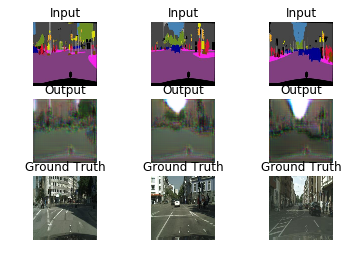

[Epoch 10/50]  [D loss: 0.089979, acc:  91%] [G loss: 17.280096] time: 0:04:45.707672


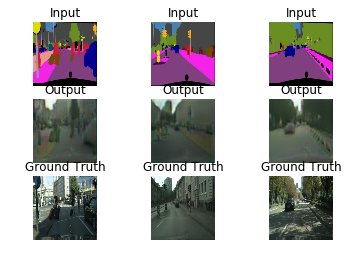

[Epoch 20/50]  [D loss: 0.198127, acc:  71%] [G loss: 15.629354] time: 0:08:51.329098


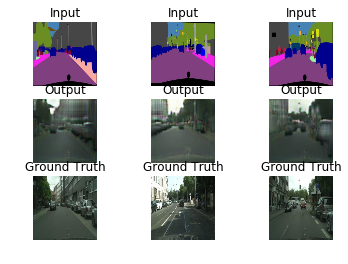

[Epoch 30/50]  [D loss: 0.447242, acc:  28%] [G loss: 16.409161] time: 0:12:56.300290


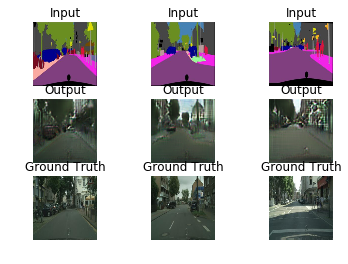

[Epoch 40/50]  [D loss: 0.246732, acc:  57%] [G loss: 12.698228] time: 0:17:01.590277


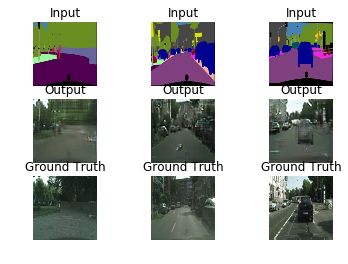

In [9]:
train("cityscapes",epochs=50, batch_size=32, show_interval=10)

Now ,for the **edges2shoes** dataset.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/50]  [D loss: 0.299655, acc:  43%] [G loss: 18.155773] time: 0:00:27.339478


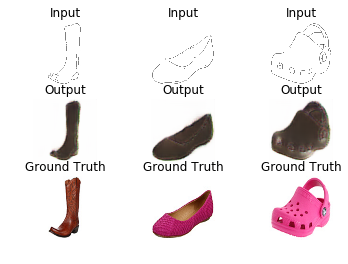

[Epoch 10/50]  [D loss: 0.274804, acc:  48%] [G loss: 13.047557] time: 0:04:38.533191


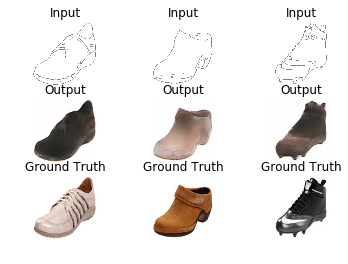

[Epoch 20/50]  [D loss: 0.269215, acc:  50%] [G loss: 9.944668] time: 0:08:49.781997


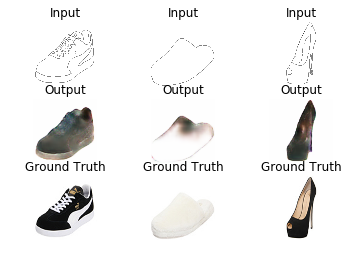

[Epoch 30/50]  [D loss: 0.224293, acc:  59%] [G loss: 8.039029] time: 0:12:59.230534


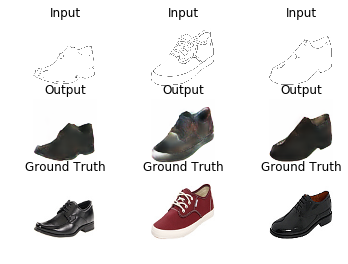

[Epoch 40/50]  [D loss: 0.338973, acc:  33%] [G loss: 7.448901] time: 0:17:08.031607


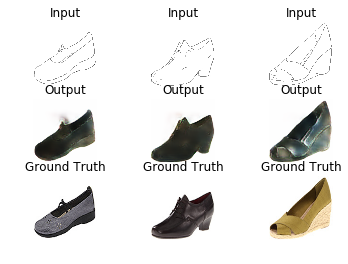

In [10]:
train("edges2shoes",epochs=50, batch_size=32, show_interval=10)

The generated images can be improved by training through more epochs or some fine-tuning .for learning rates of generator and discriminator.
You can also try this on the **facades** and **maps** dataset, just change the name of the dataset in the call to train.
This is a fundamental code , from which you can start and make it better.

If you liked the work, please  UPVOTE! 

I'm open to suggestions, questions and feedbacks , you can leave them below.